In [0]:
!pip install torchvision
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable
import gym
from gym import wrappers
import random
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import cv2
import math

## Environment - Pong
## Algorithm - DQN

1. Replay memory size - 10000 (For faster training)
2. Batch size - Number of random samples taken for each training
3. Gamma - discount factor
4. USE_CUDA - using GPU when available
5. episodes - numer of training episodes 
6. Transition - Tuple definition of how it will be stored in the replay memory

In [0]:
num_frames=4
TOTAL_STEPS = 0
BATCH_SIZE = 32
GAMMA = 0.99
MIN_REPLAY_MEMORY = 3000
MAX_REPLAY_MEMORY = 10000
TARGET_UPDATE_FREQUENCY = 1000
TRAIN_EVERY = 4
USE_CUDA = torch.cuda.is_available()
path = '/drive/My Drive/Pong-DQN.model'
episodes = 2001
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

## Replay Memory

Experience Reply, where the transitions are stored and randomly retrieved in batches

In [0]:
class ReplayMemory(object):
    def __init__(self, maxlen):
        self.maxlen = maxlen
        self.memory = []
        self.pos = 0

    def add(self, *args):
        if len(self.memory) < self.maxlen:
            self.memory.append(None)
        self.memory[self.pos] = Transition(*args)
        self.pos = (self.pos + 1) % self.maxlen

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)


## DQN Network
The main neural network used for training. This one is implemented in PyTorch with 3 convolutions and 2 fully connected layers

In [0]:
class DQN(nn.Module):

    def __init__(self, num_frames,num_actions):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(num_frames, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = nn.Linear(3136, 512)
        self.fc5 = nn.Linear(512, num_actions)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x.view(x.size(0), -1)))
        return self.fc5(x)
       

*** Images have to be preprocessed in order to make it easier for the network to train. Otherise, the memory requirement and time taken for training can be very demanding ***

In [0]:
resize = T.Compose([T.ToPILImage(), T.Resize(84, interpolation=Image.CUBIC), T.ToTensor()])

def get_preprocessed_state():
    state = env.render(mode='rgb_array')
    state =  cv2.cvtColor(state, cv2.COLOR_BGR2GRAY)[34:194,:]
    state = np.ascontiguousarray(state, dtype=np.float32) / 255
    state = torch.from_numpy(state).unsqueeze(0)
    return resize(state).unsqueeze(0)

*** As the number of steps here is more, normal decay would reach the minimum at a very faster rate, so epsilon should be decayed exponentially ***

In [0]:
#Helper Function for GPU functionalities
def get_variable(x):
    if use_cuda:
        return x.cuda()
    return x

# Reference: hhttps://towardsdatascience.com/why-going-from-implementing-q-learning-to-deep-q-learning-can-be-difficult-36e7ea1648af
def decay_epsilon(steps):
    return MIN_EPSILON + (EPSILON - MIN_EPSILON) * math.exp(-1. * steps / DECAY)


*** Here, the agent class is declared where the models, replay memory and optimizer are declared. Training  and optimizations for the models happen in this class ***

In [0]:
class Agent:
    def __init__(self, num_frames, n_actions):
        self.model = DQN(num_frames, n_actions)
        self.target_model = DQN(num_frames, n_actions)
        self.memory = ReplayMemory(MAX_REPLAY_MEMORY)
        self.optimizer = optim.RMSprop(self.model.parameters(),lr=0.0001)
        self.target_model.load_state_dict(self.model.state_dict())
        if USE_CUDA:
          self.model = self.model.cuda()
          self.target_model = self.target_model.cuda()


    
    def train(self):
        #if there are not enough transitions available in the memory, then training won't start
        if len(self.memory.memory) < MIN_REPLAY_MEMORY:
            return
        
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        # get all the transitions and estimate the Q values
        current_states = torch.cat(batch.state)
        actions = torch.cat(batch.action)
        rewards = torch.cat(batch.reward)

        next_states = torch.cat([s for s in batch.next_state if s is not None])
        none_states = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),  dtype=torch.bool)

        current_state_action_values = self.model(current_states).gather(1, actions)
        future_q_values = get_variable(torch.zeros(BATCH_SIZE))
        future_q_values[none_states] = self.target_model(next_states).max(1)[0].detach()
        
        expected_state_action_values = (future_q_values * GAMMA) + rewards

        loss = nn.MSELoss()(current_state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

*** This is the main function where the environment is decalred and Training actually starts. ***

Episode:  0
Steps:  1  epsilon:  1.0
Steps:  201  epsilon:  0.990348338736693


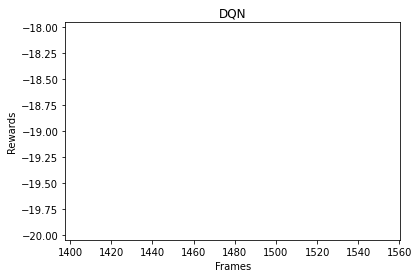

Episode:  1
Steps:  370  epsilon:  0.9822675845429503
Steps:  570  epsilon:  0.9727923637614697
Episode:  2
Steps:  693  epsilon:  0.9670119836123195
Steps:  893  epsilon:  0.9576885585963552
Episode:  3
Steps:  955  epsilon:  0.9548171770056697
Steps:  1155  epsilon:  0.9456150923428381
Episode:  4
Steps:  1288  epsilon:  0.9395464525701878
Steps:  1488  epsilon:  0.93049631415426
Episode:  5
Steps:  1592  epsilon:  0.9258258869553995
Steps:  1792  epsilon:  0.9169122704483942
Episode:  6
Steps:  1988  epsilon:  0.9082629809396291
Steps:  2188  epsilon:  0.8995241182673286
Episode:  7
Steps:  2260  epsilon:  0.896399459202514
Steps:  2460  epsilon:  0.887778640543818
Episode:  8
Steps:  2576  epsilon:  0.8828179244119793
Steps:  2776  epsilon:  0.8743322442823906
Episode:  9
Steps:  2920  epsilon:  0.8682748847855166
Steps:  3120  epsilon:  0.8599339103180038
Episode:  10
Steps:  3247  epsilon:  0.8546805271315515
Steps:  3447  epsilon:  0.8464748187827689


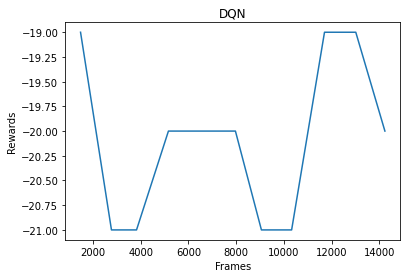

Episode:  11
Steps:  3551  epsilon:  0.8422401693556814
Steps:  3751  epsilon:  0.8341582446349883
Episode:  12
Steps:  3931  epsilon:  0.8269532913563961
Steps:  4131  epsilon:  0.8190234736132522
Episode:  13
Steps:  4232  epsilon:  0.8150489491923568
Steps:  4432  epsilon:  0.8072375816328521
Episode:  14
Steps:  4491  epsilon:  0.8049481093989242
Steps:  4691  epsilon:  0.797237246874637
Episode:  15
Steps:  4812  epsilon:  0.7926094746576626
Steps:  5012  epsilon:  0.7850213836003592
Episode:  16
Steps:  5072  epsilon:  0.7827597136507348
Steps:  5272  epsilon:  0.7752696293529814
Episode:  17
Steps:  5417  epsilon:  0.7698859639089625
Steps:  5617  epsilon:  0.7625239755614113
Episode:  18
Steps:  5714  epsilon:  0.7589798357661914
Steps:  5914  epsilon:  0.7517263652068136
Episode:  19
Steps:  5993  epsilon:  0.7488811690260506
Steps:  6193  epsilon:  0.741728181879649
Episode:  20
Steps:  6306  epsilon:  0.7377182563588568
Steps:  6506  epsilon:  0.7306763420493373


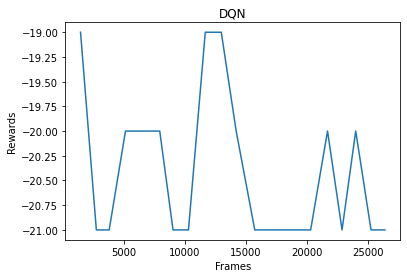

Episode:  21
Steps:  6590  epsilon:  0.7277396727351924
Steps:  6790  epsilon:  0.7207970469916761
Episode:  22
Steps:  6954  epsilon:  0.7151556724524218
Steps:  7154  epsilon:  0.7083382596038197
Episode:  23
Steps:  7254  epsilon:  0.704955033419646
Steps:  7454  epsilon:  0.6982391186252848
Episode:  24
Steps:  7536  epsilon:  0.6955049471206232
Steps:  7736  epsilon:  0.6888830622560218
Episode:  25
Steps:  7873  epsilon:  0.684385136263905
Steps:  8073  epsilon:  0.6778738953660057
Episode:  26
Steps:  8170  epsilon:  0.6747393144765667
Steps:  8370  epsilon:  0.6683240511090774
Episode:  27
Steps:  8431  epsilon:  0.6663801287417496
Steps:  8631  epsilon:  0.6600480406620433
Episode:  28
Steps:  8711  epsilon:  0.6575328821699231
Steps:  8911  epsilon:  0.6512888256644686
Episode:  29
Steps:  9010  epsilon:  0.6482210449985997
Steps:  9210  epsilon:  0.6420696428211005
Episode:  30
Steps:  9293  epsilon:  0.6395348172045491
Steps:  9493  epsilon:  0.6334698444376934


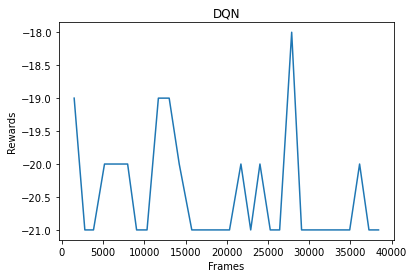

Episode:  31
Steps:  9583  epsilon:  0.630760331115002
Steps:  9783  epsilon:  0.6247826659435028
Episode:  32
Steps:  9897  epsilon:  0.6214020486598996
Steps:  10097  epsilon:  0.6155174999546509
Episode:  33
Steps:  10193  epsilon:  0.6127137503371477
Steps:  10393  epsilon:  0.6069156516446474
Episode:  34
Steps:  10442  epsilon:  0.6055039383530509
Steps:  10642  epsilon:  0.5997775784884295
Episode:  35
Steps:  10729  epsilon:  0.5973044290219408
Steps:  10929  epsilon:  0.5916596556383391
Episode:  36
Steps:  11001  epsilon:  0.5896413160690721
Steps:  11201  epsilon:  0.5840727919333505
Episode:  37
Steps:  11329  epsilon:  0.5805380493066291
Steps:  11529  epsilon:  0.5750601041886194
Episode:  38
Steps:  11632  epsilon:  0.5722602604379413
Steps:  11832  epsilon:  0.5668646806953643
Episode:  39
Steps:  11896  epsilon:  0.5651494595346515
Steps:  12096  epsilon:  0.5598246334432389
Episode:  40
Steps:  12168  epsilon:  0.5579206939102568
Steps:  12368  epsilon:  0.55266779523

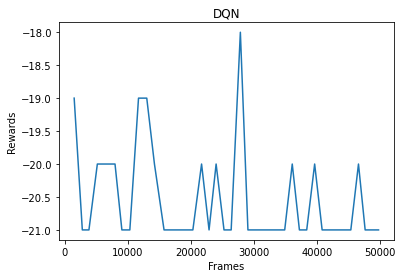

Episode:  41
Steps:  12426  epsilon:  0.5511542543274642
Steps:  12626  epsilon:  0.5459686828545776
Episode:  42
Steps:  12697  epsilon:  0.5441402414342089
Steps:  12897  epsilon:  0.5390244605556958
Episode:  43
Steps:  12998  epsilon:  0.5364603668158138
Steps:  13198  epsilon:  0.531421001966539
Episode:  44
Steps:  13281  epsilon:  0.529344416703131
Steps:  13481  epsilon:  0.5243758567405101
Episode:  45
Steps:  13562  epsilon:  0.5223776835526687
Steps:  13762  epsilon:  0.5174784437431201
Episode:  46
Steps:  13887  epsilon:  0.5144412047284856
Steps:  14087  epsilon:  0.509620934202684
Episode:  47
Steps:  14268  epsilon:  0.5052999467081619
Steps:  14468  epsilon:  0.5005706332194042
Episode:  48
Steps:  14551  epsilon:  0.49862181169317465
Steps:  14751  epsilon:  0.4939589467580615
Episode:  49
Steps:  14814  epsilon:  0.4924997754770932
Steps:  15014  epsilon:  0.48789782582012375
Episode:  50
Steps:  15092  epsilon:  0.48611550208979404
Steps:  15292  epsilon:  0.4815770

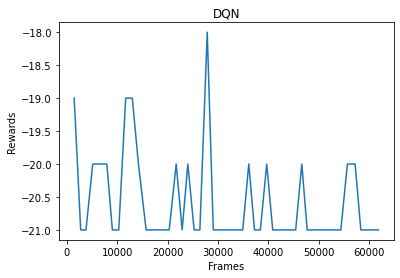

Episode:  51
Steps:  15427  epsilon:  0.4785391961270119
Steps:  15627  epsilon:  0.4740761565555336
Episode:  52
Steps:  15683  epsilon:  0.4728344824721218
Steps:  15883  epsilon:  0.46842820574992305
Episode:  53
Steps:  15983  epsilon:  0.4662415359512304
Steps:  16183  epsilon:  0.46190086014299736
Episode:  54
Steps:  16234  epsilon:  0.4608009159744798
Steps:  16434  epsilon:  0.456514375239523
Episode:  55
Steps:  16532  epsilon:  0.45442956675299395
Steps:  16732  epsilon:  0.4502064220020331
Episode:  56
Steps:  16796  epsilon:  0.4488639106154546
Steps:  16996  epsilon:  0.4446961450683573
Episode:  57
Steps:  17088  epsilon:  0.4427929235665098
Steps:  17288  epsilon:  0.43868556534985614
Episode:  58
Steps:  17393  epsilon:  0.4365455884862932
Steps:  17593  epsilon:  0.4325003922923124
Episode:  59
Steps:  17651  epsilon:  0.43133483203390277
Steps:  17851  epsilon:  0.4273414837329157
Episode:  60
Steps:  17955  epsilon:  0.42528067077489184
Steps:  18155  epsilon:  0.42

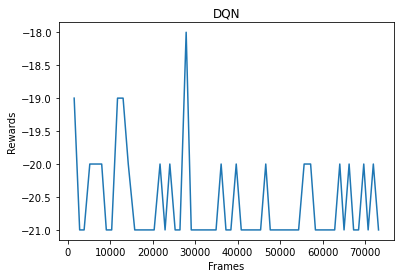

Episode:  61
Steps:  18261  epsilon:  0.4192789070832257
Steps:  18461  epsilon:  0.41540551723980534
Episode:  62
Steps:  18572  epsilon:  0.41327244137997177
Steps:  18772  epsilon:  0.40945881686887886
Episode:  63
Steps:  18921  epsilon:  0.4066423530376968
Steps:  19121  epsilon:  0.40289469900786723
Episode:  64
Steps:  19226  epsilon:  0.4009421318117663
Steps:  19426  epsilon:  0.39725119593080127
Episode:  65
Steps:  19516  epsilon:  0.39560227839611306
Steps:  19716  epsilon:  0.3919644749443888
Episode:  66
Steps:  19796  epsilon:  0.3905195089033142
Steps:  19996  epsilon:  0.386932279853058
Episode:  67
Steps:  20076  epsilon:  0.3855074023884112
Steps:  20276  epsilon:  0.38197004463124506
Episode:  68
Steps:  20412  epsilon:  0.379584767461391
Steps:  20612  epsilon:  0.37610634090639183
Episode:  69
Steps:  20756  epsilon:  0.3736233248363381
Steps:  20956  epsilon:  0.3702042156265529
Episode:  70
Steps:  21084  epsilon:  0.3680338611888816
Steps:  21284  epsilon:  0.3

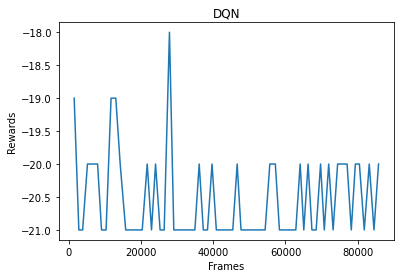

Episode:  71
Steps:  21398  epsilon:  0.3627681733786975
Steps:  21598  epsilon:  0.35945707473059385
Episode:  72
Steps:  21719  epsilon:  0.3574698767636877
Steps:  21919  epsilon:  0.35421149704774946
Episode:  73
Steps:  22013  epsilon:  0.35269127832409397
Steps:  22213  epsilon:  0.34948044645707577
Episode:  74
Steps:  22343  epsilon:  0.34741055798038123
Steps:  22543  epsilon:  0.3442522701587071
Episode:  75
Steps:  22647  epsilon:  0.34262239968974095
Steps:  22847  epsilon:  0.339511754839094
Episode:  76
Steps:  22970  epsilon:  0.3376140988202623
Steps:  23170  epsilon:  0.33455328739590084
Episode:  77
Steps:  23295  epsilon:  0.3326557652831047
Steps:  23495  epsilon:  0.329644290101765
Episode:  78
Steps:  23693  epsilon:  0.3266924473604632
Steps:  23893  epsilon:  0.32374030818386035
Episode:  79
Steps:  23977  epsilon:  0.3225091860557062
Steps:  24177  epsilon:  0.3195986710245565
Episode:  80
Steps:  24317  epsilon:  0.3175785589683654
Steps:  24517  epsilon:  0.3

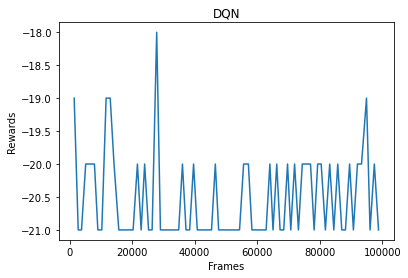

Episode:  81
Steps:  24653  epsilon:  0.3127875959499715
Steps:  24853  epsilon:  0.30997381235659627
Steps:  25053  epsilon:  0.3071880263777689
Episode:  82
Steps:  25117  epsilon:  0.30630244238344917
Steps:  25317  epsilon:  0.3035531871462229
Episode:  83
Steps:  25431  epsilon:  0.3019983694196767
Steps:  25631  epsilon:  0.29929194042399576
Episode:  84
Steps:  25775  epsilon:  0.29736000177803623
Steps:  25975  epsilon:  0.294699725311522
Episode:  85
Steps:  26109  epsilon:  0.29293216509081743
Steps:  26309  epsilon:  0.29031594633547264
Episode:  86
Steps:  26428  epsilon:  0.28877166524696307
Steps:  26628  epsilon:  0.2861968441567512
Episode:  87
Steps:  26812  epsilon:  0.2838506422677193
Steps:  27012  epsilon:  0.28132478617427503
Steps:  27212  epsilon:  0.27882406276888616
Episode:  88
Steps:  27314  epsilon:  0.2775582905115812
Steps:  27514  epsilon:  0.27509504436421917
Episode:  89
Steps:  27683  epsilon:  0.2730327168443766
Steps:  27883  epsilon:  0.27061450090

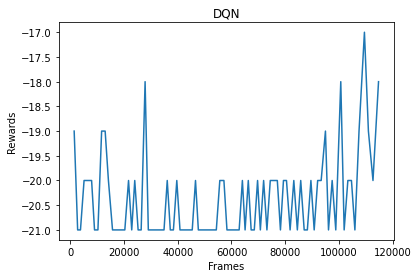

Episode:  91
Steps:  28624  epsilon:  0.26186285891058997
Steps:  28824  epsilon:  0.2595557849170364
Steps:  29024  epsilon:  0.2572716666932717
Episode:  92
Steps:  29072  epsilon:  0.256726868712288
Steps:  29272  epsilon:  0.2544708986750702
Steps:  29472  epsilon:  0.25223737591477957
Episode:  93
Steps:  29507  epsilon:  0.2518488006094885
Steps:  29707  epsilon:  0.2496413681608764
Steps:  29907  epsilon:  0.24745590003211548
Episode:  94
Steps:  29958  epsilon:  0.24690209388995857
Steps:  30158  epsilon:  0.2447438819955999
Steps:  30358  epsilon:  0.24260714466839464
Episode:  95
Steps:  30365  epsilon:  0.24253274518842918
Steps:  30565  epsilon:  0.24041800904005858
Episode:  96
Steps:  30746  epsilon:  0.23852231700318835
Steps:  30946  epsilon:  0.23644748528199794
Episode:  97
Steps:  31128  epsilon:  0.2345773352541344
Steps:  31328  epsilon:  0.23254175675720357
Steps:  31528  epsilon:  0.23052643260473382
Episode:  98
Steps:  31647  epsilon:  0.22933684286973274
Steps

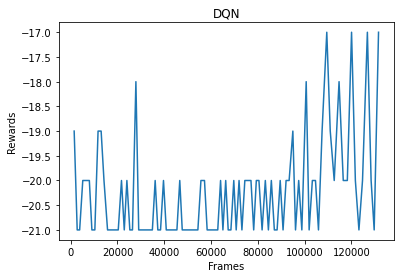

Episode:  101
Steps:  32838  epsilon:  0.21781286562770244
Steps:  33038  epsilon:  0.21594409639066164
Episode:  102
Steps:  33232  epsilon:  0.21414915817978425
Steps:  33432  epsilon:  0.21231684344094465
Steps:  33632  epsilon:  0.21050276053838035
Episode:  103
Steps:  33830  epsilon:  0.20872459962865902
Steps:  34030  epsilon:  0.2069462601492405
Episode:  104
Steps:  34193  epsilon:  0.20551000880320092
Steps:  34393  epsilon:  0.20376365503692406
Steps:  34593  epsilon:  0.20203467778095446
Episode:  105
Steps:  34744  epsilon:  0.20074070685059603
Steps:  34944  epsilon:  0.19904180843164807
Steps:  35144  epsilon:  0.19735981433441185
Episode:  106
Steps:  35195  epsilon:  0.19693359047424083
Steps:  35395  epsilon:  0.19527257349617386
Episode:  107
Steps:  35571  epsilon:  0.19382455547323935
Steps:  35771  epsilon:  0.192194473910312
Steps:  35971  epsilon:  0.19058061192993817
Episode:  108
Steps:  36008  epsilon:  0.19028381242206224
Steps:  36208  epsilon:  0.188688961

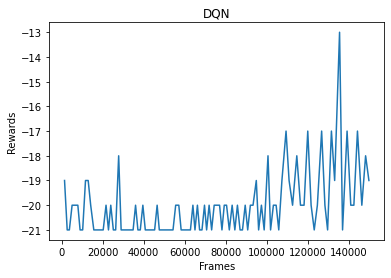

Episode:  111
Steps:  37401  epsilon:  0.17949995196067745
Steps:  37601  epsilon:  0.17801240258417736
Steps:  37801  epsilon:  0.17653965457127974
Episode:  112
Steps:  37837  epsilon:  0.17627612044491936
Steps:  38037  epsilon:  0.1748206487279657
Steps:  38237  epsilon:  0.1733796591965691
Episode:  113
Steps:  38390  epsilon:  0.17228698959375396
Steps:  38590  epsilon:  0.1708712103919657
Episode:  114
Steps:  38734  epsilon:  0.16986058031135196
Steps:  38934  epsilon:  0.1684689442853162
Episode:  115
Steps:  39134  epsilon:  0.1670911552691001
Steps:  39334  epsilon:  0.16572707548265392
Steps:  39534  epsilon:  0.1643765685168623
Episode:  116
Steps:  39677  epsilon:  0.16341920271328883
Steps:  39877  epsilon:  0.16209165946523812
Steps:  40077  epsilon:  0.16077732549321072
Steps:  40277  epsilon:  0.15947606936271416
Episode:  117
Steps:  40312  epsilon:  0.15924968438595935
Steps:  40512  epsilon:  0.15796362853845153
Steps:  40712  epsilon:  0.15669036916043422
Episode:

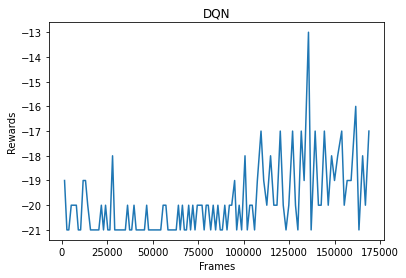

Episode:  121
Steps:  42119  epsilon:  0.14808398062008726
Steps:  42319  epsilon:  0.14690902538135742
Steps:  42519  epsilon:  0.14574576114259014
Episode:  122
Steps:  42554  epsilon:  0.14554338319294507
Steps:  42754  epsilon:  0.14439370732099172
Episode:  123
Steps:  42927  epsilon:  0.14340846905133958
Steps:  43127  epsilon:  0.14228003593002644
Steps:  43327  epsilon:  0.14116283090587328
Episode:  124
Steps:  43474  epsilon:  0.14034877940274393
Steps:  43674  epsilon:  0.13925079070211022
Steps:  43874  epsilon:  0.13816372717158942
Episode:  125
Steps:  43908  epsilon:  0.13798000504345304
Steps:  44108  epsilon:  0.136905586041505
Steps:  44308  epsilon:  0.1358418576872494
Episode:  126
Steps:  44383  epsilon:  0.13544569399210482
Steps:  44583  epsilon:  0.13439649180644905
Episode:  127
Steps:  44776  epsilon:  0.13339391089364577
Steps:  44976  epsilon:  0.1323651242909303
Steps:  45176  epsilon:  0.13134657428594843
Episode:  128
Steps:  45259  epsilon:  0.1309268575

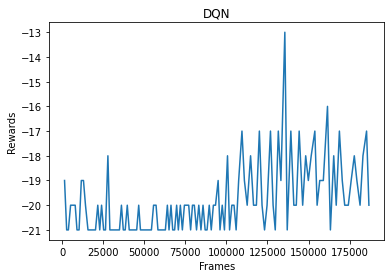

Episode:  131
Steps:  46604  epsilon:  0.124362719207332
Steps:  46804  epsilon:  0.12342379446333848
Steps:  47004  epsilon:  0.12249421217664469
Episode:  132
Steps:  47199  epsilon:  0.12159677572001665
Steps:  47399  epsilon:  0.12068537257356234
Steps:  47599  epsilon:  0.11978303803993673
Episode:  133
Steps:  47742  epsilon:  0.11914337882472478
Steps:  47942  epsilon:  0.11825638738525786
Steps:  48142  epsilon:  0.11737822165807674
Steps:  48342  epsilon:  0.11650879382587681
Episode:  134
Steps:  48385  epsilon:  0.11632299971938509
Steps:  48585  epsilon:  0.11546407152090671
Steps:  48785  epsilon:  0.11461368980080068
Episode:  135
Steps:  48822  epsilon:  0.11445729918059679
Steps:  49022  epsilon:  0.11361693501265362
Steps:  49222  epsilon:  0.11278493260789267
Episode:  136
Steps:  49339  epsilon:  0.11230205454757006
Steps:  49539  epsilon:  0.11148313542203667
Steps:  49739  epsilon:  0.11067236467794837
Episode:  137
Steps:  49856  epsilon:  0.11020180906172485
Step

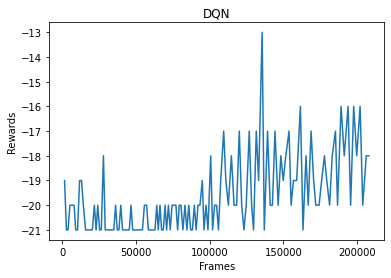

Episode:  141
Steps:  51920  epsilon:  0.1023377462804888
Steps:  52120  epsilon:  0.10161797367878746
Steps:  52320  epsilon:  0.1009053629341358
Steps:  52520  epsilon:  0.10019984278486559
Episode:  142
Steps:  52534  epsilon:  0.10015072008986527
Steps:  52734  epsilon:  0.09945270876235554
Steps:  52934  epsilon:  0.09876164276359947
Episode:  143
Steps:  53116  epsilon:  0.09813875027375088
Steps:  53316  epsilon:  0.09746075838040313
Steps:  53516  epsilon:  0.09678951261911091
Steps:  53716  epsilon:  0.09612494586473871
Episode:  144
Steps:  53764  epsilon:  0.09596643628224694
Steps:  53964  epsilon:  0.09531005927426366
Steps:  54164  epsilon:  0.09466021332663306
Episode:  145
Steps:  54267  epsilon:  0.09432806923314895
Steps:  54467  epsilon:  0.09368799424968406
Steps:  54667  epsilon:  0.09305428811871769
Steps:  54867  epsilon:  0.09242688746910858
Episode:  146
Steps:  54914  epsilon:  0.09228035652485045
Steps:  55114  epsilon:  0.09166065662326708
Steps:  55314  eps

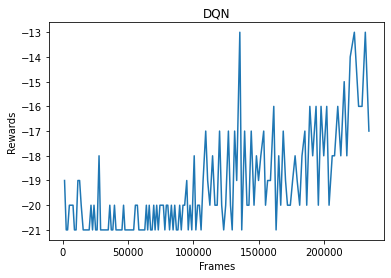

Episode:  151
Steps:  58486  epsilon:  0.08209380686277429
Steps:  58686  epsilon:  0.08157546482385095
Steps:  58886  epsilon:  0.0810622803743897
Steps:  59086  epsilon:  0.08055420219551793
Episode:  152
Steps:  59256  epsilon:  0.08012631258395408
Steps:  59456  epsilon:  0.07962754744020259
Steps:  59656  epsilon:  0.07913374509255153
Steps:  59856  epsilon:  0.07864485616035463
Steps:  60056  epsilon:  0.07816083175431131
Episode:  153
Steps:  60116  epsilon:  0.07801656576622996
Steps:  60316  epsilon:  0.07753879295406196
Steps:  60516  epsilon:  0.07706577406080517
Steps:  60716  epsilon:  0.07659746178417606
Episode:  154
Steps:  60864  epsilon:  0.07625391326422198
Steps:  61064  epsilon:  0.07579367913749141
Steps:  61264  epsilon:  0.07533802441683612
Steps:  61464  epsilon:  0.07488690353640431
Episode:  155
Steps:  61519  epsilon:  0.07476363412480556
Steps:  61719  epsilon:  0.07431822852327231
Steps:  61919  epsilon:  0.0738772547815234
Steps:  62119  epsilon:  0.07344

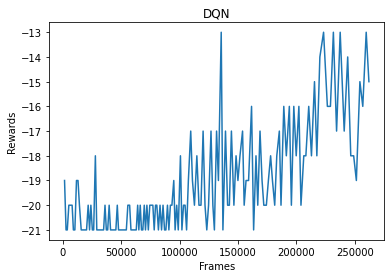

Episode:  161
Steps:  65396  epsilon:  0.06687545197365063
Steps:  65596  epsilon:  0.06650853509593825
Steps:  65796  epsilon:  0.06614526910215933
Steps:  65996  epsilon:  0.0657856176654118
Episode:  162
Steps:  65998  epsilon:  0.06578203928256737
Steps:  66198  epsilon:  0.06542600204291203
Steps:  66398  epsilon:  0.06507350743298274
Steps:  66598  epsilon:  0.06472452020302477
Episode:  163
Steps:  66629  epsilon:  0.06467073888799671
Steps:  66829  epsilon:  0.06432575927202194
Steps:  67029  epsilon:  0.06398421226057929
Steps:  67229  epsilon:  0.06364606369868296
Episode:  164
Steps:  67335  epsilon:  0.06346821128629544
Steps:  67535  epsilon:  0.06313519701987882
Steps:  67735  epsilon:  0.06280549630077698
Steps:  67935  epsilon:  0.062479076158643176
Episode:  165
Steps:  68040  epsilon:  0.06230900782880165
Steps:  68240  epsilon:  0.06198752782950564
Steps:  68440  epsilon:  0.06166924660964895
Episode:  166
Steps:  68611  epsilon:  0.06139962880970714
Steps:  68811  e

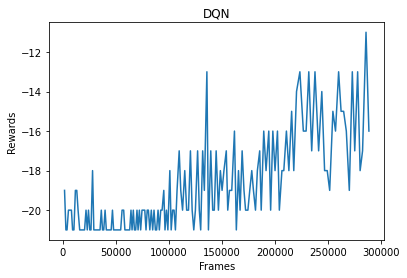

Episode:  171
Steps:  71944  epsilon:  0.056579654946323416
Steps:  72144  epsilon:  0.05631518296071776
Steps:  72344  epsilon:  0.056053342515337556
Steps:  72544  epsilon:  0.05579410742592008
Episode:  172
Steps:  72550  epsilon:  0.05578637035431107
Steps:  72750  epsilon:  0.05552979168228016
Steps:  72950  epsilon:  0.055275766010692354
Steps:  73150  epsilon:  0.055024267936768845
Episode:  173
Steps:  73266  epsilon:  0.05487954727834503
Steps:  73466  epsilon:  0.05463199164668006
Steps:  73666  epsilon:  0.05438689923470649
Steps:  73866  epsilon:  0.05414424553297888
Episode:  174
Steps:  73868  epsilon:  0.054141831229142776
Steps:  74068  epsilon:  0.05390161599481329
Steps:  74268  epsilon:  0.05366379094200134
Episode:  175
Steps:  74441  epsilon:  0.05345998189527043
Steps:  74641  epsilon:  0.05322655117517097
Steps:  74841  epsilon:  0.05299544312954457
Steps:  75041  epsilon:  0.05276663464739406
Episode:  176
Steps:  75224  epsilon:  0.05255927008002077
Steps:  754

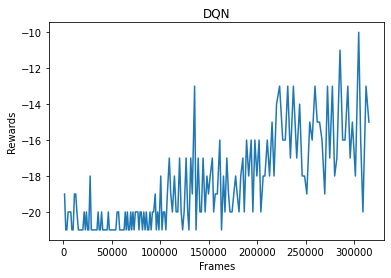

Episode:  181
Steps:  78700  epsilon:  0.048960276337767436
Steps:  78900  epsilon:  0.04877161843604494
Steps:  79100  epsilon:  0.048584837711809103
Steps:  79300  epsilon:  0.04839991548683188
Steps:  79500  epsilon:  0.048216833268736645
Steps:  79700  epsilon:  0.048035572749149026
Episode:  182
Steps:  79706  epsilon:  0.0480301628888439
Steps:  79906  epsilon:  0.04785075977057032
Steps:  80106  epsilon:  0.04767314174314948
Steps:  80306  epsilon:  0.04749729104463063
Steps:  80506  epsilon:  0.047323190089797365
Episode:  183
Steps:  80536  epsilon:  0.04729722478351088
Steps:  80736  epsilon:  0.04712511452123694
Steps:  80936  epsilon:  0.04695471678468609
Steps:  81136  epsilon:  0.04678601453394269
Episode:  184
Steps:  81181  epsilon:  0.04674828845899133
Steps:  81381  epsilon:  0.04658164020440747
Steps:  81581  epsilon:  0.04641665012766215
Episode:  185
Steps:  81778  epsilon:  0.046255739907728396
Steps:  81978  epsilon:  0.046093992593116216
Steps:  82178  epsilon: 

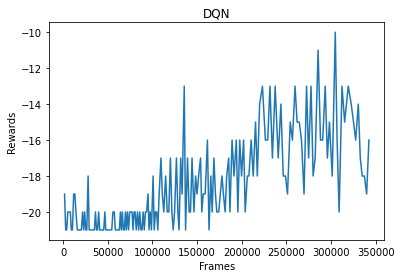

Episode:  191
Steps:  85484  epsilon:  0.043506162617875564
Steps:  85684  epsilon:  0.043371774054416924
Steps:  85884  epsilon:  0.043238722679506916
Steps:  86084  epsilon:  0.043106995187897165
Steps:  86284  epsilon:  0.042976578406728735
Episode:  192
Steps:  86294  epsilon:  0.04297009173932735
Steps:  86494  epsilon:  0.04284103717023251
Steps:  86694  epsilon:  0.04271326671555559
Steps:  86894  epsilon:  0.04258676759814464
Episode:  193
Steps:  87066  epsilon:  0.04247898552401538
Steps:  87266  epsilon:  0.0423548175434097
Steps:  87466  epsilon:  0.04223188505485408
Steps:  87666  epsilon:  0.04211017576499721
Steps:  87866  epsilon:  0.041989677502808694
Episode:  194
Steps:  87909  epsilon:  0.0419639273874708
Steps:  88109  epsilon:  0.04184488432095258
Steps:  88309  epsilon:  0.041727025752737235
Steps:  88509  epsilon:  0.041610339896869714
Episode:  195
Steps:  88684  epsilon:  0.04150919258759028
Steps:  88884  epsilon:  0.04139467420793092
Steps:  89084  epsilon: 

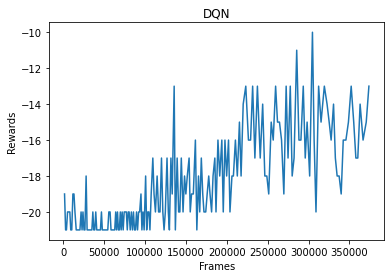

Episode:  201
Steps:  93324  epsilon:  0.03912616964471974
Steps:  93524  epsilon:  0.039035362739521476
Steps:  93724  epsilon:  0.03894545937812667
Steps:  93924  epsilon:  0.03885645057012424
Steps:  94124  epsilon:  0.03876832741455923
Episode:  202
Steps:  94221  epsilon:  0.03872590398657021
Steps:  94421  epsilon:  0.038639079791215045
Steps:  94621  epsilon:  0.03855311951103825
Steps:  94821  epsilon:  0.03846801454994019
Episode:  203
Steps:  94920  epsilon:  0.03842620145071565
Steps:  95120  epsilon:  0.03834235934541803
Steps:  95320  epsilon:  0.03825935148300694
Steps:  95520  epsilon:  0.03817716956262696
Episode:  204
Steps:  95670  epsilon:  0.0381160701999204
Steps:  95870  epsilon:  0.038035313952127774
Steps:  96070  epsilon:  0.037955361242426475
Steps:  96270  epsilon:  0.03787620407547891
Steps:  96470  epsilon:  0.03779783453550241
Episode:  205
Steps:  96639  epsilon:  0.037732220443632614
Steps:  96839  epsilon:  0.03765528356473039
Steps:  97039  epsilon:  0

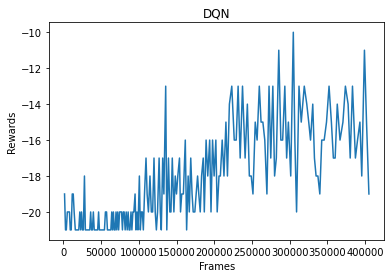

Episode:  211
Steps:  101109  epsilon:  0.03618357183597608
Steps:  101309  epsilon:  0.03612204426818415
Steps:  101509  epsilon:  0.03606112890992076
Steps:  101709  epsilon:  0.03600081966959933
Episode:  212
Steps:  101820  epsilon:  0.035967607369816725
Steps:  102020  epsilon:  0.03590822868436736
Steps:  102220  epsilon:  0.035849440826709975
Steps:  102420  epsilon:  0.035791237918009804
Steps:  102620  epsilon:  0.035733614137927486
Episode:  213
Steps:  102625  epsilon:  0.03573218091355351
Steps:  102825  epsilon:  0.03567514476048381
Steps:  103025  epsilon:  0.03561867612661946
Steps:  103225  epsilon:  0.03556276936505001
Episode:  214
Steps:  103276  epsilon:  0.03554860237375977
Steps:  103476  epsilon:  0.0354933928576811
Steps:  103676  epsilon:  0.03543873268546604
Steps:  103876  epsilon:  0.035384616391051824
Steps:  104076  epsilon:  0.0353310385627639
Episode:  215
Steps:  104135  epsilon:  0.03531533517289204
Steps:  104335  epsilon:  0.03526244670424286
Steps: 

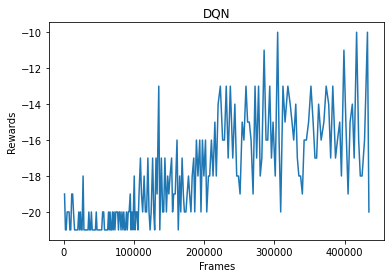

Episode:  221
Steps:  108512  epsilon:  0.03427056472031663
Steps:  108712  epsilon:  0.03422807189136454
Steps:  108912  epsilon:  0.034186001873124996
Steps:  109112  epsilon:  0.03414435045856111
Steps:  109312  epsilon:  0.034103113482496714
Episode:  222
Steps:  109359  epsilon:  0.03409348248666521
Steps:  109559  epsilon:  0.03405275165537802
Steps:  109759  epsilon:  0.03401242610263368
Steps:  109959  epsilon:  0.033972501795843296
Steps:  110159  epsilon:  0.03393297474254292
Episode:  223
Steps:  110232  epsilon:  0.033918645551414835
Steps:  110432  epsilon:  0.03387965437670017
Steps:  110632  epsilon:  0.033841051170656236
Steps:  110832  epsilon:  0.03380283207293026
Steps:  111032  epsilon:  0.033764993261580604
Episode:  224
Steps:  111167  epsilon:  0.033739665135657584
Steps:  111367  epsilon:  0.03370245484583535
Steps:  111567  epsilon:  0.03366561480458309
Steps:  111767  epsilon:  0.03362914132786597
Episode:  225
Steps:  111886  epsilon:  0.0336076120500824
Step

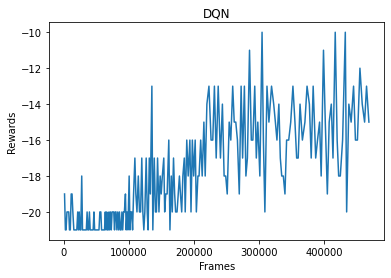

Episode:  231
Steps:  117051  epsilon:  0.03278652715031135
Steps:  117251  epsilon:  0.0327588007419033
Steps:  117451  epsilon:  0.03273135021586844
Steps:  117651  epsilon:  0.032704172827131305
Episode:  232
Steps:  117829  epsilon:  0.032680212470714
Steps:  118029  epsilon:  0.032653543911042845
Steps:  118229  epsilon:  0.03262714070797409
Steps:  118429  epsilon:  0.03260100022116542
Episode:  233
Steps:  118496  epsilon:  0.03259230144900305
Steps:  118696  epsilon:  0.03256650761861319
Steps:  118896  epsilon:  0.032540970441123966
Steps:  119096  epsilon:  0.032515687362796336
Episode:  234
Steps:  119296  epsilon:  0.03249065585530139
Steps:  119496  epsilon:  0.032465873415467535
Steps:  119696  epsilon:  0.03244133756503013
Steps:  119896  epsilon:  0.03241704585038367
Steps:  120096  epsilon:  0.03239299584233647
Steps:  120296  epsilon:  0.03236918513586767
Episode:  235
Steps:  120321  epsilon:  0.03236622550460275
Steps:  120521  epsilon:  0.032342681167444993
Steps: 

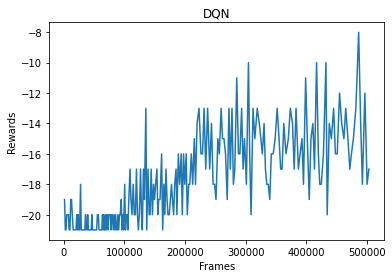

Episode:  241
Steps:  125697  epsilon:  0.0318084969239022
Steps:  125897  epsilon:  0.031790502078845255
Steps:  126097  epsilon:  0.03177268628548829
Steps:  126297  epsilon:  0.03175504776223711
Steps:  126497  epsilon:  0.0317375847452247
Episode:  242
Steps:  126575  epsilon:  0.031730821361888414
Steps:  126775  epsilon:  0.031713599401587134
Steps:  126975  epsilon:  0.03169654880265402
Steps:  127175  epsilon:  0.03167966786001496
Steps:  127375  epsilon:  0.03166295488556163
Episode:  243
Steps:  127544  epsilon:  0.03164896211947512
Steps:  127744  epsilon:  0.031632554672245024
Steps:  127944  epsilon:  0.03161631048184261
Steps:  128144  epsilon:  0.031600227923835315
Steps:  128344  epsilon:  0.03158430538995393
Episode:  244
Steps:  128380  epsilon:  0.03158145620528749
Steps:  128580  epsilon:  0.03156572045312647
Steps:  128780  epsilon:  0.03155014127431553
Steps:  128980  epsilon:  0.03153471711092382
Steps:  129180  epsilon:  0.03151944642052213
Episode:  245
Steps: 

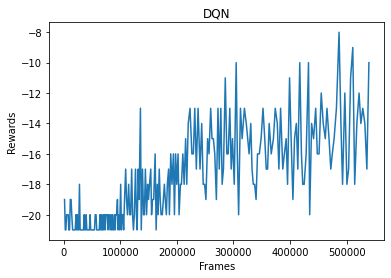

Episode:  251
Steps:  134654  epsilon:  0.031155630487311334
Steps:  134854  epsilon:  0.031144131771838054
Steps:  135054  epsilon:  0.031132747470495405
Steps:  135254  epsilon:  0.031121476444843768
Episode:  252
Steps:  135397  epsilon:  0.031113486486403417
Steps:  135597  epsilon:  0.031102407110745647
Steps:  135797  epsilon:  0.03109143797671763
Steps:  135997  epsilon:  0.03108057798739682
Steps:  136197  epsilon:  0.031069826056775232
Episode:  253
Steps:  136219  epsilon:  0.031068649895120284
Steps:  136419  epsilon:  0.031058016650999904
Steps:  136619  epsilon:  0.031047489209426307
Steps:  136819  epsilon:  0.03103706651764656
Steps:  137019  epsilon:  0.031026747533382807
Steps:  137219  epsilon:  0.031016531224728017
Episode:  254
Steps:  137382  epsilon:  0.03100828016399028
Steps:  137582  epsilon:  0.03099824760873116
Steps:  137782  epsilon:  0.03098831487906479
Steps:  137982  epsilon:  0.030978480981709924
Episode:  255
Steps:  138149  epsilon:  0.030970344681838

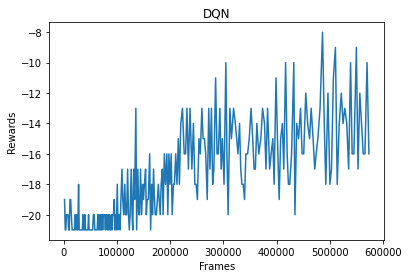

Episode:  261
Steps:  143267  epsilon:  0.030751259664615564
Steps:  143467  epsilon:  0.030743784506055093
Steps:  143667  epsilon:  0.030736383726565054
Steps:  143867  epsilon:  0.030729056586061326
Steps:  144067  epsilon:  0.03072180235182375
Episode:  262
Steps:  144195  epsilon:  0.030717197567798612
Steps:  144395  epsilon:  0.030710061332764323
Steps:  144595  epsilon:  0.030702996104455028
Steps:  144795  epsilon:  0.030696001176342014
Episode:  263
Steps:  144909  epsilon:  0.03069204525472413
Steps:  145109  epsilon:  0.030685159289386525
Steps:  145309  epsilon:  0.030678341840548826
Steps:  145509  epsilon:  0.03067159222646047
Episode:  264
Steps:  145651  epsilon:  0.030666840809143968
Steps:  145851  epsilon:  0.030660205632230146
Steps:  146051  epsilon:  0.03065363647642972
Steps:  146251  epsilon:  0.030647132684821637
Steps:  146451  epsilon:  0.030640693607021315
Episode:  265
Steps:  146509  epsilon:  0.030638838287075146
Steps:  146709  epsilon:  0.0306324817399

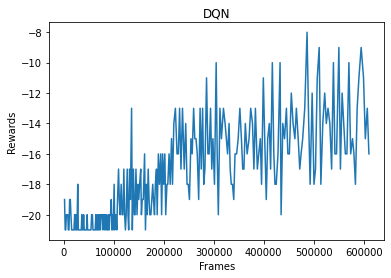

Episode:  271
Steps:  152383  epsilon:  0.030476254011965305
Steps:  152583  epsilon:  0.030471515205368626
Steps:  152783  epsilon:  0.030466823550685414
Steps:  152983  epsilon:  0.03046217857874629
Steps:  153183  epsilon:  0.03045757982505019
Episode:  272
Steps:  153303  epsilon:  0.030454842566088547
Steps:  153503  epsilon:  0.03045031680693801
Steps:  153703  epsilon:  0.030445836079843434
Steps:  153903  epsilon:  0.030441399936728373
Steps:  154103  epsilon:  0.03043700793397482
Episode:  273
Steps:  154188  epsilon:  0.03043515459139807
Steps:  154388  epsilon:  0.030430824730868843
Steps:  154588  epsilon:  0.03042653795317173
Steps:  154788  epsilon:  0.03042229382962538
Steps:  154988  epsilon:  0.030418091935813907
Steps:  155188  epsilon:  0.030413931851544427
Episode:  274
Steps:  155235  epsilon:  0.030412960253767822
Steps:  155435  epsilon:  0.030408851230587845
Steps:  155635  epsilon:  0.03040478309287164
Steps:  155835  epsilon:  0.03040075543380204
Steps:  15603

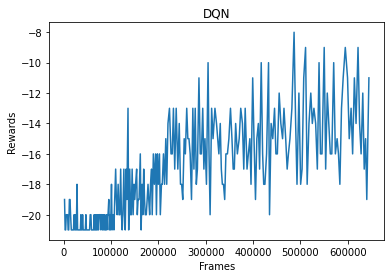

Episode:  281
Steps:  160976  epsilon:  0.03030991601780799
Steps:  161176  epsilon:  0.030306832301907005
Steps:  161376  epsilon:  0.030303779269491904
Steps:  161576  epsilon:  0.030300756615256903
Steps:  161776  epsilon:  0.03029776403693406
Steps:  161976  epsilon:  0.03029480123526305
Episode:  282
Steps:  162076  epsilon:  0.03029333090796815
Steps:  162276  epsilon:  0.03029041221666736
Steps:  162476  epsilon:  0.030287522566830247
Steps:  162676  epsilon:  0.03028466166948942
Steps:  162876  epsilon:  0.03028182923855276
Steps:  163076  epsilon:  0.030279024990774814
Episode:  283
Steps:  163230  epsilon:  0.03027688474885182
Steps:  163430  epsilon:  0.030274129699568424
Steps:  163630  epsilon:  0.03027140206348343
Steps:  163830  epsilon:  0.03026870156783095
Steps:  164030  epsilon:  0.030266027942559174
Episode:  284
Steps:  164178  epsilon:  0.030264066601695675
Steps:  164378  epsilon:  0.03026143909510751
Steps:  164578  epsilon:  0.03025883773264672
Steps:  164778  

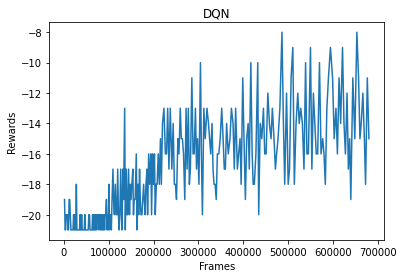

Episode:  291
Steps:  169940  epsilon:  0.030197967198034827
Steps:  170140  epsilon:  0.03019599739150217
Steps:  170340  epsilon:  0.030194047184871994
Steps:  170540  epsilon:  0.03019211638312201
Episode:  292
Steps:  170615  epsilon:  0.030191397295816682
Steps:  170815  epsilon:  0.030189492860903347
Steps:  171015  epsilon:  0.030187607375434012
Steps:  171215  epsilon:  0.03018574065085856
Steps:  171415  epsilon:  0.03018389250050298
Steps:  171615  epsilon:  0.030182062739550694
Episode:  293
Steps:  171642  epsilon:  0.030181817120682342
Steps:  171842  epsilon:  0.030180008010104304
Steps:  172042  epsilon:  0.030178216900477284
Steps:  172242  epsilon:  0.030176443612688827
Episode:  294
Steps:  172349  epsilon:  0.030175502159992467
Steps:  172549  epsilon:  0.03017375588432316
Steps:  172749  epsilon:  0.030172026984387083
Steps:  172949  epsilon:  0.030170315287292804
Steps:  173149  epsilon:  0.03016862062186918
Steps:  173349  epsilon:  0.030166942818648266
Steps:  17

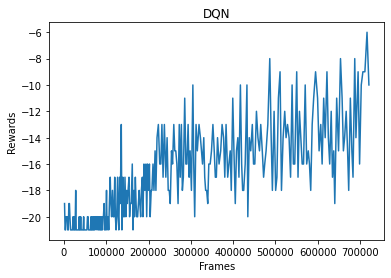

Episode:  301
Steps:  180003  epsilon:  0.0301196955398116
Steps:  180203  epsilon:  0.030118504549290992
Steps:  180403  epsilon:  0.030117325409324065
Steps:  180603  epsilon:  0.030116158001995845
Steps:  180803  epsilon:  0.03011500221056462
Episode:  302
Steps:  180931  epsilon:  0.030114268546645784
Steps:  181131  epsilon:  0.030113131555609417
Steps:  181331  epsilon:  0.03011200587782289
Steps:  181531  epsilon:  0.03011089140071748
Steps:  181731  epsilon:  0.030109788012844554
Steps:  181931  epsilon:  0.030108695603864404
Episode:  303
Steps:  181954  epsilon:  0.030108570675767384
Steps:  182154  epsilon:  0.03010749037949353
Steps:  182354  epsilon:  0.030106420832347207
Steps:  182554  epsilon:  0.0301053619273728
Steps:  182754  epsilon:  0.030104313558678934
Steps:  182954  epsilon:  0.030103275621427863
Episode:  304
Steps:  182963  epsilon:  0.03010322915785331
Steps:  183163  epsilon:  0.030102202010570733
Steps:  183363  epsilon:  0.030101185083574386
Steps:  18356

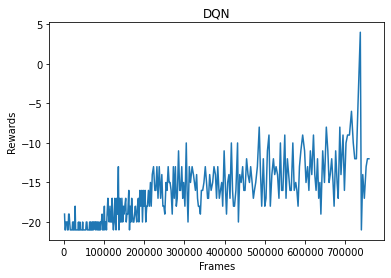

Episode:  311
Steps:  189738  epsilon:  0.030073567352744135
Steps:  189938  epsilon:  0.0300728353453537
Steps:  190138  epsilon:  0.03007211062155849
Steps:  190338  epsilon:  0.030071393108885534
Steps:  190538  epsilon:  0.03007068273558296
Steps:  190738  epsilon:  0.030069979430612848
Episode:  312
Steps:  190790  epsilon:  0.03006979772041887
Steps:  190990  epsilon:  0.030069103221496772
Steps:  191190  epsilon:  0.030068415632954412
Steps:  191390  epsilon:  0.030067734886032357
Steps:  191590  epsilon:  0.030067060912655354
Steps:  191790  epsilon:  0.0300663936454255
Episode:  313
Steps:  191822  epsilon:  0.03006628750053138
Steps:  192022  epsilon:  0.03006562792888074
Steps:  192222  epsilon:  0.03006497492007768
Steps:  192422  epsilon:  0.030064328408820774
Steps:  192622  epsilon:  0.030063688330458353
Episode:  314
Steps:  192636  epsilon:  0.030063643764227033
Steps:  192836  epsilon:  0.030063010498192145
Steps:  193036  epsilon:  0.030062383533259587
Steps:  193236

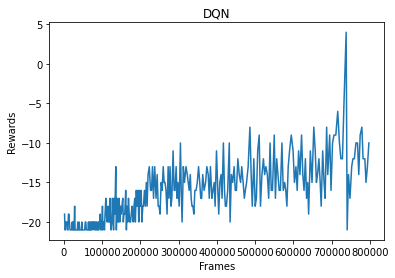

Episode:  321
Steps:  199262  epsilon:  0.030045695569717635
Steps:  199462  epsilon:  0.030045240891202016
Steps:  199662  epsilon:  0.03004479073681322
Steps:  199862  epsilon:  0.030044345061535433
Steps:  200062  epsilon:  0.03004390382080075
Episode:  322
Steps:  200256  epsilon:  0.03004348001253209
Steps:  200456  epsilon:  0.03004304737917881
Steps:  200656  epsilon:  0.030042619050599316
Steps:  200856  epsilon:  0.0300421949839604
Steps:  201056  epsilon:  0.030041775136855044
Episode:  323
Steps:  201205  epsilon:  0.030041465068524138
Steps:  201405  epsilon:  0.030041052484198718
Steps:  201605  epsilon:  0.030040644005155933
Steps:  201805  epsilon:  0.03004023959054753
Steps:  202005  epsilon:  0.030039839199931716
Steps:  202205  epsilon:  0.030039442793269096
Episode:  324
Steps:  202280  epsilon:  0.030039295159780138
Steps:  202480  epsilon:  0.030038904166407473
Steps:  202680  epsilon:  0.030038517063483868
Steps:  202880  epsilon:  0.03003813381229871
Steps:  2030

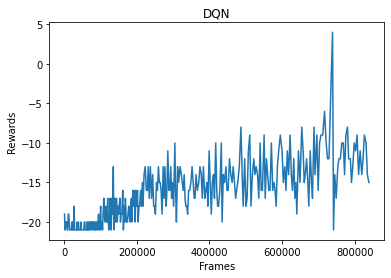

Episode:  331
Steps:  209361  epsilon:  0.030027578910007933
Steps:  209561  epsilon:  0.030027304495268338
Steps:  209761  epsilon:  0.030027032811001022
Steps:  209961  epsilon:  0.030026763830037335
Steps:  210161  epsilon:  0.030026497525478955
Steps:  210361  epsilon:  0.030026233870695203
Steps:  210561  epsilon:  0.030025972839320382
Episode:  332
Steps:  210736  epsilon:  0.030025746568355455
Steps:  210936  epsilon:  0.03002549038571993
Steps:  211136  epsilon:  0.03002523675214422
Steps:  211336  epsilon:  0.030024985642264752
Steps:  211536  epsilon:  0.030024737030970337
Steps:  211736  epsilon:  0.03002449089339963
Episode:  333
Steps:  211765  epsilon:  0.03002445540733781
Steps:  211965  epsilon:  0.030024212071969068
Steps:  212165  epsilon:  0.0300239711578277
Steps:  212365  epsilon:  0.030023732640822087
Steps:  212565  epsilon:  0.030023496497100337
Episode:  334
Steps:  212746  epsilon:  0.03002328481311639
Steps:  212946  epsilon:  0.030023053125354766
Steps:  213

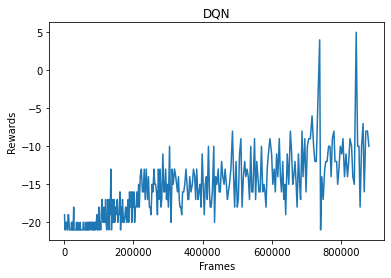

Episode:  341
Steps:  219907  epsilon:  0.03001627697203728
Steps:  220107  epsilon:  0.03001611501345945
Steps:  220307  epsilon:  0.030015954666396394
Steps:  220507  epsilon:  0.03001579591481327
Steps:  220707  epsilon:  0.030015638742834794
Steps:  220907  epsilon:  0.030015483134743635
Episode:  342
Steps:  221016  epsilon:  0.030015398981186023
Steps:  221216  epsilon:  0.03001524575876313
Steps:  221416  epsilon:  0.030015094060928817
Steps:  221616  epsilon:  0.030014943872513175
Steps:  221816  epsilon:  0.030014795178497238
Episode:  343
Steps:  221979  epsilon:  0.030014675087826695
Steps:  222179  epsilon:  0.030014529068263074
Steps:  222379  epsilon:  0.030014384501618387
Steps:  222579  epsilon:  0.03001424137343585
Episode:  344
Steps:  222724  epsilon:  0.030014138496856656
Steps:  222924  epsilon:  0.0300139978164624
Steps:  223124  epsilon:  0.030013858535861446
Steps:  223324  epsilon:  0.030013720641125632
Steps:  223524  epsilon:  0.030013584118465365
Steps:  223

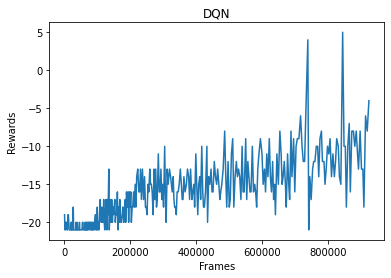

Episode:  351
Steps:  230598  epsilon:  0.030009537213439328
Steps:  230798  epsilon:  0.030009442316580037
Steps:  230998  epsilon:  0.030009348363960273
Steps:  231198  epsilon:  0.030009255346184698
Episode:  352
Steps:  231318  epsilon:  0.030009199980371125
Steps:  231518  epsilon:  0.030009108439036928
Steps:  231718  epsilon:  0.030009017808554226
Steps:  231918  epsilon:  0.030008928079859894
Steps:  232118  epsilon:  0.030008839243980987
Episode:  353
Steps:  232214  epsilon:  0.03000879691727524
Steps:  232414  epsilon:  0.030008709386485855
Steps:  232614  epsilon:  0.030008622726642377
Steps:  232814  epsilon:  0.03000853692907875
Steps:  233014  epsilon:  0.030008451985215148
Steps:  233214  epsilon:  0.030008367886557107
Steps:  233414  epsilon:  0.030008284624694695
Episode:  354
Steps:  233544  epsilon:  0.030008230949268296
Steps:  233744  epsilon:  0.030008149049954674
Steps:  233944  epsilon:  0.03000806796555284
Steps:  234144  epsilon:  0.030007987687954284
Steps: 

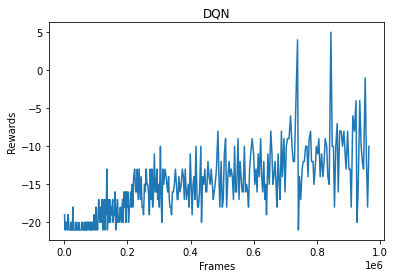

Episode:  361
Steps:  240767  epsilon:  0.03000573593832217
Steps:  240967  epsilon:  0.030005678864782257
Steps:  241167  epsilon:  0.03000562235913356
Steps:  241367  epsilon:  0.03000556641572546
Steps:  241567  epsilon:  0.030005511028963566
Episode:  362
Steps:  241714  epsilon:  0.03000547067139643
Steps:  241914  epsilon:  0.030005416237306532
Steps:  242114  epsilon:  0.03000536234484488
Steps:  242314  epsilon:  0.030005308988622175
Steps:  242514  epsilon:  0.03000525616330276
Steps:  242714  epsilon:  0.030005203863604057
Steps:  242914  epsilon:  0.03000515208429605
Episode:  363
Steps:  243053  epsilon:  0.030005116401451707
Steps:  243253  epsilon:  0.030005065492406658
Steps:  243453  epsilon:  0.030005015089915068
Steps:  243653  epsilon:  0.030004965188936653
Steps:  243853  epsilon:  0.030004915784481265
Episode:  364
Steps:  243948  epsilon:  0.03000489248987347
Steps:  244148  epsilon:  0.03000484380878585
Steps:  244348  epsilon:  0.030004795612083142
Steps:  24454

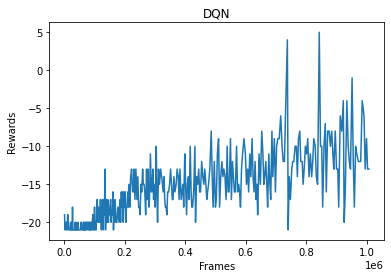

Episode:  371
Steps:  251751  epsilon:  0.030003311997065425
Steps:  251951  epsilon:  0.030003279042144
Steps:  252151  epsilon:  0.030003246415129525
Steps:  252351  epsilon:  0.030003214112759267
Steps:  252551  epsilon:  0.030003182131802964
Steps:  252751  epsilon:  0.030003150469062493
Episode:  372
Steps:  252784  epsilon:  0.030003145275074757
Steps:  252984  epsilon:  0.03000311397906486
Steps:  253184  epsilon:  0.030003082994455463
Steps:  253384  epsilon:  0.03000305231814808
Steps:  253584  epsilon:  0.030003021947075055
Steps:  253784  epsilon:  0.030002991878199256
Steps:  253984  epsilon:  0.030002962108513772
Episode:  373
Steps:  254152  epsilon:  0.03000293733101345
Steps:  254352  epsilon:  0.030002908104081533
Steps:  254552  epsilon:  0.030002879167962446
Steps:  254752  epsilon:  0.030002850519762557
Steps:  254952  epsilon:  0.030002822156617016
Steps:  255152  epsilon:  0.030002794075689492
Steps:  255352  epsilon:  0.030002766274171862
Steps:  255552  epsilon:

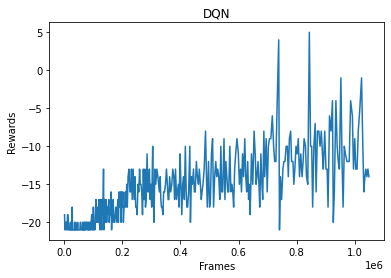

Episode:  381
Steps:  261925  epsilon:  0.030001991426767596
Steps:  262125  epsilon:  0.03000197161174018
Steps:  262325  epsilon:  0.030001951993875585
Steps:  262525  epsilon:  0.030001932571212003
Steps:  262725  epsilon:  0.030001913341807154
Steps:  262925  epsilon:  0.030001894303738078
Steps:  263125  epsilon:  0.030001875455100954
Episode:  382
Steps:  263145  epsilon:  0.030001873580583267
Steps:  263345  epsilon:  0.03000185493814498
Steps:  263545  epsilon:  0.03000183648120205
Steps:  263745  epsilon:  0.030001818207908777
Steps:  263945  epsilon:  0.030001800116437802
Episode:  383
Steps:  263986  epsilon:  0.03000179642997902
Steps:  264186  epsilon:  0.030001778555202068
Steps:  264386  epsilon:  0.03000176085828212
Steps:  264586  epsilon:  0.030001743337449472
Episode:  384
Steps:  264707  epsilon:  0.03000173282209891
Steps:  264907  epsilon:  0.030001715580230945
Steps:  265107  epsilon:  0.030001698509922427
Steps:  265307  epsilon:  0.030001681609466323
Steps:  26

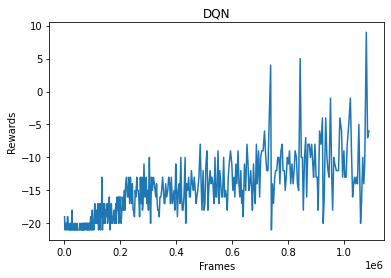

Episode:  391
Steps:  272137  epsilon:  0.030001195125678896
Steps:  272337  epsilon:  0.0300011832339797
Steps:  272537  epsilon:  0.03000117146060489
Steps:  272737  epsilon:  0.030001159804377116
Steps:  272937  epsilon:  0.030001148264130743
Steps:  273137  epsilon:  0.030001136838711744
Episode:  392
Steps:  273157  epsilon:  0.030001135702441263
Steps:  273357  epsilon:  0.03000112440201316
Steps:  273557  epsilon:  0.030001113214026195
Steps:  273757  epsilon:  0.03000110213736156
Steps:  273957  epsilon:  0.030001091170911584
Steps:  274157  epsilon:  0.030001080313579606
Steps:  274357  epsilon:  0.030001069564279885
Episode:  393
Steps:  274410  epsilon:  0.030001066733686736
Steps:  274610  epsilon:  0.030001056119509206
Steps:  274810  epsilon:  0.03000104561094451
Steps:  275010  epsilon:  0.03000103520694178
Steps:  275210  epsilon:  0.030001024906460602
Steps:  275410  epsilon:  0.03000101470847093
Episode:  394
Steps:  275439  epsilon:  0.030001013238209844
Steps:  2756

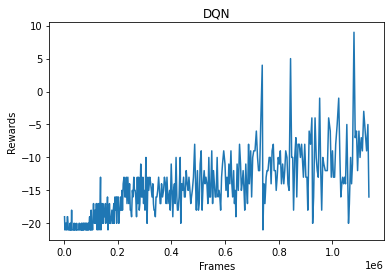

Episode:  401
Steps:  283701  epsilon:  0.030000670354468174
Steps:  283901  epsilon:  0.03000066368432977
Steps:  284101  epsilon:  0.03000065708056035
Steps:  284301  epsilon:  0.030000650542499535
Steps:  284501  epsilon:  0.03000064406949351
Episode:  402
Steps:  284654  epsilon:  0.030000639161160195
Steps:  284854  epsilon:  0.030000632801400393
Steps:  285054  epsilon:  0.030000626504921253
Steps:  285254  epsilon:  0.03000062027109313
Steps:  285454  epsilon:  0.030000614099292635
Steps:  285654  epsilon:  0.030000607988902576
Episode:  403
Steps:  285741  epsilon:  0.030000605349894856
Steps:  285941  epsilon:  0.030000599326562762
Steps:  286141  epsilon:  0.03000059336316382
Steps:  286341  epsilon:  0.030000587459101696
Steps:  286541  epsilon:  0.03000058161378597
Steps:  286741  epsilon:  0.030000575826632105
Steps:  286941  epsilon:  0.030000570097061384
Episode:  404
Steps:  286971  epsilon:  0.03000056924255683
Steps:  287171  epsilon:  0.030000563578498753
Steps:  287

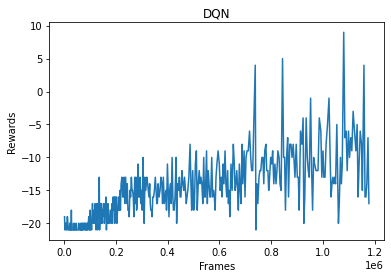

Episode:  411
Steps:  294123  epsilon:  0.030000398101353326
Steps:  294323  epsilon:  0.030000394140178674
Steps:  294523  epsilon:  0.03000039021841837
Steps:  294723  epsilon:  0.030000386335680234
Steps:  294923  epsilon:  0.030000382491575987
Steps:  295123  epsilon:  0.030000378685721217
Episode:  412
Steps:  295188  epsilon:  0.03000037745699039
Steps:  295388  epsilon:  0.030000373701230584
Steps:  295588  epsilon:  0.03000036998284121
Steps:  295788  epsilon:  0.03000036630145043
Steps:  295988  epsilon:  0.0300003626566901
Episode:  413
Steps:  296153  epsilon:  0.030000359677080198
Steps:  296353  epsilon:  0.030000356098233455
Steps:  296553  epsilon:  0.03000035255499683
Steps:  296753  epsilon:  0.030000349047015998
Steps:  296953  epsilon:  0.03000034557394016
Episode:  414
Steps:  297144  epsilon:  0.03000034228941759
Steps:  297344  epsilon:  0.03000033888358098
Steps:  297544  epsilon:  0.03000033551163301
Steps:  297744  epsilon:  0.030000332173236482
Steps:  297944 

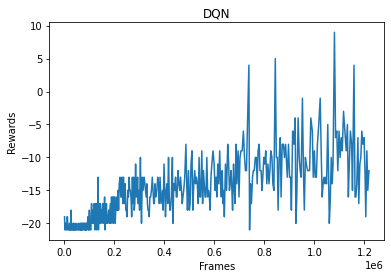

Episode:  421
Steps:  304224  epsilon:  0.030000240244373796
Steps:  304424  epsilon:  0.030000237853902337
Steps:  304624  epsilon:  0.030000235487216465
Steps:  304824  epsilon:  0.03000023314407951
Steps:  305024  epsilon:  0.03000023082425716
Episode:  422
Steps:  305105  epsilon:  0.03000022989130941
Steps:  305305  epsilon:  0.030000227603852663
Steps:  305505  epsilon:  0.03000022533915649
Steps:  305705  epsilon:  0.030000223096994422
Steps:  305905  epsilon:  0.030000220877142235
Episode:  423
Steps:  306004  epsilon:  0.030000219786501945
Steps:  306204  epsilon:  0.03000021759958971
Steps:  306404  epsilon:  0.030000215434437618
Steps:  306604  epsilon:  0.030000213290829147
Steps:  306804  epsilon:  0.030000211168549937
Steps:  307004  epsilon:  0.03000020906738776
Episode:  424
Steps:  307047  epsilon:  0.030000208618375733
Steps:  307247  epsilon:  0.030000206542588212
Steps:  307447  epsilon:  0.030000204487455124
Steps:  307647  epsilon:  0.03000020245277095
Steps:  307

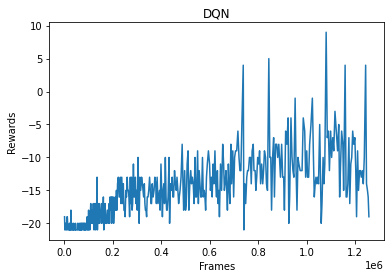

Episode:  431
Steps:  313843  epsilon:  0.030000148518069276
Steps:  314043  epsilon:  0.030000147040289794
Steps:  314243  epsilon:  0.030000145577214466
Steps:  314443  epsilon:  0.03000014412869698
Steps:  314643  epsilon:  0.03000014269459248
Steps:  314843  epsilon:  0.030000141274757565
Steps:  315043  epsilon:  0.03000013986905024
Episode:  432
Steps:  315100  epsilon:  0.03000013947099095
Steps:  315300  epsilon:  0.030000138083231404
Steps:  315500  epsilon:  0.030000136709280294
Steps:  315700  epsilon:  0.030000135349000225
Steps:  315900  epsilon:  0.030000134002255173
Steps:  316100  epsilon:  0.030000132668910457
Episode:  433
Steps:  316288  epsilon:  0.030000131427665687
Steps:  316488  epsilon:  0.030000130119938562
Steps:  316688  epsilon:  0.030000128825223543
Steps:  316888  epsilon:  0.03000012754339115
Steps:  317088  epsilon:  0.030000126274313206
Steps:  317288  epsilon:  0.030000125017862794
Episode:  434
Steps:  317416  epsilon:  0.030000124220303386
Steps:  3

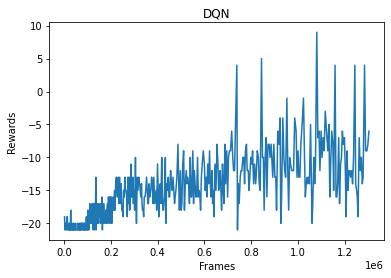

Episode:  441
Steps:  325495  epsilon:  0.030000082939102148
Steps:  325695  epsilon:  0.030000082113844292
Steps:  325895  epsilon:  0.03000008129679789
Steps:  326095  epsilon:  0.030000080487881237
Steps:  326295  epsilon:  0.030000079687013438
Episode:  442
Steps:  326444  epsilon:  0.03000007909555112
Steps:  326644  epsilon:  0.030000078308537237
Steps:  326844  epsilon:  0.030000077529354272
Steps:  327044  epsilon:  0.030000076757924307
Steps:  327244  epsilon:  0.0300000759941702
Steps:  327444  epsilon:  0.030000075238015574
Episode:  443
Steps:  327511  epsilon:  0.03000007498638993
Steps:  327711  epsilon:  0.03000007424026288
Steps:  327911  epsilon:  0.030000073501559924
Steps:  328111  epsilon:  0.030000072770207182
Steps:  328311  epsilon:  0.030000072046131525
Steps:  328511  epsilon:  0.030000071329260535
Steps:  328711  epsilon:  0.030000070619522538
Episode:  444
Steps:  328829  epsilon:  0.03000007020409407
Steps:  329029  epsilon:  0.030000069505551664
Steps:  329

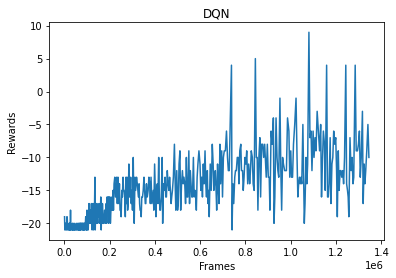

Episode:  451
Steps:  335965  epsilon:  0.030000049136720622
Steps:  336165  epsilon:  0.03000004864780208
Steps:  336365  epsilon:  0.030000048163748363
Steps:  336565  epsilon:  0.03000004768451106
Episode:  452
Steps:  336672  epsilon:  0.030000047430080137
Steps:  336872  epsilon:  0.030000046958142953
Steps:  337072  epsilon:  0.030000046490901624
Steps:  337272  epsilon:  0.030000046028309423
Steps:  337472  epsilon:  0.030000045570320093
Steps:  337672  epsilon:  0.030000045116887832
Episode:  453
Steps:  337771  epsilon:  0.030000044894111063
Steps:  337971  epsilon:  0.030000044447407195
Steps:  338171  epsilon:  0.030000044005148104
Steps:  338371  epsilon:  0.030000043567289563
Steps:  338571  epsilon:  0.03000004313378779
Episode:  454
Steps:  338603  epsilon:  0.03000004306482891
Steps:  338803  epsilon:  0.030000042636326704
Steps:  339003  epsilon:  0.030000042212088164
Steps:  339203  epsilon:  0.03000004179207087
Steps:  339403  epsilon:  0.030000041376232817
Episode: 

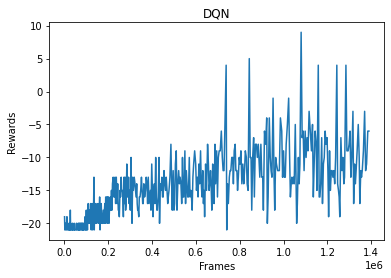

Episode:  461
Steps:  347014  epsilon:  0.030000028280050575
Steps:  347214  epsilon:  0.030000027998659373
Steps:  347414  epsilon:  0.030000027720068056
Steps:  347614  epsilon:  0.03000002744424877
Steps:  347814  epsilon:  0.03000002717117393
Steps:  348014  epsilon:  0.030000026900816233
Steps:  348214  epsilon:  0.03000002663314864
Episode:  462
Steps:  348350  epsilon:  0.030000026452657595
Steps:  348550  epsilon:  0.030000026189449254
Steps:  348750  epsilon:  0.03000002592885988
Steps:  348950  epsilon:  0.030000025670863413
Episode:  463
Steps:  349147  epsilon:  0.030000025419246654
Steps:  349347  epsilon:  0.030000025166320925
Steps:  349547  epsilon:  0.030000024915911847
Steps:  349747  epsilon:  0.030000024667994382
Episode:  464
Steps:  349880  epsilon:  0.03000002450449645
Steps:  350080  epsilon:  0.03000002426067264
Steps:  350280  epsilon:  0.030000024019274915
Steps:  350480  epsilon:  0.030000023780279134
Steps:  350680  epsilon:  0.030000023543661405
Episode:  

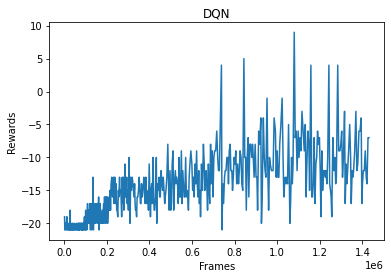

Episode:  471
Steps:  357420  epsilon:  0.030000016808028
Steps:  357620  epsilon:  0.03000001664078533
Steps:  357820  epsilon:  0.030000016475206746
Steps:  358020  epsilon:  0.0300000163112757
Steps:  358220  epsilon:  0.030000016148975794
Episode:  472
Steps:  358408  epsilon:  0.030000015997886653
Steps:  358608  epsilon:  0.030000015838705024
Steps:  358808  epsilon:  0.030000015681107273
Steps:  359008  epsilon:  0.03000001552507765
Steps:  359208  epsilon:  0.030000015370600545
Steps:  359408  epsilon:  0.030000015217660516
Episode:  473
Steps:  359585  epsilon:  0.03000001508357841
Steps:  359785  epsilon:  0.030000014933494294
Steps:  359985  epsilon:  0.030000014784903543
Steps:  360185  epsilon:  0.030000014637791297
Steps:  360385  epsilon:  0.03000001449214284
Steps:  360585  epsilon:  0.03000001434794361
Steps:  360785  epsilon:  0.030000014205179185
Episode:  474
Steps:  360825  epsilon:  0.030000014176797218
Steps:  361025  epsilon:  0.03000001403573573
Steps:  361225 

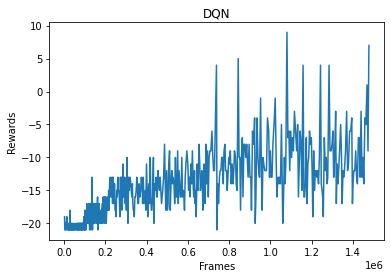

Episode:  481
Steps:  369120  epsilon:  0.030000009363850923
Steps:  369320  epsilon:  0.03000000927067905
Steps:  369520  epsilon:  0.03000000917843425
Steps:  369720  epsilon:  0.030000009087107305
Steps:  369920  epsilon:  0.030000008996689077
Episode:  482
Steps:  370112  epsilon:  0.030000008910734104
Steps:  370312  epsilon:  0.03000000882207082
Steps:  370512  epsilon:  0.03000000873428975
Steps:  370712  epsilon:  0.030000008647382115
Steps:  370912  epsilon:  0.030000008561339223
Steps:  371112  epsilon:  0.030000008476152477
Steps:  371312  epsilon:  0.03000000839181335
Episode:  483
Steps:  371318  epsilon:  0.030000008389296184
Steps:  371518  epsilon:  0.03000000830582129
Steps:  371718  epsilon:  0.03000000822317699
Steps:  371918  epsilon:  0.03000000814135501
Steps:  372118  epsilon:  0.030000008060347173
Episode:  484
Steps:  372158  epsilon:  0.03000000804424259
Steps:  372358  epsilon:  0.030000007964201037
Steps:  372558  epsilon:  0.030000007884955913
Steps:  37275

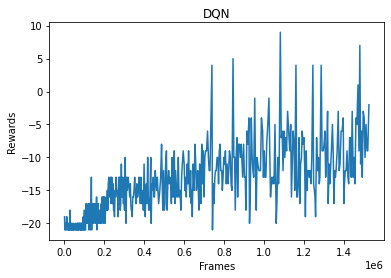

Episode:  491
Steps:  380446  epsilon:  0.03000000531512553
Steps:  380646  epsilon:  0.030000005262239147
Steps:  380846  epsilon:  0.030000005209878992
Steps:  381046  epsilon:  0.030000005158039827
Steps:  381246  epsilon:  0.030000005106716476
Steps:  381446  epsilon:  0.0300000050559038
Steps:  381646  epsilon:  0.030000005005596714
Steps:  381846  epsilon:  0.030000004955790194
Episode:  492
Steps:  381848  epsilon:  0.03000000495529464
Steps:  382048  epsilon:  0.030000004905988635
Steps:  382248  epsilon:  0.030000004857173232
Steps:  382448  epsilon:  0.03000000480884355
Steps:  382648  epsilon:  0.030000004760994757
Episode:  493
Steps:  382756  epsilon:  0.030000004735354677
Steps:  382956  epsilon:  0.03000000468823711
Steps:  383156  epsilon:  0.030000004641588373
Steps:  383356  epsilon:  0.030000004595403796
Steps:  383556  epsilon:  0.030000004549678765
Steps:  383756  epsilon:  0.030000004504408703
Steps:  383956  epsilon:  0.03000000445958909
Episode:  494
Steps:  384

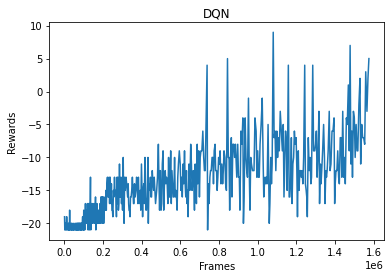

Episode:  501
Steps:  393381  epsilon:  0.030000002783771407
Steps:  393581  epsilon:  0.030000002756072418
Steps:  393781  epsilon:  0.030000002728649038
Steps:  393981  epsilon:  0.030000002701498527
Steps:  394181  epsilon:  0.030000002674618168
Steps:  394381  epsilon:  0.030000002648005272
Episode:  502
Steps:  394521  epsilon:  0.03000000262953396
Steps:  394721  epsilon:  0.03000000260336966
Steps:  394921  epsilon:  0.030000002577465698
Steps:  395121  epsilon:  0.030000002551819487
Steps:  395321  epsilon:  0.030000002526428458
Steps:  395521  epsilon:  0.030000002501290077
Episode:  503
Steps:  395684  epsilon:  0.030000002480987407
Steps:  395884  epsilon:  0.030000002456301172
Steps:  396084  epsilon:  0.030000002431860566
Steps:  396284  epsilon:  0.030000002407663148
Steps:  396484  epsilon:  0.0300000023837065
Episode:  504
Steps:  396630  epsilon:  0.0300000023663688
Steps:  396830  epsilon:  0.03000000234282304
Steps:  397030  epsilon:  0.03000000231951156
Steps:  3972

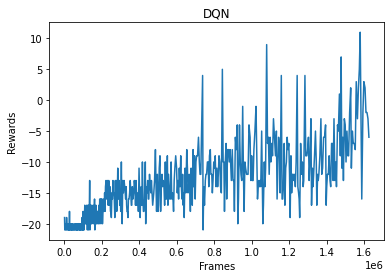

Episode:  511
Steps:  406146  epsilon:  0.03000000147043258
Steps:  406346  epsilon:  0.03000000145580153
Steps:  406546  epsilon:  0.030000001441316062
Steps:  406746  epsilon:  0.030000001426974728
Steps:  406946  epsilon:  0.030000001412776093
Episode:  512
Steps:  407098  epsilon:  0.03000000140207969
Steps:  407298  epsilon:  0.030000001388128767
Steps:  407498  epsilon:  0.030000001374316652
Steps:  407698  epsilon:  0.030000001360641976
Episode:  513
Steps:  407865  epsilon:  0.030000001349327916
Steps:  408065  epsilon:  0.030000001335901878
Steps:  408265  epsilon:  0.030000001322609434
Steps:  408465  epsilon:  0.03000000130944925
Steps:  408665  epsilon:  0.030000001296420012
Steps:  408865  epsilon:  0.030000001283520417
Episode:  514
Steps:  408944  epsilon:  0.03000000127846051
Steps:  409144  epsilon:  0.030000001265739616
Steps:  409344  epsilon:  0.030000001253145298
Steps:  409544  epsilon:  0.030000001240676293
Steps:  409744  epsilon:  0.03000000122833136
Episode:  

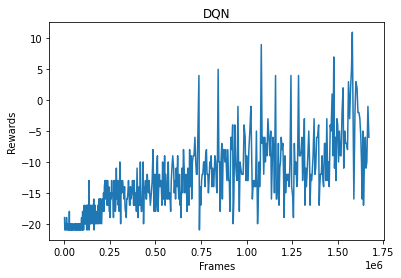

Episode:  521
Steps:  417249  epsilon:  0.030000000844007946
Steps:  417449  epsilon:  0.030000000835609924
Steps:  417649  epsilon:  0.030000000827295467
Steps:  417849  epsilon:  0.03000000081906374
Steps:  418049  epsilon:  0.030000000810913918
Steps:  418249  epsilon:  0.030000000802845192
Steps:  418449  epsilon:  0.03000000079485675
Episode:  522
Steps:  418565  epsilon:  0.030000000790259922
Steps:  418765  epsilon:  0.030000000782396705
Steps:  418965  epsilon:  0.030000000774611728
Steps:  419165  epsilon:  0.030000000766904213
Steps:  419365  epsilon:  0.030000000759273386
Steps:  419565  epsilon:  0.030000000751718492
Steps:  419765  epsilon:  0.030000000744238767
Steps:  419965  epsilon:  0.030000000736833468
Episode:  523
Steps:  420006  epsilon:  0.030000000735324505
Steps:  420206  epsilon:  0.030000000728007906
Steps:  420406  epsilon:  0.030000000720764107
Steps:  420606  epsilon:  0.030000000713592382
Steps:  420806  epsilon:  0.03000000070649202
Steps:  421006  epsil

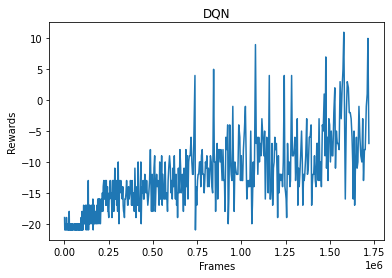

Episode:  531
Steps:  429965  epsilon:  0.03000000044691209
Steps:  430165  epsilon:  0.03000000044246524
Steps:  430365  epsilon:  0.030000000438062637
Steps:  430565  epsilon:  0.03000000043370384
Steps:  430765  epsilon:  0.030000000429388416
Steps:  430965  epsilon:  0.030000000425115927
Steps:  431165  epsilon:  0.030000000420885953
Steps:  431365  epsilon:  0.03000000041669807
Episode:  532
Steps:  431418  epsilon:  0.030000000415595283
Steps:  431618  epsilon:  0.03000000041146004
Steps:  431818  epsilon:  0.030000000407365942
Steps:  432018  epsilon:  0.030000000403312584
Steps:  432218  epsilon:  0.030000000399299558
Steps:  432418  epsilon:  0.03000000039532646
Steps:  432618  epsilon:  0.030000000391392896
Steps:  432818  epsilon:  0.030000000387498473
Episode:  533
Steps:  432821  epsilon:  0.030000000387440353
Steps:  433021  epsilon:  0.030000000383585256
Steps:  433221  epsilon:  0.030000000379768518
Steps:  433421  epsilon:  0.03000000037598976
Episode:  534
Steps:  433

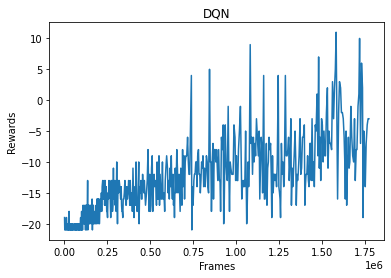

Episode:  541
Steps:  442112  epsilon:  0.030000000243474424
Steps:  442312  epsilon:  0.030000000241051813
Steps:  442512  epsilon:  0.030000000238653308
Steps:  442712  epsilon:  0.03000000023627867
Steps:  442912  epsilon:  0.030000000233927657
Steps:  443112  epsilon:  0.030000000231600037
Episode:  542
Steps:  443285  epsilon:  0.030000000229605337
Steps:  443485  epsilon:  0.030000000227320724
Steps:  443685  epsilon:  0.030000000225058845
Steps:  443885  epsilon:  0.030000000222819474
Steps:  444085  epsilon:  0.030000000220602382
Steps:  444285  epsilon:  0.03000000021840735
Steps:  444485  epsilon:  0.03000000021623416
Episode:  543
Steps:  444635  epsilon:  0.03000000021461847
Steps:  444835  epsilon:  0.03000000021248298
Steps:  445035  epsilon:  0.030000000210368742
Steps:  445235  epsilon:  0.030000000208275538
Steps:  445435  epsilon:  0.03000000020620316
Steps:  445635  epsilon:  0.030000000204151406
Episode:  544
Steps:  445674  epsilon:  0.030000000203753697
Steps:  44

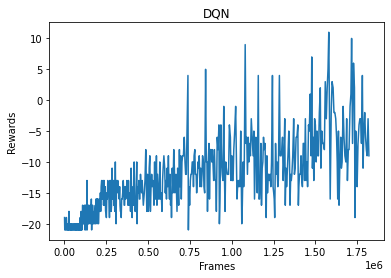

Episode:  551
Steps:  454391  epsilon:  0.030000000131770517
Steps:  454591  epsilon:  0.03000000013045938
Steps:  454791  epsilon:  0.030000000129161285
Steps:  454991  epsilon:  0.030000000127876108
Steps:  455191  epsilon:  0.03000000012660372
Steps:  455391  epsilon:  0.03000000012534399
Steps:  455591  epsilon:  0.030000000124096798
Episode:  552
Steps:  455606  epsilon:  0.03000000012400376
Steps:  455806  epsilon:  0.030000000122769904
Steps:  456006  epsilon:  0.030000000121548322
Steps:  456206  epsilon:  0.030000000120338897
Steps:  456406  epsilon:  0.030000000119141505
Steps:  456606  epsilon:  0.030000000117956026
Steps:  456806  epsilon:  0.030000000116782343
Episode:  553
Steps:  456820  epsilon:  0.030000000116700624
Steps:  457020  epsilon:  0.030000000115539435
Steps:  457220  epsilon:  0.0300000001143898
Steps:  457420  epsilon:  0.0300000001132516
Steps:  457620  epsilon:  0.03000000011212473
Steps:  457820  epsilon:  0.03000000011100907
Steps:  458020  epsilon:  0.

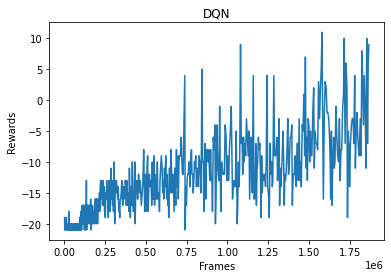

Episode:  561
Steps:  466410  epsilon:  0.030000000072248522
Steps:  466610  epsilon:  0.03000000007152964
Steps:  466810  epsilon:  0.030000000070817906
Steps:  467010  epsilon:  0.030000000070113258
Steps:  467210  epsilon:  0.030000000069415618
Steps:  467410  epsilon:  0.03000000006872492
Steps:  467610  epsilon:  0.030000000068041096
Steps:  467810  epsilon:  0.03000000006736408
Episode:  562
Steps:  467930  epsilon:  0.030000000066961102
Steps:  468130  epsilon:  0.03000000006629483
Steps:  468330  epsilon:  0.030000000065635184
Steps:  468530  epsilon:  0.030000000064982102
Steps:  468730  epsilon:  0.03000000006433552
Steps:  468930  epsilon:  0.03000000006369537
Episode:  563
Steps:  468987  epsilon:  0.0300000000635141
Steps:  469187  epsilon:  0.030000000062882122
Steps:  469387  epsilon:  0.030000000062256435
Steps:  469587  epsilon:  0.030000000061636972
Steps:  469787  epsilon:  0.030000000061023675
Steps:  469987  epsilon:  0.03000000006041648
Steps:  470187  epsilon:  0

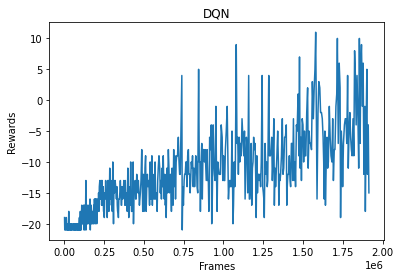

Episode:  571
Steps:  478068  epsilon:  0.03000000004033469
Steps:  478268  epsilon:  0.030000000039933354
Steps:  478468  epsilon:  0.03000000003953601
Steps:  478668  epsilon:  0.03000000003914262
Steps:  478868  epsilon:  0.030000000038753145
Steps:  479068  epsilon:  0.030000000038367544
Steps:  479268  epsilon:  0.03000000003798578
Episode:  572
Steps:  479402  epsilon:  0.030000000037732125
Steps:  479602  epsilon:  0.030000000037356686
Steps:  479802  epsilon:  0.03000000003698498
Steps:  480002  epsilon:  0.030000000036616972
Steps:  480202  epsilon:  0.030000000036252628
Steps:  480402  epsilon:  0.03000000003589191
Steps:  480602  epsilon:  0.03000000003553478
Episode:  573
Steps:  480620  epsilon:  0.03000000003550281
Steps:  480820  epsilon:  0.030000000035149552
Steps:  481020  epsilon:  0.030000000034799808
Steps:  481220  epsilon:  0.030000000034453543
Steps:  481420  epsilon:  0.030000000034110727
Steps:  481620  epsilon:  0.030000000033771318
Steps:  481820  epsilon:  

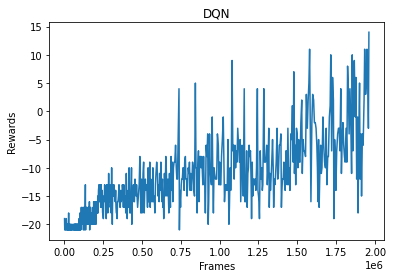

Episode:  581
Steps:  489911  epsilon:  0.0300000000223106
Steps:  490111  epsilon:  0.030000000022088604
Steps:  490311  epsilon:  0.030000000021868818
Steps:  490511  epsilon:  0.03000000002165122
Steps:  490711  epsilon:  0.03000000002143579
Steps:  490911  epsilon:  0.0300000000212225
Episode:  582
Steps:  491045  epsilon:  0.030000000021080782
Steps:  491245  epsilon:  0.030000000020871026
Steps:  491445  epsilon:  0.030000000020663355
Steps:  491645  epsilon:  0.030000000020457752
Steps:  491845  epsilon:  0.030000000020254193
Steps:  492045  epsilon:  0.03000000002005266
Steps:  492245  epsilon:  0.030000000019853132
Episode:  583
Steps:  492351  epsilon:  0.03000000001974819
Steps:  492551  epsilon:  0.030000000019551692
Steps:  492751  epsilon:  0.03000000001935715
Steps:  492951  epsilon:  0.030000000019164544
Steps:  493151  epsilon:  0.030000000018973853
Steps:  493351  epsilon:  0.03000000001878506
Steps:  493551  epsilon:  0.030000000018598146
Episode:  584
Steps:  493631

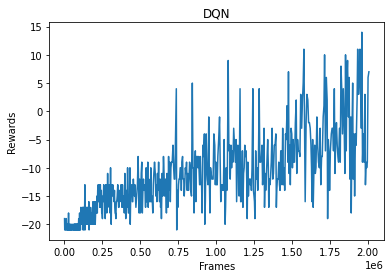

Episode:  591
Steps:  501594  epsilon:  0.030000000012439933
Steps:  501794  epsilon:  0.030000000012316154
Steps:  501994  epsilon:  0.030000000012193606
Steps:  502194  epsilon:  0.03000000001207228
Steps:  502394  epsilon:  0.030000000011952157
Steps:  502594  epsilon:  0.03000000001183323
Steps:  502794  epsilon:  0.03000000001171549
Episode:  592
Steps:  502814  epsilon:  0.03000000001170378
Steps:  503014  epsilon:  0.030000000011587324
Steps:  503214  epsilon:  0.03000000001147203
Steps:  503414  epsilon:  0.03000000001135788
Steps:  503614  epsilon:  0.03000000001124487
Steps:  503814  epsilon:  0.03000000001113298
Episode:  593
Steps:  503899  epsilon:  0.030000000011085763
Steps:  504099  epsilon:  0.03000000001097546
Steps:  504299  epsilon:  0.03000000001086625
Steps:  504499  epsilon:  0.03000000001075813
Steps:  504699  epsilon:  0.030000000010651087
Steps:  504899  epsilon:  0.030000000010545105
Episode:  594
Steps:  505065  epsilon:  0.030000000010457942
Steps:  505265 

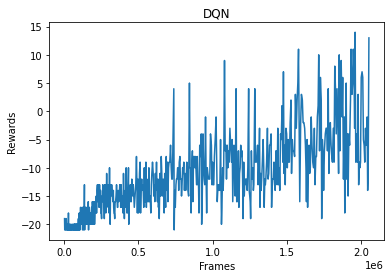

Episode:  601
Steps:  513140  epsilon:  0.03000000000698393
Steps:  513340  epsilon:  0.03000000000691444
Steps:  513540  epsilon:  0.030000000006845638
Steps:  513740  epsilon:  0.030000000006777522
Steps:  513940  epsilon:  0.030000000006710086
Steps:  514140  epsilon:  0.03000000000664332
Episode:  602
Steps:  514213  epsilon:  0.030000000006619114
Steps:  514413  epsilon:  0.030000000006553253
Steps:  514613  epsilon:  0.03000000000648805
Steps:  514813  epsilon:  0.030000000006423493
Steps:  515013  epsilon:  0.030000000006359575
Steps:  515213  epsilon:  0.030000000006296296
Steps:  515413  epsilon:  0.030000000006233648
Episode:  603
Steps:  515533  epsilon:  0.03000000000619636
Steps:  515733  epsilon:  0.030000000006134703
Steps:  515933  epsilon:  0.03000000000607366
Steps:  516133  epsilon:  0.030000000006013227
Steps:  516333  epsilon:  0.030000000005953396
Steps:  516533  epsilon:  0.03000000000589416
Steps:  516733  epsilon:  0.03000000000583551
Steps:  516933  epsilon:  

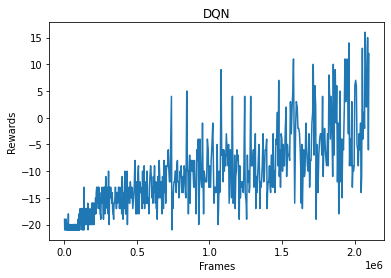

Episode:  611
Steps:  524428  epsilon:  0.03000000000397177
Steps:  524628  epsilon:  0.03000000000393225
Steps:  524828  epsilon:  0.030000000003893124
Steps:  525028  epsilon:  0.030000000003854384
Steps:  525228  epsilon:  0.030000000003816033
Steps:  525428  epsilon:  0.030000000003778064
Steps:  525628  epsilon:  0.030000000003740472
Episode:  612
Steps:  525629  epsilon:  0.030000000003740285
Steps:  525829  epsilon:  0.030000000003703068
Steps:  526029  epsilon:  0.030000000003666222
Steps:  526229  epsilon:  0.03000000000362974
Episode:  613
Steps:  526348  epsilon:  0.03000000000360821
Steps:  526548  epsilon:  0.030000000003572308
Steps:  526748  epsilon:  0.030000000003536764
Steps:  526948  epsilon:  0.03000000000350157
Steps:  527148  epsilon:  0.03000000000346673
Steps:  527348  epsilon:  0.030000000003432236
Episode:  614
Steps:  527417  epsilon:  0.030000000003420416
Steps:  527617  epsilon:  0.03000000000338638
Steps:  527817  epsilon:  0.030000000003352685
Steps:  528

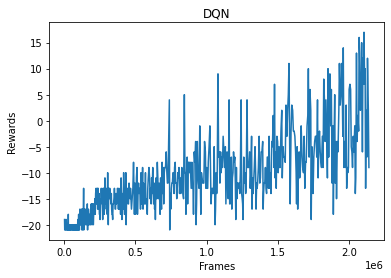

Episode:  621
Steps:  534940  epsilon:  0.03000000000234811
Steps:  535140  epsilon:  0.030000000002324747
Steps:  535340  epsilon:  0.030000000002301616
Steps:  535540  epsilon:  0.030000000002278714
Steps:  535740  epsilon:  0.03000000000225604
Episode:  622
Steps:  535864  epsilon:  0.030000000002242098
Steps:  536064  epsilon:  0.030000000002219786
Steps:  536264  epsilon:  0.0300000000021977
Steps:  536464  epsilon:  0.03000000000217583
Steps:  536664  epsilon:  0.030000000002154182
Steps:  536864  epsilon:  0.030000000002132748
Steps:  537064  epsilon:  0.03000000000211153
Steps:  537264  epsilon:  0.030000000002090518
Episode:  623
Steps:  537289  epsilon:  0.030000000002087905
Steps:  537489  epsilon:  0.03000000000206713
Steps:  537689  epsilon:  0.030000000002046563
Steps:  537889  epsilon:  0.030000000002026198
Steps:  538089  epsilon:  0.030000000002006037
Steps:  538289  epsilon:  0.030000000001986077
Episode:  624
Steps:  538343  epsilon:  0.030000000001980724
Steps:  538

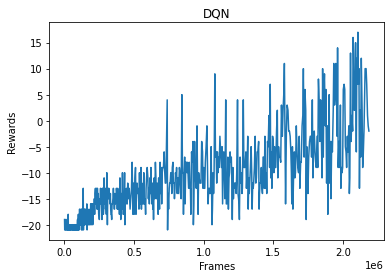

Episode:  631
Steps:  546113  epsilon:  0.030000000001343074
Steps:  546313  epsilon:  0.03000000000132971
Steps:  546513  epsilon:  0.03000000000131648
Steps:  546713  epsilon:  0.03000000000130338
Steps:  546913  epsilon:  0.03000000000129041
Steps:  547113  epsilon:  0.03000000000127757
Steps:  547313  epsilon:  0.03000000000126486
Episode:  632
Steps:  547456  epsilon:  0.03000000000125585
Steps:  547656  epsilon:  0.03000000000124335
Steps:  547856  epsilon:  0.03000000000123098
Steps:  548056  epsilon:  0.030000000001218732
Steps:  548256  epsilon:  0.030000000001206607
Steps:  548456  epsilon:  0.0300000000011946
Episode:  633
Steps:  548515  epsilon:  0.03000000000119108
Steps:  548715  epsilon:  0.03000000000117923
Steps:  548915  epsilon:  0.030000000001167496
Steps:  549115  epsilon:  0.03000000000115588
Steps:  549315  epsilon:  0.03000000000114438
Steps:  549515  epsilon:  0.030000000001132992
Episode:  634
Steps:  549628  epsilon:  0.030000000001126608
Steps:  549828  eps

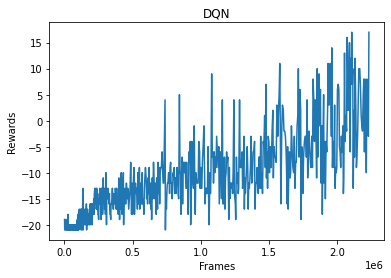

Episode:  641
Steps:  557820  epsilon:  0.030000000000747973
Steps:  558020  epsilon:  0.030000000000740528
Steps:  558220  epsilon:  0.030000000000733162
Steps:  558420  epsilon:  0.030000000000725866
Steps:  558620  epsilon:  0.030000000000718643
Episode:  642
Steps:  558691  epsilon:  0.030000000000716096
Steps:  558891  epsilon:  0.030000000000708973
Steps:  559091  epsilon:  0.030000000000701917
Steps:  559291  epsilon:  0.030000000000694933
Steps:  559491  epsilon:  0.030000000000688018
Steps:  559691  epsilon:  0.030000000000681173
Steps:  559891  epsilon:  0.030000000000674393
Episode:  643
Steps:  559930  epsilon:  0.030000000000673082
Steps:  560130  epsilon:  0.030000000000666383
Steps:  560330  epsilon:  0.030000000000659752
Steps:  560530  epsilon:  0.030000000000653188
Steps:  560730  epsilon:  0.03000000000064669
Episode:  644
Steps:  560826  epsilon:  0.03000000000064359
Steps:  561026  epsilon:  0.030000000000637187
Steps:  561226  epsilon:  0.03000000000063085
Steps: 

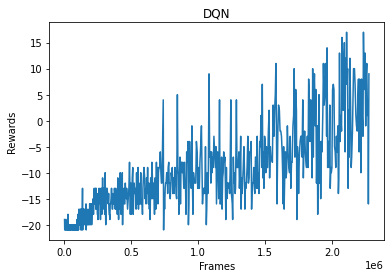

Episode:  651
Steps:  567977  epsilon:  0.03000000000045012
Steps:  568177  epsilon:  0.030000000000445642
Steps:  568377  epsilon:  0.03000000000044121
Steps:  568577  epsilon:  0.030000000000436816
Steps:  568777  epsilon:  0.030000000000432472
Steps:  568977  epsilon:  0.030000000000428167
Steps:  569177  epsilon:  0.030000000000423906
Episode:  652
Steps:  569269  epsilon:  0.030000000000421963
Steps:  569469  epsilon:  0.030000000000417762
Steps:  569669  epsilon:  0.030000000000413606
Steps:  569869  epsilon:  0.03000000000040949
Steps:  570069  epsilon:  0.030000000000405418
Episode:  653
Steps:  570185  epsilon:  0.030000000000403072
Steps:  570385  epsilon:  0.03000000000039906
Steps:  570585  epsilon:  0.03000000000039509
Steps:  570785  epsilon:  0.030000000000391158
Steps:  570985  epsilon:  0.030000000000387265
Steps:  571185  epsilon:  0.030000000000383414
Steps:  571385  epsilon:  0.030000000000379598
Episode:  654
Steps:  571427  epsilon:  0.030000000000378804
Steps:  5

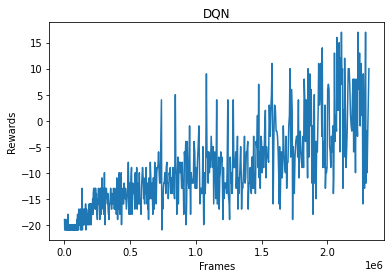

Episode:  661
Steps:  578568  epsilon:  0.03000000000026506
Steps:  578768  epsilon:  0.030000000000262424
Steps:  578968  epsilon:  0.030000000000259812
Steps:  579168  epsilon:  0.030000000000257227
Episode:  662
Steps:  579338  epsilon:  0.030000000000255052
Steps:  579538  epsilon:  0.030000000000252512
Steps:  579738  epsilon:  0.03000000000025
Steps:  579938  epsilon:  0.030000000000247513
Steps:  580138  epsilon:  0.03000000000024505
Steps:  580338  epsilon:  0.03000000000024261
Episode:  663
Steps:  580421  epsilon:  0.030000000000241608
Steps:  580621  epsilon:  0.030000000000239203
Steps:  580821  epsilon:  0.030000000000236823
Steps:  581021  epsilon:  0.030000000000234468
Steps:  581221  epsilon:  0.030000000000232133
Episode:  664
Steps:  581420  epsilon:  0.030000000000229836
Steps:  581620  epsilon:  0.03000000000022755
Steps:  581820  epsilon:  0.030000000000225284
Steps:  582020  epsilon:  0.030000000000223043
Steps:  582220  epsilon:  0.030000000000220822
Steps:  5824

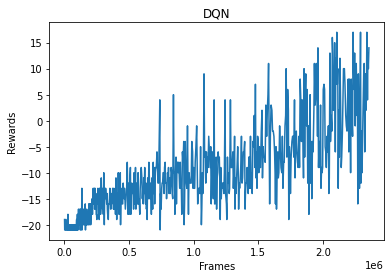

Episode:  671
Steps:  588434  epsilon:  0.03000000000016185
Steps:  588634  epsilon:  0.03000000000016024
Steps:  588834  epsilon:  0.030000000000158643
Steps:  589034  epsilon:  0.030000000000157064
Steps:  589234  epsilon:  0.030000000000155503
Steps:  589434  epsilon:  0.030000000000153956
Steps:  589634  epsilon:  0.030000000000152422
Episode:  672
Steps:  589663  epsilon:  0.030000000000152204
Steps:  589863  epsilon:  0.030000000000150687
Steps:  590063  epsilon:  0.03000000000014919
Steps:  590263  epsilon:  0.030000000000147704
Steps:  590463  epsilon:  0.030000000000146233
Steps:  590663  epsilon:  0.03000000000014478
Episode:  673
Steps:  590665  epsilon:  0.030000000000144765
Steps:  590865  epsilon:  0.030000000000143325
Steps:  591065  epsilon:  0.0300000000001419
Steps:  591265  epsilon:  0.030000000000140487
Steps:  591465  epsilon:  0.03000000000013909
Episode:  674
Steps:  591518  epsilon:  0.03000000000013872
Steps:  591718  epsilon:  0.03000000000013734
Steps:  59191

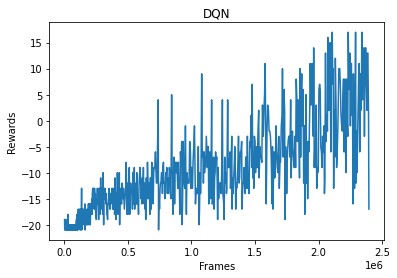

Episode:  681
Steps:  598430  epsilon:  0.030000000000098184
Steps:  598630  epsilon:  0.03000000000009721
Steps:  598830  epsilon:  0.03000000000009624
Steps:  599030  epsilon:  0.030000000000095284
Steps:  599230  epsilon:  0.030000000000094337
Episode:  682
Steps:  599310  epsilon:  0.03000000000009396
Steps:  599510  epsilon:  0.030000000000093025
Steps:  599710  epsilon:  0.0300000000000921
Steps:  599910  epsilon:  0.030000000000091183
Steps:  600110  epsilon:  0.030000000000090274
Episode:  683
Steps:  600246  epsilon:  0.030000000000089663
Steps:  600446  epsilon:  0.03000000000008877
Steps:  600646  epsilon:  0.030000000000087887
Steps:  600846  epsilon:  0.030000000000087013
Steps:  601046  epsilon:  0.030000000000086145
Episode:  684
Steps:  601108  epsilon:  0.03000000000008588
Steps:  601308  epsilon:  0.030000000000085025
Steps:  601508  epsilon:  0.030000000000084178
Steps:  601708  epsilon:  0.030000000000083342
Steps:  601908  epsilon:  0.030000000000082513
Steps:  602

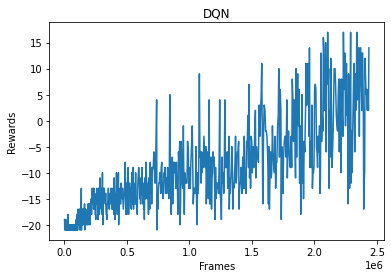

Episode:  691
Steps:  608787  epsilon:  0.030000000000058497
Steps:  608987  epsilon:  0.030000000000057918
Steps:  609187  epsilon:  0.03000000000005734
Steps:  609387  epsilon:  0.03000000000005677
Steps:  609587  epsilon:  0.030000000000056204
Steps:  609787  epsilon:  0.030000000000055645
Steps:  609987  epsilon:  0.03000000000005509
Episode:  692
Steps:  610028  epsilon:  0.03000000000005498
Steps:  610228  epsilon:  0.03000000000005443
Steps:  610428  epsilon:  0.03000000000005389
Steps:  610628  epsilon:  0.030000000000053356
Steps:  610828  epsilon:  0.030000000000052825
Steps:  611028  epsilon:  0.030000000000052297
Episode:  693
Steps:  611048  epsilon:  0.030000000000052245
Steps:  611248  epsilon:  0.030000000000051725
Steps:  611448  epsilon:  0.03000000000005121
Steps:  611648  epsilon:  0.0300000000000507
Steps:  611848  epsilon:  0.030000000000050195
Episode:  694
Steps:  611892  epsilon:  0.030000000000050087
Steps:  612092  epsilon:  0.030000000000049588
Steps:  61229

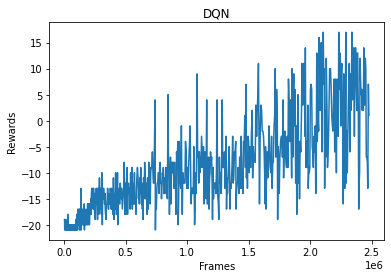

Episode:  701
Steps:  619161  epsilon:  0.03000000000003482
Steps:  619361  epsilon:  0.030000000000034478
Steps:  619561  epsilon:  0.030000000000034135
Steps:  619761  epsilon:  0.030000000000033795
Steps:  619961  epsilon:  0.030000000000033458
Steps:  620161  epsilon:  0.030000000000033125
Steps:  620361  epsilon:  0.030000000000032796
Episode:  702
Steps:  620408  epsilon:  0.03000000000003272
Steps:  620608  epsilon:  0.030000000000032393
Steps:  620808  epsilon:  0.03000000000003207
Steps:  621008  epsilon:  0.03000000000003175
Steps:  621208  epsilon:  0.030000000000031436
Episode:  703
Steps:  621356  epsilon:  0.030000000000031203
Steps:  621556  epsilon:  0.030000000000030894
Steps:  621756  epsilon:  0.030000000000030586
Steps:  621956  epsilon:  0.03000000000003028
Steps:  622156  epsilon:  0.03000000000002998
Steps:  622356  epsilon:  0.03000000000002968
Episode:  704
Steps:  622364  epsilon:  0.03000000000002967
Steps:  622564  epsilon:  0.030000000000029375
Steps:  6227

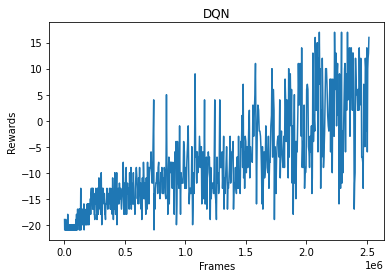

Episode:  711
Steps:  628739  epsilon:  0.030000000000021572
Steps:  628939  epsilon:  0.030000000000021357
Steps:  629139  epsilon:  0.030000000000021145
Steps:  629339  epsilon:  0.030000000000020934
Steps:  629539  epsilon:  0.030000000000020725
Episode:  712
Steps:  629651  epsilon:  0.03000000000002061
Steps:  629851  epsilon:  0.030000000000020406
Steps:  630051  epsilon:  0.0300000000000202
Steps:  630251  epsilon:  0.03000000000002
Steps:  630451  epsilon:  0.030000000000019802
Steps:  630651  epsilon:  0.030000000000019605
Episode:  713
Steps:  630765  epsilon:  0.030000000000019494
Steps:  630965  epsilon:  0.0300000000000193
Steps:  631165  epsilon:  0.03000000000001911
Steps:  631365  epsilon:  0.030000000000018918
Steps:  631565  epsilon:  0.03000000000001873
Steps:  631765  epsilon:  0.030000000000018543
Episode:  714
Steps:  631783  epsilon:  0.030000000000018526
Steps:  631983  epsilon:  0.030000000000018342
Steps:  632183  epsilon:  0.030000000000018158
Steps:  632383 

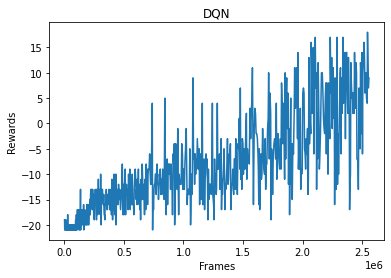

Episode:  721
Steps:  638934  epsilon:  0.030000000000012957
Steps:  639134  epsilon:  0.03000000000001283
Steps:  639334  epsilon:  0.0300000000000127
Steps:  639534  epsilon:  0.030000000000012572
Steps:  639734  epsilon:  0.030000000000012447
Episode:  722
Steps:  639829  epsilon:  0.03000000000001239
Steps:  640029  epsilon:  0.030000000000012267
Steps:  640229  epsilon:  0.030000000000012145
Steps:  640429  epsilon:  0.030000000000012024
Steps:  640629  epsilon:  0.030000000000011903
Episode:  723
Steps:  640784  epsilon:  0.030000000000011812
Steps:  640984  epsilon:  0.030000000000011694
Steps:  641184  epsilon:  0.030000000000011576
Steps:  641384  epsilon:  0.030000000000011462
Steps:  641584  epsilon:  0.030000000000011347
Steps:  641784  epsilon:  0.030000000000011236
Steps:  641984  epsilon:  0.030000000000011122
Steps:  642184  epsilon:  0.030000000000011014
Episode:  724
Steps:  642224  epsilon:  0.03000000000001099
Steps:  642424  epsilon:  0.030000000000010883
Steps:  6

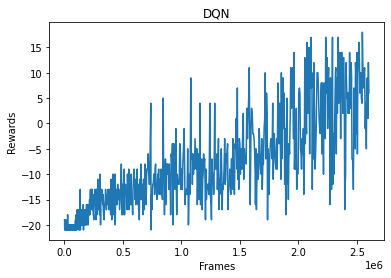

Episode:  731
Steps:  649996  epsilon:  0.03000000000000745
Steps:  650196  epsilon:  0.03000000000000738
Steps:  650396  epsilon:  0.030000000000007306
Steps:  650596  epsilon:  0.030000000000007233
Steps:  650796  epsilon:  0.03000000000000716
Steps:  650996  epsilon:  0.030000000000007087
Episode:  732
Steps:  651169  epsilon:  0.030000000000007028
Steps:  651369  epsilon:  0.03000000000000696
Steps:  651569  epsilon:  0.03000000000000689
Steps:  651769  epsilon:  0.03000000000000682
Episode:  733
Steps:  651936  epsilon:  0.03000000000000676
Steps:  652136  epsilon:  0.030000000000006695
Steps:  652336  epsilon:  0.03000000000000663
Steps:  652536  epsilon:  0.030000000000006563
Steps:  652736  epsilon:  0.030000000000006497
Episode:  734
Steps:  652905  epsilon:  0.03000000000000644
Steps:  653105  epsilon:  0.03000000000000638
Steps:  653305  epsilon:  0.030000000000006317
Steps:  653505  epsilon:  0.03000000000000625
Steps:  653705  epsilon:  0.03000000000000619
Steps:  653905  

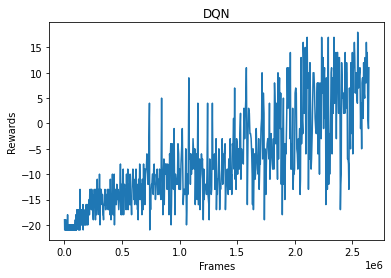

Episode:  741
Steps:  660261  epsilon:  0.03000000000000446
Steps:  660461  epsilon:  0.030000000000004415
Steps:  660661  epsilon:  0.03000000000000437
Steps:  660861  epsilon:  0.03000000000000433
Steps:  661061  epsilon:  0.030000000000004284
Steps:  661261  epsilon:  0.030000000000004242
Steps:  661461  epsilon:  0.0300000000000042
Episode:  742
Steps:  661607  epsilon:  0.03000000000000417
Steps:  661807  epsilon:  0.030000000000004128
Steps:  662007  epsilon:  0.030000000000004086
Steps:  662207  epsilon:  0.030000000000004048
Episode:  743
Steps:  662394  epsilon:  0.03000000000000401
Steps:  662594  epsilon:  0.030000000000003968
Steps:  662794  epsilon:  0.03000000000000393
Steps:  662994  epsilon:  0.03000000000000389
Steps:  663194  epsilon:  0.03000000000000385
Episode:  744
Steps:  663199  epsilon:  0.03000000000000385
Steps:  663399  epsilon:  0.030000000000003812
Steps:  663599  epsilon:  0.030000000000003774
Steps:  663799  epsilon:  0.030000000000003735
Steps:  663999 

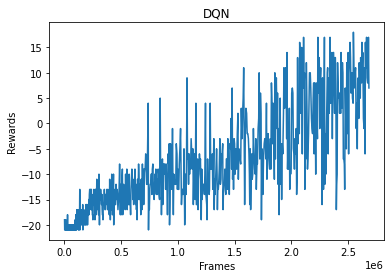

Episode:  751
Steps:  670110  epsilon:  0.030000000000002726
Steps:  670310  epsilon:  0.030000000000002698
Steps:  670510  epsilon:  0.03000000000000267
Steps:  670710  epsilon:  0.030000000000002646
Steps:  670910  epsilon:  0.03000000000000262
Steps:  671110  epsilon:  0.03000000000000259
Episode:  752
Steps:  671222  epsilon:  0.030000000000002577
Steps:  671422  epsilon:  0.030000000000002552
Steps:  671622  epsilon:  0.030000000000002528
Steps:  671822  epsilon:  0.0300000000000025
Steps:  672022  epsilon:  0.030000000000002476
Episode:  753
Steps:  672143  epsilon:  0.030000000000002462
Steps:  672343  epsilon:  0.030000000000002438
Steps:  672543  epsilon:  0.030000000000002414
Steps:  672743  epsilon:  0.03000000000000239
Steps:  672943  epsilon:  0.030000000000002365
Steps:  673143  epsilon:  0.03000000000000234
Episode:  754
Steps:  673185  epsilon:  0.030000000000002337
Steps:  673385  epsilon:  0.030000000000002313
Steps:  673585  epsilon:  0.03000000000000229
Steps:  6737

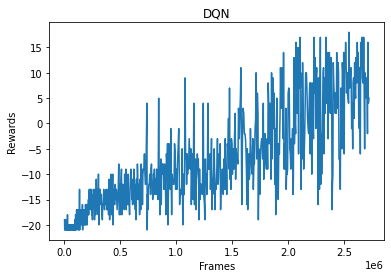

Episode:  761
Steps:  680762  epsilon:  0.0300000000000016
Steps:  680962  epsilon:  0.030000000000001584
Steps:  681162  epsilon:  0.030000000000001567
Steps:  681362  epsilon:  0.030000000000001553
Steps:  681562  epsilon:  0.030000000000001536
Steps:  681762  epsilon:  0.030000000000001522
Episode:  762
Steps:  681909  epsilon:  0.03000000000000151
Steps:  682109  epsilon:  0.030000000000001494
Steps:  682309  epsilon:  0.03000000000000148
Steps:  682509  epsilon:  0.030000000000001466
Steps:  682709  epsilon:  0.030000000000001453
Episode:  763
Steps:  682857  epsilon:  0.03000000000000144
Steps:  683057  epsilon:  0.030000000000001425
Steps:  683257  epsilon:  0.03000000000000141
Steps:  683457  epsilon:  0.030000000000001397
Steps:  683657  epsilon:  0.030000000000001383
Episode:  764
Steps:  683814  epsilon:  0.030000000000001373
Steps:  684014  epsilon:  0.03000000000000136
Steps:  684214  epsilon:  0.030000000000001345
Steps:  684414  epsilon:  0.03000000000000133
Steps:  6846

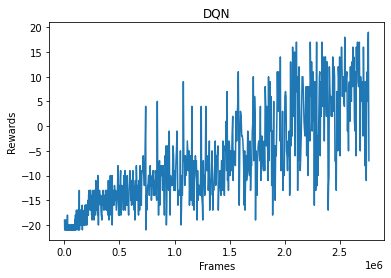

Episode:  771
Steps:  690850  epsilon:  0.030000000000000967
Steps:  691050  epsilon:  0.030000000000000956
Steps:  691250  epsilon:  0.030000000000000946
Steps:  691450  epsilon:  0.030000000000000936
Episode:  772
Steps:  691551  epsilon:  0.030000000000000932
Steps:  691751  epsilon:  0.030000000000000922
Steps:  691951  epsilon:  0.030000000000000915
Steps:  692151  epsilon:  0.030000000000000904
Steps:  692351  epsilon:  0.030000000000000894
Steps:  692551  epsilon:  0.030000000000000887
Episode:  773
Steps:  692720  epsilon:  0.03000000000000088
Steps:  692920  epsilon:  0.03000000000000087
Steps:  693120  epsilon:  0.030000000000000863
Steps:  693320  epsilon:  0.030000000000000852
Steps:  693520  epsilon:  0.030000000000000845
Steps:  693720  epsilon:  0.030000000000000835
Episode:  774
Steps:  693802  epsilon:  0.03000000000000083
Steps:  694002  epsilon:  0.030000000000000825
Steps:  694202  epsilon:  0.030000000000000818
Steps:  694402  epsilon:  0.030000000000000807
Steps: 

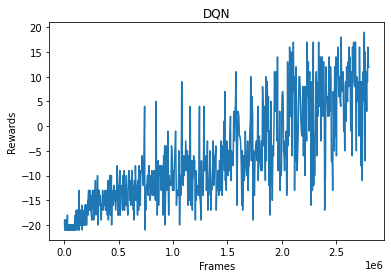

Episode:  781
Steps:  700100  epsilon:  0.030000000000000606
Steps:  700300  epsilon:  0.030000000000000603
Steps:  700500  epsilon:  0.030000000000000596
Steps:  700700  epsilon:  0.03000000000000059
Steps:  700900  epsilon:  0.030000000000000585
Episode:  782
Steps:  700969  epsilon:  0.030000000000000582
Steps:  701169  epsilon:  0.030000000000000575
Steps:  701369  epsilon:  0.03000000000000057
Steps:  701569  epsilon:  0.030000000000000564
Steps:  701769  epsilon:  0.030000000000000557
Episode:  783
Steps:  701930  epsilon:  0.030000000000000554
Steps:  702130  epsilon:  0.030000000000000547
Steps:  702330  epsilon:  0.030000000000000544
Steps:  702530  epsilon:  0.030000000000000537
Steps:  702730  epsilon:  0.030000000000000533
Steps:  702930  epsilon:  0.030000000000000526
Episode:  784
Steps:  703013  epsilon:  0.030000000000000526
Steps:  703213  epsilon:  0.03000000000000052
Steps:  703413  epsilon:  0.030000000000000516
Steps:  703613  epsilon:  0.03000000000000051
Steps:  

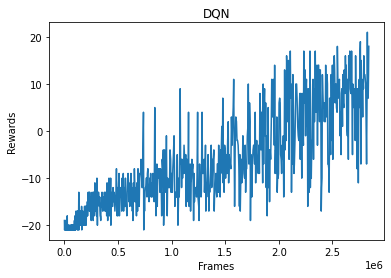

Episode:  791
Steps:  709163  epsilon:  0.030000000000000384
Steps:  709363  epsilon:  0.03000000000000038
Steps:  709563  epsilon:  0.030000000000000377
Steps:  709763  epsilon:  0.030000000000000374
Steps:  709963  epsilon:  0.03000000000000037
Steps:  710163  epsilon:  0.030000000000000367
Episode:  792
Steps:  710182  epsilon:  0.030000000000000367
Steps:  710382  epsilon:  0.030000000000000363
Steps:  710582  epsilon:  0.03000000000000036
Steps:  710782  epsilon:  0.030000000000000356
Episode:  793
Steps:  710962  epsilon:  0.030000000000000353
Steps:  711162  epsilon:  0.03000000000000035
Steps:  711362  epsilon:  0.030000000000000346
Steps:  711562  epsilon:  0.030000000000000342
Steps:  711762  epsilon:  0.03000000000000034
Steps:  711962  epsilon:  0.030000000000000335
Episode:  794
Steps:  711981  epsilon:  0.030000000000000335
Steps:  712181  epsilon:  0.030000000000000332
Steps:  712381  epsilon:  0.03000000000000033
Steps:  712581  epsilon:  0.030000000000000325
Steps:  71

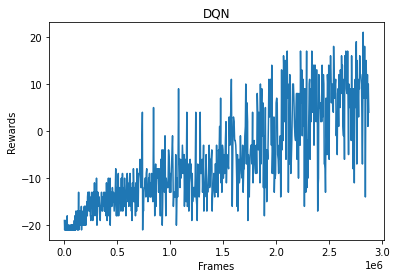

Episode:  801
Steps:  719028  epsilon:  0.030000000000000235
Steps:  719228  epsilon:  0.03000000000000023
Steps:  719428  epsilon:  0.03000000000000023
Steps:  719628  epsilon:  0.030000000000000228
Episode:  802
Steps:  719747  epsilon:  0.030000000000000228
Steps:  719947  epsilon:  0.030000000000000224
Steps:  720147  epsilon:  0.03000000000000022
Steps:  720347  epsilon:  0.03000000000000022
Steps:  720547  epsilon:  0.030000000000000217
Episode:  803
Steps:  720585  epsilon:  0.030000000000000217
Steps:  720785  epsilon:  0.030000000000000214
Steps:  720985  epsilon:  0.030000000000000214
Steps:  721185  epsilon:  0.03000000000000021
Steps:  721385  epsilon:  0.03000000000000021
Episode:  804
Steps:  721434  epsilon:  0.030000000000000207
Steps:  721634  epsilon:  0.030000000000000207
Steps:  721834  epsilon:  0.030000000000000204
Steps:  722034  epsilon:  0.030000000000000204
Steps:  722234  epsilon:  0.0300000000000002
Steps:  722434  epsilon:  0.030000000000000197
Episode:  80

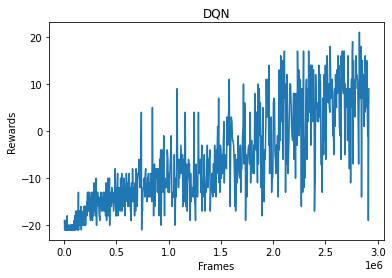

Episode:  811
Steps:  728285  epsilon:  0.030000000000000148
Steps:  728485  epsilon:  0.030000000000000145
Steps:  728685  epsilon:  0.030000000000000145
Steps:  728885  epsilon:  0.030000000000000145
Steps:  729085  epsilon:  0.03000000000000014
Steps:  729285  epsilon:  0.03000000000000014
Episode:  812
Steps:  729291  epsilon:  0.03000000000000014
Steps:  729491  epsilon:  0.030000000000000138
Steps:  729691  epsilon:  0.030000000000000138
Steps:  729891  epsilon:  0.030000000000000138
Steps:  730091  epsilon:  0.030000000000000134
Steps:  730291  epsilon:  0.030000000000000134
Episode:  813
Steps:  730302  epsilon:  0.030000000000000134
Steps:  730502  epsilon:  0.03000000000000013
Steps:  730702  epsilon:  0.03000000000000013
Steps:  730902  epsilon:  0.03000000000000013
Steps:  731102  epsilon:  0.030000000000000127
Episode:  814
Steps:  731150  epsilon:  0.030000000000000127
Steps:  731350  epsilon:  0.030000000000000127
Steps:  731550  epsilon:  0.030000000000000124
Steps:  73

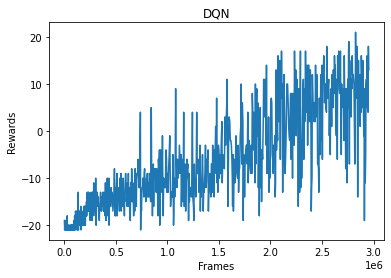

Episode:  821
Steps:  737831  epsilon:  0.030000000000000093
Steps:  738031  epsilon:  0.03000000000000009
Steps:  738231  epsilon:  0.03000000000000009
Steps:  738431  epsilon:  0.03000000000000009
Steps:  738631  epsilon:  0.03000000000000009
Episode:  822
Steps:  738634  epsilon:  0.03000000000000009
Steps:  738834  epsilon:  0.030000000000000086
Steps:  739034  epsilon:  0.030000000000000086
Steps:  739234  epsilon:  0.030000000000000086
Steps:  739434  epsilon:  0.030000000000000086
Episode:  823
Steps:  739450  epsilon:  0.030000000000000086
Steps:  739650  epsilon:  0.030000000000000082
Steps:  739850  epsilon:  0.030000000000000082
Steps:  740050  epsilon:  0.030000000000000082
Steps:  740250  epsilon:  0.030000000000000082
Episode:  824
Steps:  740302  epsilon:  0.030000000000000082
Steps:  740502  epsilon:  0.03000000000000008
Steps:  740702  epsilon:  0.03000000000000008
Steps:  740902  epsilon:  0.03000000000000008
Steps:  741102  epsilon:  0.03000000000000008
Episode:  825

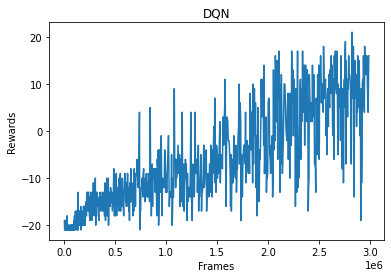

Episode:  831
Steps:  746946  epsilon:  0.030000000000000058
Steps:  747146  epsilon:  0.030000000000000058
Steps:  747346  epsilon:  0.030000000000000058
Steps:  747546  epsilon:  0.030000000000000054
Steps:  747746  epsilon:  0.030000000000000054
Steps:  747946  epsilon:  0.030000000000000054
Steps:  748146  epsilon:  0.030000000000000054
Episode:  832
Steps:  748181  epsilon:  0.030000000000000054
Steps:  748381  epsilon:  0.030000000000000054
Steps:  748581  epsilon:  0.030000000000000054
Steps:  748781  epsilon:  0.03000000000000005
Steps:  748981  epsilon:  0.03000000000000005
Episode:  833
Steps:  749064  epsilon:  0.03000000000000005
Steps:  749264  epsilon:  0.03000000000000005
Steps:  749464  epsilon:  0.03000000000000005
Steps:  749664  epsilon:  0.03000000000000005
Steps:  749864  epsilon:  0.03000000000000005
Episode:  834
Steps:  749898  epsilon:  0.03000000000000005
Steps:  750098  epsilon:  0.030000000000000047
Steps:  750298  epsilon:  0.030000000000000047
Steps:  7504

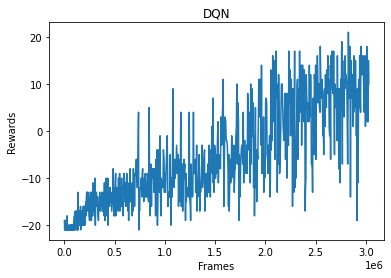

Episode:  841
Steps:  756463  epsilon:  0.030000000000000034
Steps:  756663  epsilon:  0.030000000000000034
Steps:  756863  epsilon:  0.030000000000000034
Steps:  757063  epsilon:  0.030000000000000034
Steps:  757263  epsilon:  0.030000000000000034
Episode:  842
Steps:  757337  epsilon:  0.030000000000000034
Steps:  757537  epsilon:  0.030000000000000034
Steps:  757737  epsilon:  0.030000000000000034
Steps:  757937  epsilon:  0.030000000000000034
Steps:  758137  epsilon:  0.030000000000000034
Episode:  843
Steps:  758202  epsilon:  0.030000000000000034
Steps:  758402  epsilon:  0.030000000000000034
Steps:  758602  epsilon:  0.03000000000000003
Steps:  758802  epsilon:  0.03000000000000003
Steps:  759002  epsilon:  0.03000000000000003
Episode:  844
Steps:  759036  epsilon:  0.03000000000000003
Steps:  759236  epsilon:  0.03000000000000003
Steps:  759436  epsilon:  0.03000000000000003
Steps:  759636  epsilon:  0.03000000000000003
Steps:  759836  epsilon:  0.03000000000000003
Episode:  84

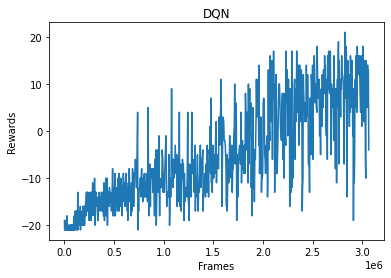

Episode:  851
Steps:  765814  epsilon:  0.030000000000000023
Steps:  766014  epsilon:  0.03000000000000002
Steps:  766214  epsilon:  0.03000000000000002
Steps:  766414  epsilon:  0.03000000000000002
Steps:  766614  epsilon:  0.03000000000000002
Steps:  766814  epsilon:  0.03000000000000002
Episode:  852
Steps:  766916  epsilon:  0.03000000000000002
Steps:  767116  epsilon:  0.03000000000000002
Steps:  767316  epsilon:  0.03000000000000002
Steps:  767516  epsilon:  0.03000000000000002
Episode:  853
Steps:  767661  epsilon:  0.03000000000000002
Steps:  767861  epsilon:  0.03000000000000002
Steps:  768061  epsilon:  0.03000000000000002
Steps:  768261  epsilon:  0.03000000000000002
Steps:  768461  epsilon:  0.03000000000000002
Steps:  768661  epsilon:  0.03000000000000002
Episode:  854
Steps:  768834  epsilon:  0.03000000000000002
Steps:  769034  epsilon:  0.03000000000000002
Steps:  769234  epsilon:  0.03000000000000002
Steps:  769434  epsilon:  0.030000000000000016
Steps:  769634  epsilo

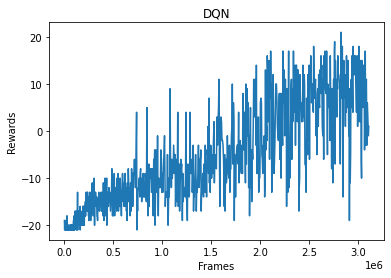

Episode:  861
Steps:  776640  epsilon:  0.030000000000000013
Steps:  776840  epsilon:  0.030000000000000013
Steps:  777040  epsilon:  0.030000000000000013
Steps:  777240  epsilon:  0.030000000000000013
Steps:  777440  epsilon:  0.030000000000000013
Steps:  777640  epsilon:  0.030000000000000013
Episode:  862
Steps:  777708  epsilon:  0.030000000000000013
Steps:  777908  epsilon:  0.030000000000000013
Steps:  778108  epsilon:  0.030000000000000013
Steps:  778308  epsilon:  0.030000000000000013
Steps:  778508  epsilon:  0.03000000000000001
Steps:  778708  epsilon:  0.03000000000000001
Steps:  778908  epsilon:  0.03000000000000001
Steps:  779108  epsilon:  0.03000000000000001
Episode:  863
Steps:  779126  epsilon:  0.03000000000000001
Steps:  779326  epsilon:  0.03000000000000001
Steps:  779526  epsilon:  0.03000000000000001
Steps:  779726  epsilon:  0.03000000000000001
Steps:  779926  epsilon:  0.03000000000000001
Episode:  864
Steps:  780025  epsilon:  0.03000000000000001
Steps:  780225

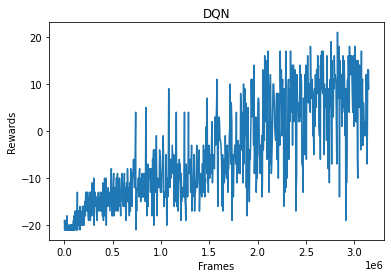

Episode:  871
Steps:  786676  epsilon:  0.030000000000000006
Steps:  786876  epsilon:  0.030000000000000006
Steps:  787076  epsilon:  0.030000000000000006
Steps:  787276  epsilon:  0.030000000000000006
Episode:  872
Steps:  787455  epsilon:  0.030000000000000006
Steps:  787655  epsilon:  0.030000000000000006
Steps:  787855  epsilon:  0.030000000000000006
Steps:  788055  epsilon:  0.030000000000000006
Steps:  788255  epsilon:  0.030000000000000006
Steps:  788455  epsilon:  0.030000000000000006
Episode:  873
Steps:  788646  epsilon:  0.030000000000000006
Steps:  788846  epsilon:  0.030000000000000006
Steps:  789046  epsilon:  0.030000000000000006
Steps:  789246  epsilon:  0.030000000000000006
Steps:  789446  epsilon:  0.030000000000000006
Steps:  789646  epsilon:  0.030000000000000006
Episode:  874
Steps:  789684  epsilon:  0.030000000000000006
Steps:  789884  epsilon:  0.030000000000000006
Steps:  790084  epsilon:  0.030000000000000006
Steps:  790284  epsilon:  0.030000000000000006
Step

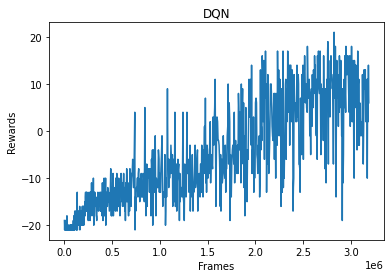

Episode:  881
Steps:  796553  epsilon:  0.030000000000000002
Steps:  796753  epsilon:  0.030000000000000002
Steps:  796953  epsilon:  0.030000000000000002
Steps:  797153  epsilon:  0.030000000000000002
Steps:  797353  epsilon:  0.030000000000000002
Episode:  882
Steps:  797465  epsilon:  0.030000000000000002
Steps:  797665  epsilon:  0.030000000000000002
Steps:  797865  epsilon:  0.030000000000000002
Steps:  798065  epsilon:  0.030000000000000002
Steps:  798265  epsilon:  0.030000000000000002
Steps:  798465  epsilon:  0.030000000000000002
Episode:  883
Steps:  798609  epsilon:  0.030000000000000002
Steps:  798809  epsilon:  0.030000000000000002
Steps:  799009  epsilon:  0.030000000000000002
Steps:  799209  epsilon:  0.030000000000000002
Episode:  884
Steps:  799386  epsilon:  0.030000000000000002
Steps:  799586  epsilon:  0.030000000000000002
Steps:  799786  epsilon:  0.030000000000000002
Steps:  799986  epsilon:  0.030000000000000002
Episode:  885
Steps:  800119  epsilon:  0.030000000

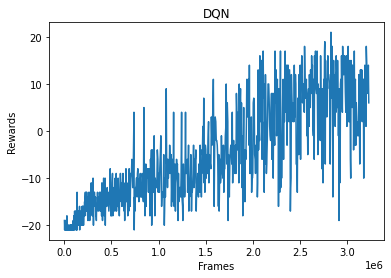

Episode:  891
Steps:  805995  epsilon:  0.030000000000000002
Steps:  806195  epsilon:  0.030000000000000002
Steps:  806395  epsilon:  0.030000000000000002
Steps:  806595  epsilon:  0.030000000000000002
Steps:  806795  epsilon:  0.030000000000000002
Episode:  892
Steps:  806874  epsilon:  0.030000000000000002
Steps:  807074  epsilon:  0.030000000000000002
Steps:  807274  epsilon:  0.030000000000000002
Steps:  807474  epsilon:  0.030000000000000002
Steps:  807674  epsilon:  0.030000000000000002
Episode:  893
Steps:  807715  epsilon:  0.030000000000000002
Steps:  807915  epsilon:  0.030000000000000002
Steps:  808115  epsilon:  0.030000000000000002
Steps:  808315  epsilon:  0.030000000000000002
Steps:  808515  epsilon:  0.030000000000000002
Episode:  894
Steps:  808524  epsilon:  0.030000000000000002
Steps:  808724  epsilon:  0.030000000000000002
Steps:  808924  epsilon:  0.030000000000000002
Steps:  809124  epsilon:  0.030000000000000002
Steps:  809324  epsilon:  0.030000000000000002
Epis

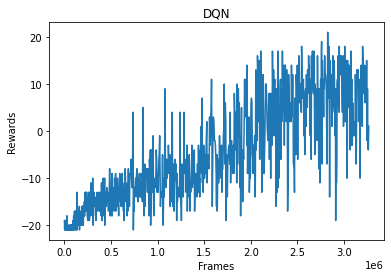

Episode:  901
Steps:  815931  epsilon:  0.030000000000000002
Steps:  816131  epsilon:  0.030000000000000002
Steps:  816331  epsilon:  0.030000000000000002
Steps:  816531  epsilon:  0.030000000000000002
Episode:  902
Steps:  816701  epsilon:  0.030000000000000002
Steps:  816901  epsilon:  0.030000000000000002
Steps:  817101  epsilon:  0.030000000000000002
Steps:  817301  epsilon:  0.030000000000000002
Steps:  817501  epsilon:  0.03
Steps:  817701  epsilon:  0.03
Episode:  903
Steps:  817719  epsilon:  0.03
Steps:  817919  epsilon:  0.03
Steps:  818119  epsilon:  0.03
Steps:  818319  epsilon:  0.03
Steps:  818519  epsilon:  0.03
Episode:  904
Steps:  818566  epsilon:  0.03
Steps:  818766  epsilon:  0.03
Steps:  818966  epsilon:  0.03
Steps:  819166  epsilon:  0.03
Steps:  819366  epsilon:  0.03
Steps:  819566  epsilon:  0.03
Episode:  905
Steps:  819641  epsilon:  0.03
Steps:  819841  epsilon:  0.03
Steps:  820041  epsilon:  0.03
Steps:  820241  epsilon:  0.03
Steps:  820441  epsilon:  0

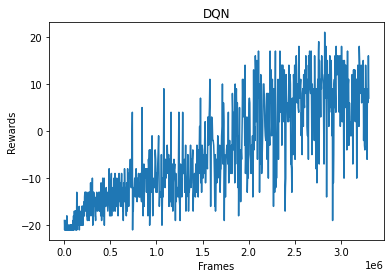

Episode:  911
Steps:  825272  epsilon:  0.03
Steps:  825472  epsilon:  0.03
Steps:  825672  epsilon:  0.03
Steps:  825872  epsilon:  0.03
Steps:  826072  epsilon:  0.03
Episode:  912
Steps:  826268  epsilon:  0.03
Steps:  826468  epsilon:  0.03
Steps:  826668  epsilon:  0.03
Steps:  826868  epsilon:  0.03
Steps:  827068  epsilon:  0.03
Episode:  913
Steps:  827205  epsilon:  0.03
Steps:  827405  epsilon:  0.03
Steps:  827605  epsilon:  0.03
Steps:  827805  epsilon:  0.03
Steps:  828005  epsilon:  0.03
Steps:  828205  epsilon:  0.03
Episode:  914
Steps:  828264  epsilon:  0.03
Steps:  828464  epsilon:  0.03
Steps:  828664  epsilon:  0.03
Steps:  828864  epsilon:  0.03
Steps:  829064  epsilon:  0.03
Episode:  915
Steps:  829073  epsilon:  0.03
Steps:  829273  epsilon:  0.03
Steps:  829473  epsilon:  0.03
Steps:  829673  epsilon:  0.03
Steps:  829873  epsilon:  0.03
Episode:  916
Steps:  829933  epsilon:  0.03
Steps:  830133  epsilon:  0.03
Steps:  830333  epsilon:  0.03
Steps:  830533  e

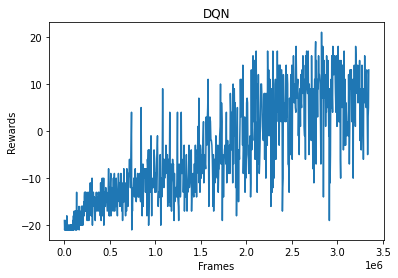

Episode:  921
Steps:  835406  epsilon:  0.03
Steps:  835606  epsilon:  0.03
Steps:  835806  epsilon:  0.03
Steps:  836006  epsilon:  0.03
Steps:  836206  epsilon:  0.03
Steps:  836406  epsilon:  0.03
Episode:  922
Steps:  836441  epsilon:  0.03
Steps:  836641  epsilon:  0.03
Steps:  836841  epsilon:  0.03
Steps:  837041  epsilon:  0.03
Steps:  837241  epsilon:  0.03
Episode:  923
Steps:  837250  epsilon:  0.03
Steps:  837450  epsilon:  0.03
Steps:  837650  epsilon:  0.03
Steps:  837850  epsilon:  0.03
Steps:  838050  epsilon:  0.03
Steps:  838250  epsilon:  0.03
Episode:  924
Steps:  838257  epsilon:  0.03
Steps:  838457  epsilon:  0.03
Steps:  838657  epsilon:  0.03
Steps:  838857  epsilon:  0.03
Steps:  839057  epsilon:  0.03
Steps:  839257  epsilon:  0.03
Steps:  839457  epsilon:  0.03
Episode:  925
Steps:  839560  epsilon:  0.03
Steps:  839760  epsilon:  0.03
Steps:  839960  epsilon:  0.03
Steps:  840160  epsilon:  0.03
Steps:  840360  epsilon:  0.03
Episode:  926
Steps:  840465  e

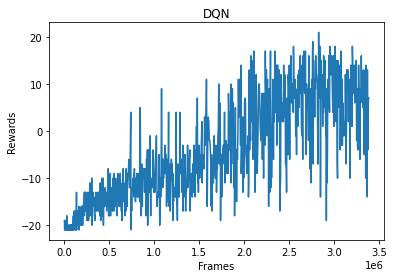

Episode:  931
Steps:  844984  epsilon:  0.03
Steps:  845184  epsilon:  0.03
Steps:  845384  epsilon:  0.03
Steps:  845584  epsilon:  0.03
Steps:  845784  epsilon:  0.03
Steps:  845984  epsilon:  0.03
Episode:  932
Steps:  846088  epsilon:  0.03
Steps:  846288  epsilon:  0.03
Steps:  846488  epsilon:  0.03
Steps:  846688  epsilon:  0.03
Steps:  846888  epsilon:  0.03
Steps:  847088  epsilon:  0.03
Episode:  933
Steps:  847163  epsilon:  0.03
Steps:  847363  epsilon:  0.03
Steps:  847563  epsilon:  0.03
Steps:  847763  epsilon:  0.03
Steps:  847963  epsilon:  0.03
Steps:  848163  epsilon:  0.03
Episode:  934
Steps:  848359  epsilon:  0.03
Steps:  848559  epsilon:  0.03
Steps:  848759  epsilon:  0.03
Steps:  848959  epsilon:  0.03
Steps:  849159  epsilon:  0.03
Episode:  935
Steps:  849184  epsilon:  0.03
Steps:  849384  epsilon:  0.03
Steps:  849584  epsilon:  0.03
Steps:  849784  epsilon:  0.03
Steps:  849984  epsilon:  0.03
Steps:  850184  epsilon:  0.03
Steps:  850384  epsilon:  0.03


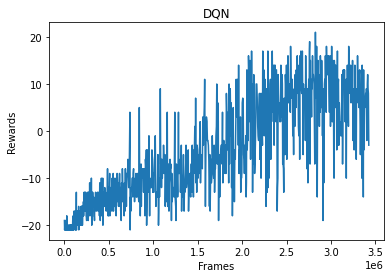

Episode:  941
Steps:  855808  epsilon:  0.03
Steps:  856008  epsilon:  0.03
Steps:  856208  epsilon:  0.03
Steps:  856408  epsilon:  0.03
Steps:  856608  epsilon:  0.03
Steps:  856808  epsilon:  0.03
Episode:  942
Steps:  856827  epsilon:  0.03
Steps:  857027  epsilon:  0.03
Steps:  857227  epsilon:  0.03
Steps:  857427  epsilon:  0.03
Episode:  943
Steps:  857529  epsilon:  0.03
Steps:  857729  epsilon:  0.03
Steps:  857929  epsilon:  0.03
Steps:  858129  epsilon:  0.03
Steps:  858329  epsilon:  0.03
Episode:  944
Steps:  858443  epsilon:  0.03
Steps:  858643  epsilon:  0.03
Steps:  858843  epsilon:  0.03
Steps:  859043  epsilon:  0.03
Steps:  859243  epsilon:  0.03
Steps:  859443  epsilon:  0.03
Steps:  859643  epsilon:  0.03
Episode:  945
Steps:  859680  epsilon:  0.03
Steps:  859880  epsilon:  0.03
Steps:  860080  epsilon:  0.03
Steps:  860280  epsilon:  0.03
Steps:  860480  epsilon:  0.03
Steps:  860680  epsilon:  0.03
Episode:  946
Steps:  860769  epsilon:  0.03
Steps:  860969  e

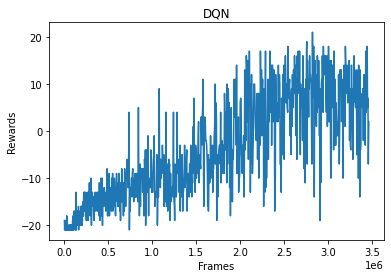

Episode:  951
Steps:  865960  epsilon:  0.03
Steps:  866160  epsilon:  0.03
Steps:  866360  epsilon:  0.03
Steps:  866560  epsilon:  0.03
Steps:  866760  epsilon:  0.03
Episode:  952
Steps:  866878  epsilon:  0.03
Steps:  867078  epsilon:  0.03
Steps:  867278  epsilon:  0.03
Steps:  867478  epsilon:  0.03
Steps:  867678  epsilon:  0.03
Steps:  867878  epsilon:  0.03
Episode:  953
Steps:  867903  epsilon:  0.03
Steps:  868103  epsilon:  0.03
Steps:  868303  epsilon:  0.03
Steps:  868503  epsilon:  0.03
Steps:  868703  epsilon:  0.03
Episode:  954
Steps:  868883  epsilon:  0.03
Steps:  869083  epsilon:  0.03
Steps:  869283  epsilon:  0.03
Steps:  869483  epsilon:  0.03
Steps:  869683  epsilon:  0.03
Steps:  869883  epsilon:  0.03
Episode:  955
Steps:  869938  epsilon:  0.03
Steps:  870138  epsilon:  0.03
Steps:  870338  epsilon:  0.03
Steps:  870538  epsilon:  0.03
Steps:  870738  epsilon:  0.03
Episode:  956
Steps:  870921  epsilon:  0.03
Steps:  871121  epsilon:  0.03
Steps:  871321  e

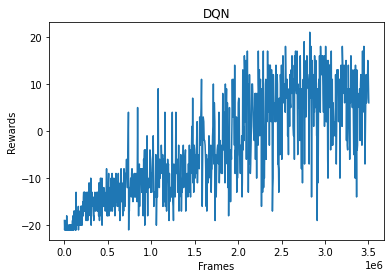

Episode:  961
Steps:  875505  epsilon:  0.03
Steps:  875705  epsilon:  0.03
Steps:  875905  epsilon:  0.03
Steps:  876105  epsilon:  0.03
Episode:  962
Steps:  876182  epsilon:  0.03
Steps:  876382  epsilon:  0.03
Steps:  876582  epsilon:  0.03
Steps:  876782  epsilon:  0.03
Episode:  963
Steps:  876890  epsilon:  0.03
Steps:  877090  epsilon:  0.03
Steps:  877290  epsilon:  0.03
Steps:  877490  epsilon:  0.03
Steps:  877690  epsilon:  0.03
Steps:  877890  epsilon:  0.03
Episode:  964
Steps:  877906  epsilon:  0.03
Steps:  878106  epsilon:  0.03
Steps:  878306  epsilon:  0.03
Steps:  878506  epsilon:  0.03
Steps:  878706  epsilon:  0.03
Steps:  878906  epsilon:  0.03
Episode:  965
Steps:  879104  epsilon:  0.03
Steps:  879304  epsilon:  0.03
Steps:  879504  epsilon:  0.03
Steps:  879704  epsilon:  0.03
Steps:  879904  epsilon:  0.03
Steps:  880104  epsilon:  0.03
Episode:  966
Steps:  880253  epsilon:  0.03
Steps:  880453  epsilon:  0.03
Steps:  880653  epsilon:  0.03
Steps:  880853  e

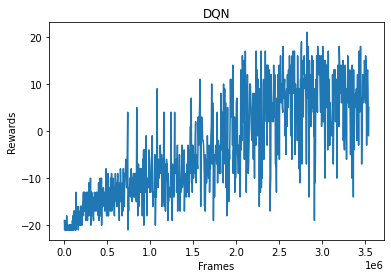

Episode:  971
Steps:  885368  epsilon:  0.03
Steps:  885568  epsilon:  0.03
Steps:  885768  epsilon:  0.03
Steps:  885968  epsilon:  0.03
Episode:  972
Steps:  886127  epsilon:  0.03
Steps:  886327  epsilon:  0.03
Steps:  886527  epsilon:  0.03
Steps:  886727  epsilon:  0.03
Steps:  886927  epsilon:  0.03
Episode:  973
Steps:  886993  epsilon:  0.03
Steps:  887193  epsilon:  0.03
Steps:  887393  epsilon:  0.03
Steps:  887593  epsilon:  0.03
Episode:  974
Steps:  887792  epsilon:  0.03
Steps:  887992  epsilon:  0.03
Steps:  888192  epsilon:  0.03
Steps:  888392  epsilon:  0.03
Steps:  888592  epsilon:  0.03
Steps:  888792  epsilon:  0.03
Steps:  888992  epsilon:  0.03
Episode:  975
Steps:  888997  epsilon:  0.03
Steps:  889197  epsilon:  0.03
Steps:  889397  epsilon:  0.03
Steps:  889597  epsilon:  0.03
Steps:  889797  epsilon:  0.03
Steps:  889997  epsilon:  0.03
Episode:  976
Steps:  890042  epsilon:  0.03
Steps:  890242  epsilon:  0.03
Steps:  890442  epsilon:  0.03
Steps:  890642  e

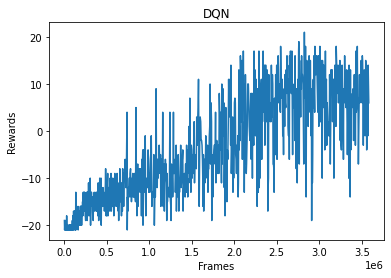

Episode:  981
Steps:  895178  epsilon:  0.03
Steps:  895378  epsilon:  0.03
Steps:  895578  epsilon:  0.03
Steps:  895778  epsilon:  0.03
Steps:  895978  epsilon:  0.03
Episode:  982
Steps:  896127  epsilon:  0.03
Steps:  896327  epsilon:  0.03
Steps:  896527  epsilon:  0.03
Steps:  896727  epsilon:  0.03
Steps:  896927  epsilon:  0.03
Steps:  897127  epsilon:  0.03
Episode:  983
Steps:  897183  epsilon:  0.03
Steps:  897383  epsilon:  0.03
Steps:  897583  epsilon:  0.03
Steps:  897783  epsilon:  0.03
Steps:  897983  epsilon:  0.03
Episode:  984
Steps:  898118  epsilon:  0.03
Steps:  898318  epsilon:  0.03
Steps:  898518  epsilon:  0.03
Steps:  898718  epsilon:  0.03
Steps:  898918  epsilon:  0.03
Episode:  985
Steps:  898962  epsilon:  0.03
Steps:  899162  epsilon:  0.03
Steps:  899362  epsilon:  0.03
Steps:  899562  epsilon:  0.03
Steps:  899762  epsilon:  0.03
Episode:  986
Steps:  899876  epsilon:  0.03
Steps:  900076  epsilon:  0.03
Steps:  900276  epsilon:  0.03
Steps:  900476  e

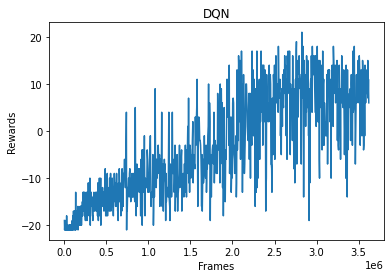

Episode:  991
Steps:  904520  epsilon:  0.03
Steps:  904720  epsilon:  0.03
Steps:  904920  epsilon:  0.03
Steps:  905120  epsilon:  0.03
Steps:  905320  epsilon:  0.03
Steps:  905520  epsilon:  0.03
Episode:  992
Steps:  905551  epsilon:  0.03
Steps:  905751  epsilon:  0.03
Steps:  905951  epsilon:  0.03
Steps:  906151  epsilon:  0.03
Steps:  906351  epsilon:  0.03
Steps:  906551  epsilon:  0.03
Episode:  993
Steps:  906734  epsilon:  0.03
Steps:  906934  epsilon:  0.03
Steps:  907134  epsilon:  0.03
Steps:  907334  epsilon:  0.03
Steps:  907534  epsilon:  0.03
Steps:  907734  epsilon:  0.03
Episode:  994
Steps:  907765  epsilon:  0.03
Steps:  907965  epsilon:  0.03
Steps:  908165  epsilon:  0.03
Steps:  908365  epsilon:  0.03
Steps:  908565  epsilon:  0.03
Episode:  995
Steps:  908622  epsilon:  0.03
Steps:  908822  epsilon:  0.03
Steps:  909022  epsilon:  0.03
Steps:  909222  epsilon:  0.03
Steps:  909422  epsilon:  0.03
Steps:  909622  epsilon:  0.03
Episode:  996
Steps:  909672  e

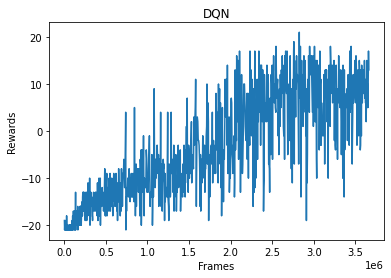

Episode:  1001
Steps:  914601  epsilon:  0.03
Steps:  914801  epsilon:  0.03
Steps:  915001  epsilon:  0.03
Steps:  915201  epsilon:  0.03
Steps:  915401  epsilon:  0.03
Steps:  915601  epsilon:  0.03
Episode:  1002
Steps:  915617  epsilon:  0.03
Steps:  915817  epsilon:  0.03
Steps:  916017  epsilon:  0.03
Steps:  916217  epsilon:  0.03
Episode:  1003
Steps:  916251  epsilon:  0.03
Steps:  916451  epsilon:  0.03
Steps:  916651  epsilon:  0.03
Steps:  916851  epsilon:  0.03
Episode:  1004
Steps:  916985  epsilon:  0.03
Steps:  917185  epsilon:  0.03
Steps:  917385  epsilon:  0.03
Steps:  917585  epsilon:  0.03
Steps:  917785  epsilon:  0.03
Episode:  1005
Steps:  917965  epsilon:  0.03
Steps:  918165  epsilon:  0.03
Steps:  918365  epsilon:  0.03
Steps:  918565  epsilon:  0.03
Steps:  918765  epsilon:  0.03
Episode:  1006
Steps:  918794  epsilon:  0.03
Steps:  918994  epsilon:  0.03
Steps:  919194  epsilon:  0.03
Steps:  919394  epsilon:  0.03
Steps:  919594  epsilon:  0.03
Episode:  1

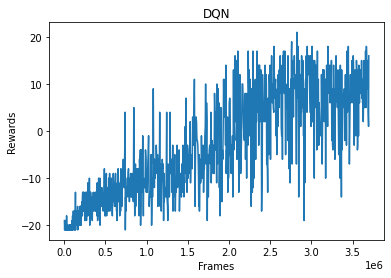

Episode:  1011
Steps:  923487  epsilon:  0.03
Steps:  923687  epsilon:  0.03
Steps:  923887  epsilon:  0.03
Steps:  924087  epsilon:  0.03
Steps:  924287  epsilon:  0.03
Episode:  1012
Steps:  924462  epsilon:  0.03
Steps:  924662  epsilon:  0.03
Steps:  924862  epsilon:  0.03
Steps:  925062  epsilon:  0.03
Steps:  925262  epsilon:  0.03
Steps:  925462  epsilon:  0.03
Episode:  1013
Steps:  925573  epsilon:  0.03
Steps:  925773  epsilon:  0.03
Steps:  925973  epsilon:  0.03
Steps:  926173  epsilon:  0.03
Steps:  926373  epsilon:  0.03
Steps:  926573  epsilon:  0.03
Episode:  1014
Steps:  926716  epsilon:  0.03
Steps:  926916  epsilon:  0.03
Steps:  927116  epsilon:  0.03
Steps:  927316  epsilon:  0.03
Steps:  927516  epsilon:  0.03
Steps:  927716  epsilon:  0.03
Episode:  1015
Steps:  927734  epsilon:  0.03
Steps:  927934  epsilon:  0.03
Steps:  928134  epsilon:  0.03
Steps:  928334  epsilon:  0.03
Episode:  1016
Steps:  928427  epsilon:  0.03
Steps:  928627  epsilon:  0.03
Steps:  928

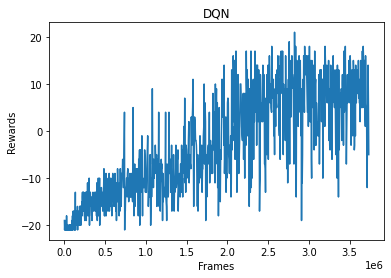

Episode:  1021
Steps:  933391  epsilon:  0.03
Steps:  933591  epsilon:  0.03
Steps:  933791  epsilon:  0.03
Steps:  933991  epsilon:  0.03
Episode:  1022
Steps:  934137  epsilon:  0.03
Steps:  934337  epsilon:  0.03
Steps:  934537  epsilon:  0.03
Steps:  934737  epsilon:  0.03
Steps:  934937  epsilon:  0.03
Episode:  1023
Steps:  934977  epsilon:  0.03
Steps:  935177  epsilon:  0.03
Steps:  935377  epsilon:  0.03
Steps:  935577  epsilon:  0.03
Steps:  935777  epsilon:  0.03
Episode:  1024
Steps:  935860  epsilon:  0.03
Steps:  936060  epsilon:  0.03
Steps:  936260  epsilon:  0.03
Steps:  936460  epsilon:  0.03
Steps:  936660  epsilon:  0.03
Episode:  1025
Steps:  936818  epsilon:  0.03
Steps:  937018  epsilon:  0.03
Steps:  937218  epsilon:  0.03
Steps:  937418  epsilon:  0.03
Steps:  937618  epsilon:  0.03
Episode:  1026
Steps:  937630  epsilon:  0.03
Steps:  937830  epsilon:  0.03
Steps:  938030  epsilon:  0.03
Steps:  938230  epsilon:  0.03
Steps:  938430  epsilon:  0.03
Steps:  938

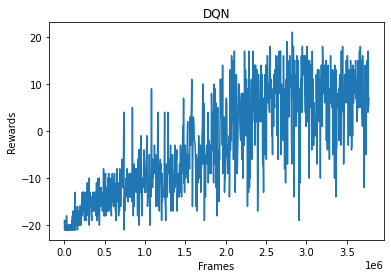

Episode:  1031
Steps:  942493  epsilon:  0.03
Steps:  942693  epsilon:  0.03
Steps:  942893  epsilon:  0.03
Steps:  943093  epsilon:  0.03
Steps:  943293  epsilon:  0.03
Episode:  1032
Steps:  943420  epsilon:  0.03
Steps:  943620  epsilon:  0.03
Steps:  943820  epsilon:  0.03
Steps:  944020  epsilon:  0.03
Steps:  944220  epsilon:  0.03
Steps:  944420  epsilon:  0.03
Episode:  1033
Steps:  944489  epsilon:  0.03
Steps:  944689  epsilon:  0.03
Steps:  944889  epsilon:  0.03
Steps:  945089  epsilon:  0.03
Steps:  945289  epsilon:  0.03
Episode:  1034
Steps:  945336  epsilon:  0.03
Steps:  945536  epsilon:  0.03
Steps:  945736  epsilon:  0.03
Steps:  945936  epsilon:  0.03
Episode:  1035
Steps:  946032  epsilon:  0.03
Steps:  946232  epsilon:  0.03
Steps:  946432  epsilon:  0.03
Steps:  946632  epsilon:  0.03
Steps:  946832  epsilon:  0.03
Steps:  947032  epsilon:  0.03
Episode:  1036
Steps:  947081  epsilon:  0.03
Steps:  947281  epsilon:  0.03
Steps:  947481  epsilon:  0.03
Steps:  947

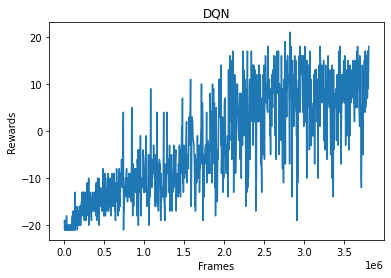

Episode:  1041
Steps:  951406  epsilon:  0.03
Steps:  951606  epsilon:  0.03
Steps:  951806  epsilon:  0.03
Steps:  952006  epsilon:  0.03
Episode:  1042
Steps:  952120  epsilon:  0.03
Steps:  952320  epsilon:  0.03
Steps:  952520  epsilon:  0.03
Steps:  952720  epsilon:  0.03
Episode:  1043
Steps:  952880  epsilon:  0.03
Steps:  953080  epsilon:  0.03
Steps:  953280  epsilon:  0.03
Steps:  953480  epsilon:  0.03
Episode:  1044
Steps:  953634  epsilon:  0.03
Steps:  953834  epsilon:  0.03
Steps:  954034  epsilon:  0.03
Steps:  954234  epsilon:  0.03
Steps:  954434  epsilon:  0.03
Episode:  1045
Steps:  954569  epsilon:  0.03
Steps:  954769  epsilon:  0.03
Steps:  954969  epsilon:  0.03
Steps:  955169  epsilon:  0.03
Steps:  955369  epsilon:  0.03
Steps:  955569  epsilon:  0.03
Episode:  1046
Steps:  955694  epsilon:  0.03
Steps:  955894  epsilon:  0.03
Steps:  956094  epsilon:  0.03
Steps:  956294  epsilon:  0.03
Steps:  956494  epsilon:  0.03
Steps:  956694  epsilon:  0.03
Episode:  1

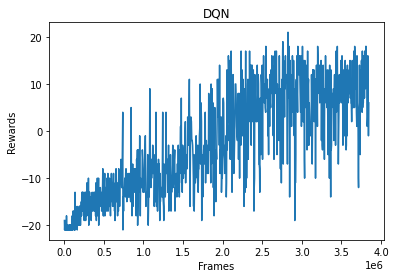

Episode:  1051
Steps:  960681  epsilon:  0.03
Steps:  960881  epsilon:  0.03
Steps:  961081  epsilon:  0.03
Steps:  961281  epsilon:  0.03
Episode:  1052
Steps:  961369  epsilon:  0.03
Steps:  961569  epsilon:  0.03
Steps:  961769  epsilon:  0.03
Steps:  961969  epsilon:  0.03
Steps:  962169  epsilon:  0.03
Episode:  1053
Steps:  962243  epsilon:  0.03
Steps:  962443  epsilon:  0.03
Steps:  962643  epsilon:  0.03
Steps:  962843  epsilon:  0.03
Steps:  963043  epsilon:  0.03
Episode:  1054
Steps:  963124  epsilon:  0.03
Steps:  963324  epsilon:  0.03
Steps:  963524  epsilon:  0.03
Steps:  963724  epsilon:  0.03
Steps:  963924  epsilon:  0.03
Episode:  1055
Steps:  963950  epsilon:  0.03
Steps:  964150  epsilon:  0.03
Steps:  964350  epsilon:  0.03
Steps:  964550  epsilon:  0.03
Steps:  964750  epsilon:  0.03
Steps:  964950  epsilon:  0.03
Episode:  1056
Steps:  965080  epsilon:  0.03
Steps:  965280  epsilon:  0.03
Steps:  965480  epsilon:  0.03
Steps:  965680  epsilon:  0.03
Steps:  965

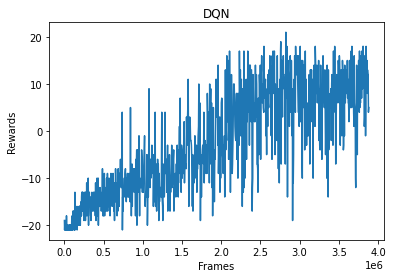

Episode:  1061
Steps:  969939  epsilon:  0.03
Steps:  970139  epsilon:  0.03
Steps:  970339  epsilon:  0.03
Steps:  970539  epsilon:  0.03
Steps:  970739  epsilon:  0.03
Steps:  970939  epsilon:  0.03
Episode:  1062
Steps:  970999  epsilon:  0.03
Steps:  971199  epsilon:  0.03
Steps:  971399  epsilon:  0.03
Steps:  971599  epsilon:  0.03
Steps:  971799  epsilon:  0.03
Episode:  1063
Steps:  971951  epsilon:  0.03
Steps:  972151  epsilon:  0.03
Steps:  972351  epsilon:  0.03
Steps:  972551  epsilon:  0.03
Episode:  1064
Steps:  972608  epsilon:  0.03
Steps:  972808  epsilon:  0.03
Steps:  973008  epsilon:  0.03
Steps:  973208  epsilon:  0.03
Steps:  973408  epsilon:  0.03
Episode:  1065
Steps:  973441  epsilon:  0.03
Steps:  973641  epsilon:  0.03
Steps:  973841  epsilon:  0.03
Steps:  974041  epsilon:  0.03
Episode:  1066
Steps:  974229  epsilon:  0.03
Steps:  974429  epsilon:  0.03
Steps:  974629  epsilon:  0.03
Steps:  974829  epsilon:  0.03
Steps:  975029  epsilon:  0.03
Steps:  975

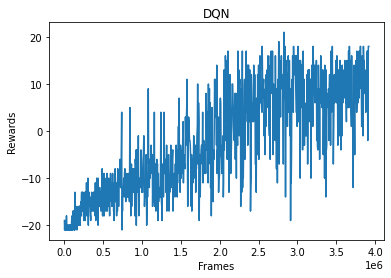

Episode:  1071
Steps:  978590  epsilon:  0.03
Steps:  978790  epsilon:  0.03
Steps:  978990  epsilon:  0.03
Steps:  979190  epsilon:  0.03
Steps:  979390  epsilon:  0.03
Steps:  979590  epsilon:  0.03
Episode:  1072
Steps:  979607  epsilon:  0.03
Steps:  979807  epsilon:  0.03
Steps:  980007  epsilon:  0.03
Steps:  980207  epsilon:  0.03
Steps:  980407  epsilon:  0.03
Episode:  1073
Steps:  980599  epsilon:  0.03
Steps:  980799  epsilon:  0.03
Steps:  980999  epsilon:  0.03
Steps:  981199  epsilon:  0.03
Episode:  1074
Steps:  981309  epsilon:  0.03
Steps:  981509  epsilon:  0.03
Steps:  981709  epsilon:  0.03
Steps:  981909  epsilon:  0.03
Steps:  982109  epsilon:  0.03
Episode:  1075
Steps:  982249  epsilon:  0.03
Steps:  982449  epsilon:  0.03
Steps:  982649  epsilon:  0.03
Steps:  982849  epsilon:  0.03
Steps:  983049  epsilon:  0.03
Steps:  983249  epsilon:  0.03
Steps:  983449  epsilon:  0.03
Episode:  1076
Steps:  983516  epsilon:  0.03
Steps:  983716  epsilon:  0.03
Steps:  983

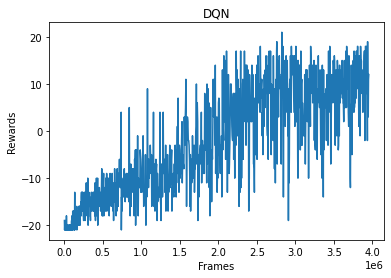

Episode:  1081
Steps:  988003  epsilon:  0.03
Steps:  988203  epsilon:  0.03
Steps:  988403  epsilon:  0.03
Steps:  988603  epsilon:  0.03
Steps:  988803  epsilon:  0.03
Steps:  989003  epsilon:  0.03
Episode:  1082
Steps:  989158  epsilon:  0.03
Steps:  989358  epsilon:  0.03
Steps:  989558  epsilon:  0.03
Steps:  989758  epsilon:  0.03
Steps:  989958  epsilon:  0.03
Steps:  990158  epsilon:  0.03
Episode:  1083
Steps:  990263  epsilon:  0.03
Steps:  990463  epsilon:  0.03
Steps:  990663  epsilon:  0.03
Steps:  990863  epsilon:  0.03
Steps:  991063  epsilon:  0.03
Episode:  1084
Steps:  991227  epsilon:  0.03
Steps:  991427  epsilon:  0.03
Steps:  991627  epsilon:  0.03
Steps:  991827  epsilon:  0.03
Steps:  992027  epsilon:  0.03
Episode:  1085
Steps:  992129  epsilon:  0.03
Steps:  992329  epsilon:  0.03
Steps:  992529  epsilon:  0.03
Steps:  992729  epsilon:  0.03
Steps:  992929  epsilon:  0.03
Episode:  1086
Steps:  992941  epsilon:  0.03
Steps:  993141  epsilon:  0.03
Steps:  993

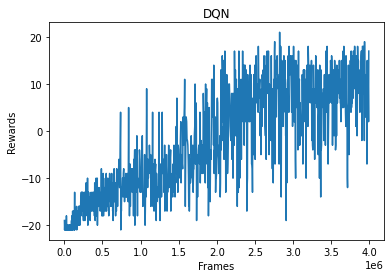

Episode:  1091
Steps:  998046  epsilon:  0.03
Steps:  998246  epsilon:  0.03
Steps:  998446  epsilon:  0.03
Steps:  998646  epsilon:  0.03
Steps:  998846  epsilon:  0.03
Steps:  999046  epsilon:  0.03
Episode:  1092
Steps:  999055  epsilon:  0.03
Steps:  999255  epsilon:  0.03
Steps:  999455  epsilon:  0.03
Steps:  999655  epsilon:  0.03
Steps:  999855  epsilon:  0.03
Episode:  1093
Steps:  1000027  epsilon:  0.03
Steps:  1000227  epsilon:  0.03
Steps:  1000427  epsilon:  0.03
Steps:  1000627  epsilon:  0.03
Steps:  1000827  epsilon:  0.03
Episode:  1094
Steps:  1000982  epsilon:  0.03
Steps:  1001182  epsilon:  0.03
Steps:  1001382  epsilon:  0.03
Steps:  1001582  epsilon:  0.03
Episode:  1095
Steps:  1001669  epsilon:  0.03
Steps:  1001869  epsilon:  0.03
Steps:  1002069  epsilon:  0.03
Steps:  1002269  epsilon:  0.03
Steps:  1002469  epsilon:  0.03
Episode:  1096
Steps:  1002513  epsilon:  0.03
Steps:  1002713  epsilon:  0.03
Steps:  1002913  epsilon:  0.03
Episode:  1097
Steps:  10

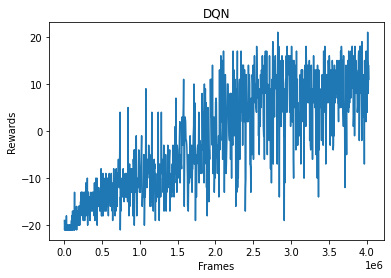

Episode:  1101
Steps:  1006722  epsilon:  0.03
Steps:  1006922  epsilon:  0.03
Steps:  1007122  epsilon:  0.03
Steps:  1007322  epsilon:  0.03
Episode:  1102
Steps:  1007456  epsilon:  0.03
Steps:  1007656  epsilon:  0.03
Steps:  1007856  epsilon:  0.03
Steps:  1008056  epsilon:  0.03
Steps:  1008256  epsilon:  0.03
Episode:  1103
Steps:  1008268  epsilon:  0.03
Steps:  1008468  epsilon:  0.03
Steps:  1008668  epsilon:  0.03
Steps:  1008868  epsilon:  0.03
Steps:  1009068  epsilon:  0.03
Episode:  1104
Steps:  1009143  epsilon:  0.03
Steps:  1009343  epsilon:  0.03
Steps:  1009543  epsilon:  0.03
Steps:  1009743  epsilon:  0.03
Episode:  1105
Steps:  1009900  epsilon:  0.03
Steps:  1010100  epsilon:  0.03
Steps:  1010300  epsilon:  0.03
Steps:  1010500  epsilon:  0.03
Steps:  1010700  epsilon:  0.03
Episode:  1106
Steps:  1010815  epsilon:  0.03
Steps:  1011015  epsilon:  0.03
Steps:  1011215  epsilon:  0.03
Steps:  1011415  epsilon:  0.03
Episode:  1107
Steps:  1011432  epsilon:  0.03

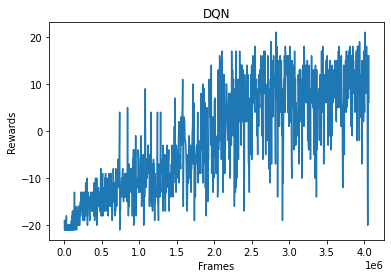

Episode:  1111
Steps:  1014955  epsilon:  0.03
Steps:  1015155  epsilon:  0.03
Steps:  1015355  epsilon:  0.03
Steps:  1015555  epsilon:  0.03
Steps:  1015755  epsilon:  0.03
Episode:  1112
Steps:  1015775  epsilon:  0.03
Steps:  1015975  epsilon:  0.03
Steps:  1016175  epsilon:  0.03
Steps:  1016375  epsilon:  0.03
Steps:  1016575  epsilon:  0.03
Episode:  1113
Steps:  1016695  epsilon:  0.03
Steps:  1016895  epsilon:  0.03
Steps:  1017095  epsilon:  0.03
Steps:  1017295  epsilon:  0.03
Steps:  1017495  epsilon:  0.03
Episode:  1114
Steps:  1017675  epsilon:  0.03
Steps:  1017875  epsilon:  0.03
Steps:  1018075  epsilon:  0.03
Steps:  1018275  epsilon:  0.03
Episode:  1115
Steps:  1018340  epsilon:  0.03
Steps:  1018540  epsilon:  0.03
Steps:  1018740  epsilon:  0.03
Steps:  1018940  epsilon:  0.03
Episode:  1116
Steps:  1019027  epsilon:  0.03
Steps:  1019227  epsilon:  0.03
Steps:  1019427  epsilon:  0.03
Steps:  1019627  epsilon:  0.03
Steps:  1019827  epsilon:  0.03
Steps:  102002

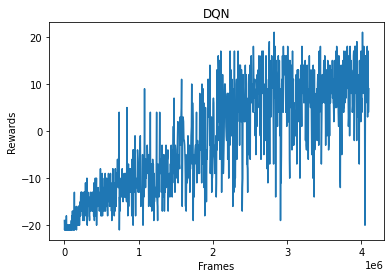

Episode:  1121
Steps:  1024169  epsilon:  0.03
Steps:  1024369  epsilon:  0.03
Steps:  1024569  epsilon:  0.03
Steps:  1024769  epsilon:  0.03
Episode:  1122
Steps:  1024938  epsilon:  0.03
Steps:  1025138  epsilon:  0.03
Steps:  1025338  epsilon:  0.03
Steps:  1025538  epsilon:  0.03
Steps:  1025738  epsilon:  0.03
Episode:  1123
Steps:  1025908  epsilon:  0.03
Steps:  1026108  epsilon:  0.03
Steps:  1026308  epsilon:  0.03
Steps:  1026508  epsilon:  0.03
Steps:  1026708  epsilon:  0.03
Episode:  1124
Steps:  1026810  epsilon:  0.03
Steps:  1027010  epsilon:  0.03
Steps:  1027210  epsilon:  0.03
Steps:  1027410  epsilon:  0.03
Episode:  1125
Steps:  1027500  epsilon:  0.03
Steps:  1027700  epsilon:  0.03
Steps:  1027900  epsilon:  0.03
Steps:  1028100  epsilon:  0.03
Steps:  1028300  epsilon:  0.03
Steps:  1028500  epsilon:  0.03
Episode:  1126
Steps:  1028609  epsilon:  0.03
Steps:  1028809  epsilon:  0.03
Steps:  1029009  epsilon:  0.03
Steps:  1029209  epsilon:  0.03
Steps:  102940

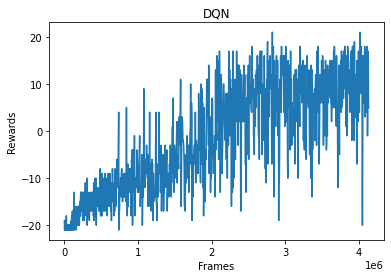

Episode:  1131
Steps:  1032929  epsilon:  0.03
Steps:  1033129  epsilon:  0.03
Steps:  1033329  epsilon:  0.03
Steps:  1033529  epsilon:  0.03
Steps:  1033729  epsilon:  0.03
Steps:  1033929  epsilon:  0.03
Steps:  1034129  epsilon:  0.03
Episode:  1132
Steps:  1034164  epsilon:  0.03
Steps:  1034364  epsilon:  0.03
Steps:  1034564  epsilon:  0.03
Steps:  1034764  epsilon:  0.03
Steps:  1034964  epsilon:  0.03
Steps:  1035164  epsilon:  0.03
Episode:  1133
Steps:  1035323  epsilon:  0.03
Steps:  1035523  epsilon:  0.03
Steps:  1035723  epsilon:  0.03
Episode:  1134
Steps:  1035918  epsilon:  0.03
Steps:  1036118  epsilon:  0.03
Steps:  1036318  epsilon:  0.03
Steps:  1036518  epsilon:  0.03
Episode:  1135
Steps:  1036681  epsilon:  0.03
Steps:  1036881  epsilon:  0.03
Steps:  1037081  epsilon:  0.03
Steps:  1037281  epsilon:  0.03
Steps:  1037481  epsilon:  0.03
Episode:  1136
Steps:  1037530  epsilon:  0.03
Steps:  1037730  epsilon:  0.03
Steps:  1037930  epsilon:  0.03
Steps:  103813

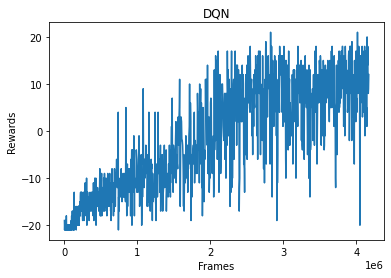

Episode:  1141
Steps:  1041734  epsilon:  0.03
Steps:  1041934  epsilon:  0.03
Steps:  1042134  epsilon:  0.03
Steps:  1042334  epsilon:  0.03
Steps:  1042534  epsilon:  0.03
Episode:  1142
Steps:  1042663  epsilon:  0.03
Steps:  1042863  epsilon:  0.03
Steps:  1043063  epsilon:  0.03
Steps:  1043263  epsilon:  0.03
Steps:  1043463  epsilon:  0.03
Steps:  1043663  epsilon:  0.03
Episode:  1143
Steps:  1043771  epsilon:  0.03
Steps:  1043971  epsilon:  0.03
Steps:  1044171  epsilon:  0.03
Steps:  1044371  epsilon:  0.03
Steps:  1044571  epsilon:  0.03
Episode:  1144
Steps:  1044586  epsilon:  0.03
Steps:  1044786  epsilon:  0.03
Steps:  1044986  epsilon:  0.03
Steps:  1045186  epsilon:  0.03
Episode:  1145
Steps:  1045250  epsilon:  0.03
Steps:  1045450  epsilon:  0.03
Steps:  1045650  epsilon:  0.03
Steps:  1045850  epsilon:  0.03
Steps:  1046050  epsilon:  0.03
Episode:  1146
Steps:  1046081  epsilon:  0.03
Steps:  1046281  epsilon:  0.03
Steps:  1046481  epsilon:  0.03
Steps:  104668

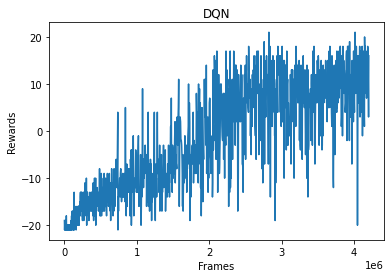

Episode:  1151
Steps:  1050394  epsilon:  0.03
Steps:  1050594  epsilon:  0.03
Steps:  1050794  epsilon:  0.03
Steps:  1050994  epsilon:  0.03
Episode:  1152
Steps:  1051048  epsilon:  0.03
Steps:  1051248  epsilon:  0.03
Steps:  1051448  epsilon:  0.03
Steps:  1051648  epsilon:  0.03
Episode:  1153
Steps:  1051828  epsilon:  0.03
Steps:  1052028  epsilon:  0.03
Steps:  1052228  epsilon:  0.03
Steps:  1052428  epsilon:  0.03
Steps:  1052628  epsilon:  0.03
Steps:  1052828  epsilon:  0.03
Episode:  1154
Steps:  1052879  epsilon:  0.03
Steps:  1053079  epsilon:  0.03
Steps:  1053279  epsilon:  0.03
Steps:  1053479  epsilon:  0.03
Steps:  1053679  epsilon:  0.03
Episode:  1155
Steps:  1053698  epsilon:  0.03
Steps:  1053898  epsilon:  0.03
Steps:  1054098  epsilon:  0.03
Steps:  1054298  epsilon:  0.03
Steps:  1054498  epsilon:  0.03
Episode:  1156
Steps:  1054658  epsilon:  0.03
Steps:  1054858  epsilon:  0.03
Steps:  1055058  epsilon:  0.03
Steps:  1055258  epsilon:  0.03
Steps:  105545

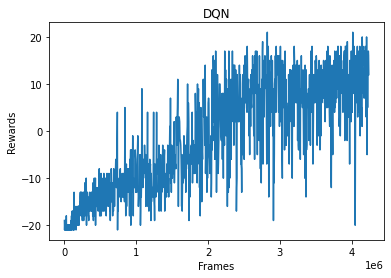

Episode:  1161
Steps:  1058733  epsilon:  0.03
Steps:  1058933  epsilon:  0.03
Steps:  1059133  epsilon:  0.03
Steps:  1059333  epsilon:  0.03
Steps:  1059533  epsilon:  0.03
Episode:  1162
Steps:  1059592  epsilon:  0.03
Steps:  1059792  epsilon:  0.03
Steps:  1059992  epsilon:  0.03
Steps:  1060192  epsilon:  0.03
Episode:  1163
Steps:  1060373  epsilon:  0.03
Steps:  1060573  epsilon:  0.03
Steps:  1060773  epsilon:  0.03
Steps:  1060973  epsilon:  0.03
Steps:  1061173  epsilon:  0.03
Episode:  1164
Steps:  1061180  epsilon:  0.03
Steps:  1061380  epsilon:  0.03
Steps:  1061580  epsilon:  0.03
Steps:  1061780  epsilon:  0.03
Steps:  1061980  epsilon:  0.03
Steps:  1062180  epsilon:  0.03
Steps:  1062380  epsilon:  0.03
Episode:  1165
Steps:  1062426  epsilon:  0.03
Steps:  1062626  epsilon:  0.03
Steps:  1062826  epsilon:  0.03
Steps:  1063026  epsilon:  0.03
Steps:  1063226  epsilon:  0.03
Episode:  1166
Steps:  1063245  epsilon:  0.03
Steps:  1063445  epsilon:  0.03
Steps:  106364

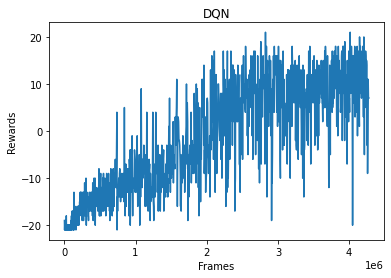

Episode:  1171
Steps:  1068281  epsilon:  0.03
Steps:  1068481  epsilon:  0.03
Steps:  1068681  epsilon:  0.03
Steps:  1068881  epsilon:  0.03
Steps:  1069081  epsilon:  0.03
Steps:  1069281  epsilon:  0.03
Episode:  1172
Steps:  1069380  epsilon:  0.03
Steps:  1069580  epsilon:  0.03
Steps:  1069780  epsilon:  0.03
Steps:  1069980  epsilon:  0.03
Episode:  1173
Steps:  1070096  epsilon:  0.03
Steps:  1070296  epsilon:  0.03
Steps:  1070496  epsilon:  0.03
Steps:  1070696  epsilon:  0.03
Steps:  1070896  epsilon:  0.03
Steps:  1071096  epsilon:  0.03
Episode:  1174
Steps:  1071232  epsilon:  0.03
Steps:  1071432  epsilon:  0.03
Steps:  1071632  epsilon:  0.03
Steps:  1071832  epsilon:  0.03
Steps:  1072032  epsilon:  0.03
Episode:  1175
Steps:  1072153  epsilon:  0.03
Steps:  1072353  epsilon:  0.03
Steps:  1072553  epsilon:  0.03
Steps:  1072753  epsilon:  0.03
Steps:  1072953  epsilon:  0.03
Steps:  1073153  epsilon:  0.03
Episode:  1176
Steps:  1073232  epsilon:  0.03
Steps:  107343

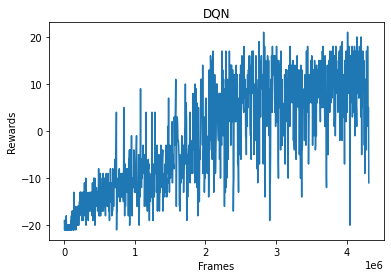

Episode:  1181
Steps:  1078078  epsilon:  0.03
Steps:  1078278  epsilon:  0.03
Steps:  1078478  epsilon:  0.03
Steps:  1078678  epsilon:  0.03
Steps:  1078878  epsilon:  0.03
Steps:  1079078  epsilon:  0.03
Episode:  1182
Steps:  1079098  epsilon:  0.03
Steps:  1079298  epsilon:  0.03
Steps:  1079498  epsilon:  0.03
Steps:  1079698  epsilon:  0.03
Episode:  1183
Steps:  1079873  epsilon:  0.03
Steps:  1080073  epsilon:  0.03
Steps:  1080273  epsilon:  0.03
Steps:  1080473  epsilon:  0.03
Steps:  1080673  epsilon:  0.03
Episode:  1184
Steps:  1080703  epsilon:  0.03
Steps:  1080903  epsilon:  0.03
Steps:  1081103  epsilon:  0.03
Steps:  1081303  epsilon:  0.03
Steps:  1081503  epsilon:  0.03
Episode:  1185
Steps:  1081690  epsilon:  0.03
Steps:  1081890  epsilon:  0.03
Steps:  1082090  epsilon:  0.03
Steps:  1082290  epsilon:  0.03
Steps:  1082490  epsilon:  0.03
Episode:  1186
Steps:  1082562  epsilon:  0.03
Steps:  1082762  epsilon:  0.03
Steps:  1082962  epsilon:  0.03
Steps:  108316

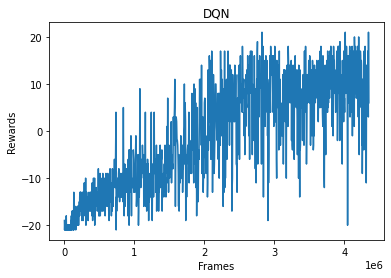

Episode:  1191
Steps:  1087107  epsilon:  0.03
Steps:  1087307  epsilon:  0.03
Steps:  1087507  epsilon:  0.03
Steps:  1087707  epsilon:  0.03
Steps:  1087907  epsilon:  0.03
Steps:  1088107  epsilon:  0.03
Episode:  1192
Steps:  1088139  epsilon:  0.03
Steps:  1088339  epsilon:  0.03
Steps:  1088539  epsilon:  0.03
Steps:  1088739  epsilon:  0.03
Steps:  1088939  epsilon:  0.03
Steps:  1089139  epsilon:  0.03
Episode:  1193
Steps:  1089172  epsilon:  0.03
Steps:  1089372  epsilon:  0.03
Steps:  1089572  epsilon:  0.03
Steps:  1089772  epsilon:  0.03
Steps:  1089972  epsilon:  0.03
Steps:  1090172  epsilon:  0.03
Episode:  1194
Steps:  1090274  epsilon:  0.03
Steps:  1090474  epsilon:  0.03
Steps:  1090674  epsilon:  0.03
Steps:  1090874  epsilon:  0.03
Steps:  1091074  epsilon:  0.03
Steps:  1091274  epsilon:  0.03
Episode:  1195
Steps:  1091363  epsilon:  0.03
Steps:  1091563  epsilon:  0.03
Steps:  1091763  epsilon:  0.03
Steps:  1091963  epsilon:  0.03
Steps:  1092163  epsilon:  0.

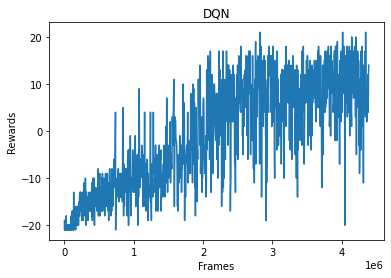

Episode:  1201
Steps:  1097394  epsilon:  0.03
Steps:  1097594  epsilon:  0.03
Steps:  1097794  epsilon:  0.03
Steps:  1097994  epsilon:  0.03
Episode:  1202
Steps:  1098134  epsilon:  0.03
Steps:  1098334  epsilon:  0.03
Steps:  1098534  epsilon:  0.03
Steps:  1098734  epsilon:  0.03
Steps:  1098934  epsilon:  0.03
Episode:  1203
Steps:  1099124  epsilon:  0.03
Steps:  1099324  epsilon:  0.03
Steps:  1099524  epsilon:  0.03
Steps:  1099724  epsilon:  0.03
Steps:  1099924  epsilon:  0.03
Steps:  1100124  epsilon:  0.03
Episode:  1204
Steps:  1100128  epsilon:  0.03
Steps:  1100328  epsilon:  0.03
Steps:  1100528  epsilon:  0.03
Steps:  1100728  epsilon:  0.03
Episode:  1205
Steps:  1100838  epsilon:  0.03
Steps:  1101038  epsilon:  0.03
Steps:  1101238  epsilon:  0.03
Steps:  1101438  epsilon:  0.03
Episode:  1206
Steps:  1101624  epsilon:  0.03
Steps:  1101824  epsilon:  0.03
Steps:  1102024  epsilon:  0.03
Steps:  1102224  epsilon:  0.03
Episode:  1207
Steps:  1102314  epsilon:  0.03

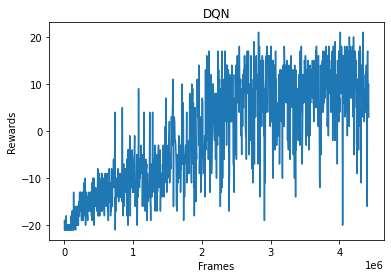

Episode:  1211
Steps:  1106504  epsilon:  0.03
Steps:  1106704  epsilon:  0.03
Steps:  1106904  epsilon:  0.03
Steps:  1107104  epsilon:  0.03
Steps:  1107304  epsilon:  0.03
Episode:  1212
Steps:  1107444  epsilon:  0.03
Steps:  1107644  epsilon:  0.03
Steps:  1107844  epsilon:  0.03
Steps:  1108044  epsilon:  0.03
Episode:  1213
Steps:  1108153  epsilon:  0.03
Steps:  1108353  epsilon:  0.03
Steps:  1108553  epsilon:  0.03
Steps:  1108753  epsilon:  0.03
Steps:  1108953  epsilon:  0.03
Episode:  1214
Steps:  1108974  epsilon:  0.03
Steps:  1109174  epsilon:  0.03
Steps:  1109374  epsilon:  0.03
Episode:  1215
Steps:  1109532  epsilon:  0.03
Steps:  1109732  epsilon:  0.03
Steps:  1109932  epsilon:  0.03
Steps:  1110132  epsilon:  0.03
Steps:  1110332  epsilon:  0.03
Steps:  1110532  epsilon:  0.03
Episode:  1216
Steps:  1110677  epsilon:  0.03
Steps:  1110877  epsilon:  0.03
Steps:  1111077  epsilon:  0.03
Steps:  1111277  epsilon:  0.03
Episode:  1217
Steps:  1111307  epsilon:  0.03

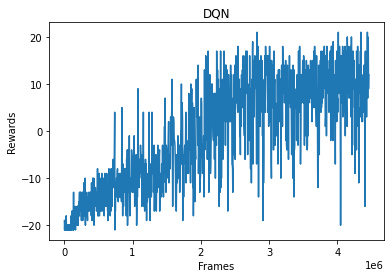

Episode:  1221
Steps:  1114617  epsilon:  0.03
Steps:  1114817  epsilon:  0.03
Steps:  1115017  epsilon:  0.03
Steps:  1115217  epsilon:  0.03
Steps:  1115417  epsilon:  0.03
Episode:  1222
Steps:  1115561  epsilon:  0.03
Steps:  1115761  epsilon:  0.03
Steps:  1115961  epsilon:  0.03
Steps:  1116161  epsilon:  0.03
Steps:  1116361  epsilon:  0.03
Episode:  1223
Steps:  1116469  epsilon:  0.03
Steps:  1116669  epsilon:  0.03
Steps:  1116869  epsilon:  0.03
Steps:  1117069  epsilon:  0.03
Steps:  1117269  epsilon:  0.03
Episode:  1224
Steps:  1117389  epsilon:  0.03
Steps:  1117589  epsilon:  0.03
Steps:  1117789  epsilon:  0.03
Steps:  1117989  epsilon:  0.03
Steps:  1118189  epsilon:  0.03
Episode:  1225
Steps:  1118252  epsilon:  0.03
Steps:  1118452  epsilon:  0.03
Steps:  1118652  epsilon:  0.03
Steps:  1118852  epsilon:  0.03
Steps:  1119052  epsilon:  0.03
Episode:  1226
Steps:  1119244  epsilon:  0.03
Steps:  1119444  epsilon:  0.03
Steps:  1119644  epsilon:  0.03
Steps:  111984

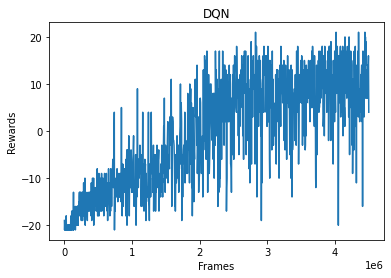

Episode:  1231
Steps:  1123768  epsilon:  0.03
Steps:  1123968  epsilon:  0.03
Steps:  1124168  epsilon:  0.03
Steps:  1124368  epsilon:  0.03
Steps:  1124568  epsilon:  0.03
Steps:  1124768  epsilon:  0.03
Episode:  1232
Steps:  1124839  epsilon:  0.03
Steps:  1125039  epsilon:  0.03
Steps:  1125239  epsilon:  0.03
Steps:  1125439  epsilon:  0.03
Steps:  1125639  epsilon:  0.03
Steps:  1125839  epsilon:  0.03
Steps:  1126039  epsilon:  0.03
Episode:  1233
Steps:  1126212  epsilon:  0.03
Steps:  1126412  epsilon:  0.03
Steps:  1126612  epsilon:  0.03
Steps:  1126812  epsilon:  0.03
Steps:  1127012  epsilon:  0.03
Steps:  1127212  epsilon:  0.03
Episode:  1234
Steps:  1127255  epsilon:  0.03
Steps:  1127455  epsilon:  0.03
Steps:  1127655  epsilon:  0.03
Steps:  1127855  epsilon:  0.03
Steps:  1128055  epsilon:  0.03
Episode:  1235
Steps:  1128120  epsilon:  0.03
Steps:  1128320  epsilon:  0.03
Steps:  1128520  epsilon:  0.03
Steps:  1128720  epsilon:  0.03
Steps:  1128920  epsilon:  0.

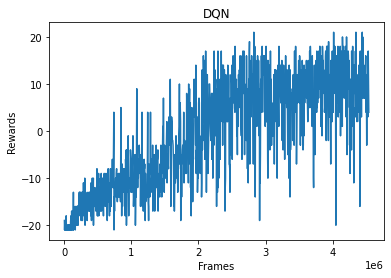

Episode:  1241
Steps:  1133876  epsilon:  0.03
Steps:  1134076  epsilon:  0.03
Steps:  1134276  epsilon:  0.03
Steps:  1134476  epsilon:  0.03
Steps:  1134676  epsilon:  0.03
Episode:  1242
Steps:  1134694  epsilon:  0.03
Steps:  1134894  epsilon:  0.03
Steps:  1135094  epsilon:  0.03
Steps:  1135294  epsilon:  0.03
Steps:  1135494  epsilon:  0.03
Steps:  1135694  epsilon:  0.03
Episode:  1243
Steps:  1135785  epsilon:  0.03
Steps:  1135985  epsilon:  0.03
Steps:  1136185  epsilon:  0.03
Steps:  1136385  epsilon:  0.03
Steps:  1136585  epsilon:  0.03
Steps:  1136785  epsilon:  0.03
Steps:  1136985  epsilon:  0.03
Episode:  1244
Steps:  1137128  epsilon:  0.03
Steps:  1137328  epsilon:  0.03
Steps:  1137528  epsilon:  0.03
Steps:  1137728  epsilon:  0.03
Steps:  1137928  epsilon:  0.03
Steps:  1138128  epsilon:  0.03
Episode:  1245
Steps:  1138168  epsilon:  0.03
Steps:  1138368  epsilon:  0.03
Steps:  1138568  epsilon:  0.03
Steps:  1138768  epsilon:  0.03
Steps:  1138968  epsilon:  0.

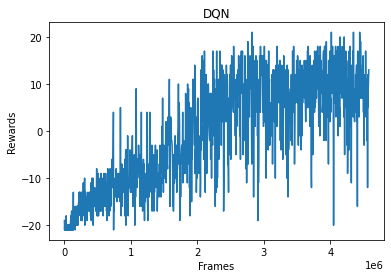

Episode:  1251
Steps:  1143648  epsilon:  0.03
Steps:  1143848  epsilon:  0.03
Steps:  1144048  epsilon:  0.03
Steps:  1144248  epsilon:  0.03
Steps:  1144448  epsilon:  0.03
Episode:  1252
Steps:  1144532  epsilon:  0.03
Steps:  1144732  epsilon:  0.03
Steps:  1144932  epsilon:  0.03
Steps:  1145132  epsilon:  0.03
Steps:  1145332  epsilon:  0.03
Episode:  1253
Steps:  1145532  epsilon:  0.03
Steps:  1145732  epsilon:  0.03
Steps:  1145932  epsilon:  0.03
Steps:  1146132  epsilon:  0.03
Steps:  1146332  epsilon:  0.03
Episode:  1254
Steps:  1146432  epsilon:  0.03
Steps:  1146632  epsilon:  0.03
Steps:  1146832  epsilon:  0.03
Steps:  1147032  epsilon:  0.03
Episode:  1255
Steps:  1147064  epsilon:  0.03
Steps:  1147264  epsilon:  0.03
Steps:  1147464  epsilon:  0.03
Steps:  1147664  epsilon:  0.03
Steps:  1147864  epsilon:  0.03
Episode:  1256
Steps:  1147973  epsilon:  0.03
Steps:  1148173  epsilon:  0.03
Steps:  1148373  epsilon:  0.03
Steps:  1148573  epsilon:  0.03
Episode:  1257

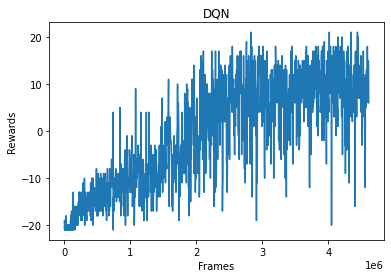

Episode:  1261
Steps:  1152463  epsilon:  0.03
Steps:  1152663  epsilon:  0.03
Steps:  1152863  epsilon:  0.03
Steps:  1153063  epsilon:  0.03
Episode:  1262
Steps:  1153249  epsilon:  0.03
Steps:  1153449  epsilon:  0.03
Steps:  1153649  epsilon:  0.03
Steps:  1153849  epsilon:  0.03
Episode:  1263
Steps:  1153987  epsilon:  0.03
Steps:  1154187  epsilon:  0.03
Steps:  1154387  epsilon:  0.03
Steps:  1154587  epsilon:  0.03
Steps:  1154787  epsilon:  0.03
Episode:  1264
Steps:  1154870  epsilon:  0.03
Steps:  1155070  epsilon:  0.03
Steps:  1155270  epsilon:  0.03
Steps:  1155470  epsilon:  0.03
Steps:  1155670  epsilon:  0.03
Steps:  1155870  epsilon:  0.03
Episode:  1265
Steps:  1155946  epsilon:  0.03
Steps:  1156146  epsilon:  0.03
Steps:  1156346  epsilon:  0.03
Steps:  1156546  epsilon:  0.03
Steps:  1156746  epsilon:  0.03
Episode:  1266
Steps:  1156792  epsilon:  0.03
Steps:  1156992  epsilon:  0.03
Steps:  1157192  epsilon:  0.03
Steps:  1157392  epsilon:  0.03
Steps:  115759

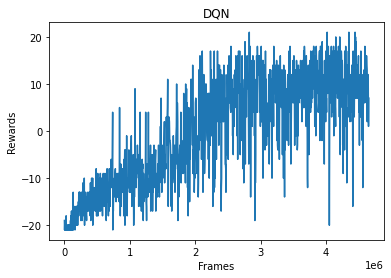

Episode:  1271
Steps:  1161900  epsilon:  0.03
Steps:  1162100  epsilon:  0.03
Steps:  1162300  epsilon:  0.03
Steps:  1162500  epsilon:  0.03
Steps:  1162700  epsilon:  0.03
Episode:  1272
Steps:  1162836  epsilon:  0.03
Steps:  1163036  epsilon:  0.03
Steps:  1163236  epsilon:  0.03
Steps:  1163436  epsilon:  0.03
Steps:  1163636  epsilon:  0.03
Episode:  1273
Steps:  1163662  epsilon:  0.03
Steps:  1163862  epsilon:  0.03
Steps:  1164062  epsilon:  0.03
Steps:  1164262  epsilon:  0.03
Steps:  1164462  epsilon:  0.03
Steps:  1164662  epsilon:  0.03
Episode:  1274
Steps:  1164684  epsilon:  0.03
Steps:  1164884  epsilon:  0.03
Steps:  1165084  epsilon:  0.03
Steps:  1165284  epsilon:  0.03
Steps:  1165484  epsilon:  0.03
Episode:  1275
Steps:  1165545  epsilon:  0.03
Steps:  1165745  epsilon:  0.03
Steps:  1165945  epsilon:  0.03
Steps:  1166145  epsilon:  0.03
Episode:  1276
Steps:  1166238  epsilon:  0.03
Steps:  1166438  epsilon:  0.03
Steps:  1166638  epsilon:  0.03
Steps:  116683

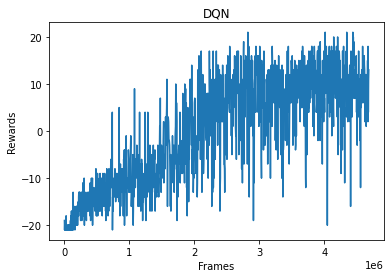

Episode:  1281
Steps:  1170771  epsilon:  0.03
Steps:  1170971  epsilon:  0.03
Steps:  1171171  epsilon:  0.03
Steps:  1171371  epsilon:  0.03
Steps:  1171571  epsilon:  0.03
Steps:  1171771  epsilon:  0.03
Episode:  1282
Steps:  1171813  epsilon:  0.03
Steps:  1172013  epsilon:  0.03
Steps:  1172213  epsilon:  0.03
Steps:  1172413  epsilon:  0.03
Steps:  1172613  epsilon:  0.03
Steps:  1172813  epsilon:  0.03
Episode:  1283
Steps:  1172861  epsilon:  0.03
Steps:  1173061  epsilon:  0.03
Steps:  1173261  epsilon:  0.03
Steps:  1173461  epsilon:  0.03
Steps:  1173661  epsilon:  0.03
Steps:  1173861  epsilon:  0.03
Episode:  1284
Steps:  1173932  epsilon:  0.03
Steps:  1174132  epsilon:  0.03
Steps:  1174332  epsilon:  0.03
Steps:  1174532  epsilon:  0.03
Steps:  1174732  epsilon:  0.03
Episode:  1285
Steps:  1174785  epsilon:  0.03
Steps:  1174985  epsilon:  0.03
Steps:  1175185  epsilon:  0.03
Steps:  1175385  epsilon:  0.03
Episode:  1286
Steps:  1175510  epsilon:  0.03
Steps:  117571

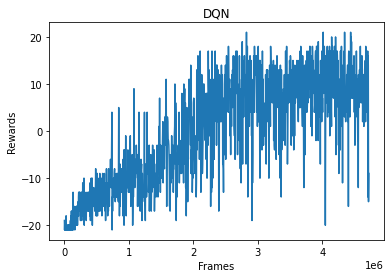

Episode:  1291
Steps:  1179779  epsilon:  0.03
Steps:  1179979  epsilon:  0.03
Steps:  1180179  epsilon:  0.03
Steps:  1180379  epsilon:  0.03
Steps:  1180579  epsilon:  0.03
Episode:  1292
Steps:  1180600  epsilon:  0.03
Steps:  1180800  epsilon:  0.03
Steps:  1181000  epsilon:  0.03
Steps:  1181200  epsilon:  0.03
Episode:  1293
Steps:  1181236  epsilon:  0.03
Steps:  1181436  epsilon:  0.03
Steps:  1181636  epsilon:  0.03
Steps:  1181836  epsilon:  0.03
Steps:  1182036  epsilon:  0.03
Episode:  1294
Steps:  1182092  epsilon:  0.03
Steps:  1182292  epsilon:  0.03
Steps:  1182492  epsilon:  0.03
Steps:  1182692  epsilon:  0.03
Steps:  1182892  epsilon:  0.03
Episode:  1295
Steps:  1183038  epsilon:  0.03
Steps:  1183238  epsilon:  0.03
Steps:  1183438  epsilon:  0.03
Steps:  1183638  epsilon:  0.03
Steps:  1183838  epsilon:  0.03
Episode:  1296
Steps:  1183901  epsilon:  0.03
Steps:  1184101  epsilon:  0.03
Steps:  1184301  epsilon:  0.03
Steps:  1184501  epsilon:  0.03
Episode:  1297

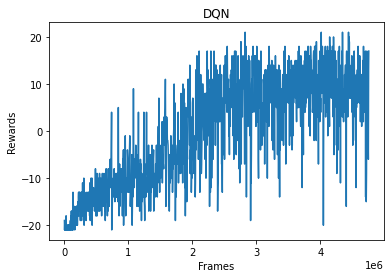

Episode:  1301
Steps:  1188652  epsilon:  0.03
Steps:  1188852  epsilon:  0.03
Steps:  1189052  epsilon:  0.03
Steps:  1189252  epsilon:  0.03
Episode:  1302
Steps:  1189434  epsilon:  0.03
Steps:  1189634  epsilon:  0.03
Steps:  1189834  epsilon:  0.03
Steps:  1190034  epsilon:  0.03
Steps:  1190234  epsilon:  0.03
Episode:  1303
Steps:  1190356  epsilon:  0.03
Steps:  1190556  epsilon:  0.03
Steps:  1190756  epsilon:  0.03
Steps:  1190956  epsilon:  0.03
Steps:  1191156  epsilon:  0.03
Steps:  1191356  epsilon:  0.03
Episode:  1304
Steps:  1191530  epsilon:  0.03
Steps:  1191730  epsilon:  0.03
Steps:  1191930  epsilon:  0.03
Steps:  1192130  epsilon:  0.03
Steps:  1192330  epsilon:  0.03
Steps:  1192530  epsilon:  0.03
Episode:  1305
Steps:  1192532  epsilon:  0.03
Steps:  1192732  epsilon:  0.03
Steps:  1192932  epsilon:  0.03
Steps:  1193132  epsilon:  0.03
Steps:  1193332  epsilon:  0.03
Episode:  1306
Steps:  1193337  epsilon:  0.03
Steps:  1193537  epsilon:  0.03
Steps:  119373

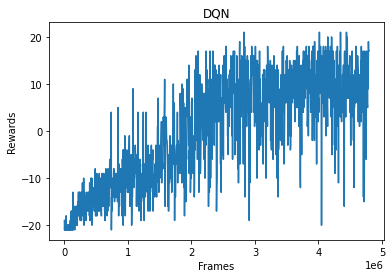

Episode:  1311
Steps:  1197254  epsilon:  0.03
Steps:  1197454  epsilon:  0.03
Steps:  1197654  epsilon:  0.03
Steps:  1197854  epsilon:  0.03
Steps:  1198054  epsilon:  0.03
Steps:  1198254  epsilon:  0.03
Episode:  1312
Steps:  1198315  epsilon:  0.03
Steps:  1198515  epsilon:  0.03
Steps:  1198715  epsilon:  0.03
Steps:  1198915  epsilon:  0.03
Steps:  1199115  epsilon:  0.03
Steps:  1199315  epsilon:  0.03
Episode:  1313
Steps:  1199344  epsilon:  0.03
Steps:  1199544  epsilon:  0.03
Steps:  1199744  epsilon:  0.03
Steps:  1199944  epsilon:  0.03
Steps:  1200144  epsilon:  0.03
Steps:  1200344  epsilon:  0.03
Episode:  1314
Steps:  1200396  epsilon:  0.03
Steps:  1200596  epsilon:  0.03
Steps:  1200796  epsilon:  0.03
Steps:  1200996  epsilon:  0.03
Steps:  1201196  epsilon:  0.03
Episode:  1315
Steps:  1201319  epsilon:  0.03
Steps:  1201519  epsilon:  0.03
Steps:  1201719  epsilon:  0.03
Steps:  1201919  epsilon:  0.03
Steps:  1202119  epsilon:  0.03
Episode:  1316
Steps:  120217

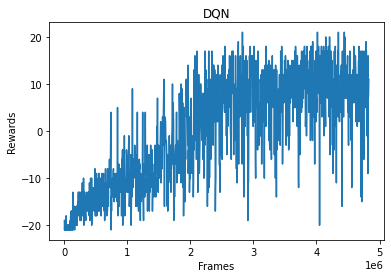

Episode:  1321
Steps:  1206514  epsilon:  0.03
Steps:  1206714  epsilon:  0.03
Steps:  1206914  epsilon:  0.03
Steps:  1207114  epsilon:  0.03
Steps:  1207314  epsilon:  0.03
Episode:  1322
Steps:  1207432  epsilon:  0.03
Steps:  1207632  epsilon:  0.03
Steps:  1207832  epsilon:  0.03
Steps:  1208032  epsilon:  0.03
Steps:  1208232  epsilon:  0.03
Episode:  1323
Steps:  1208376  epsilon:  0.03
Steps:  1208576  epsilon:  0.03
Steps:  1208776  epsilon:  0.03
Steps:  1208976  epsilon:  0.03
Steps:  1209176  epsilon:  0.03
Steps:  1209376  epsilon:  0.03
Episode:  1324
Steps:  1209419  epsilon:  0.03
Steps:  1209619  epsilon:  0.03
Steps:  1209819  epsilon:  0.03
Steps:  1210019  epsilon:  0.03
Episode:  1325
Steps:  1210127  epsilon:  0.03
Steps:  1210327  epsilon:  0.03
Steps:  1210527  epsilon:  0.03
Steps:  1210727  epsilon:  0.03
Steps:  1210927  epsilon:  0.03
Steps:  1211127  epsilon:  0.03
Episode:  1326
Steps:  1211170  epsilon:  0.03
Steps:  1211370  epsilon:  0.03
Steps:  121157

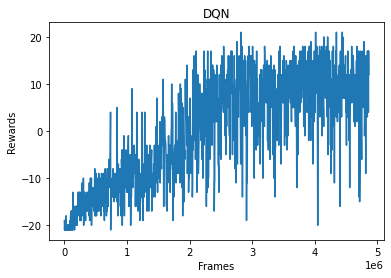

Episode:  1331
Steps:  1215287  epsilon:  0.03
Steps:  1215487  epsilon:  0.03
Steps:  1215687  epsilon:  0.03
Steps:  1215887  epsilon:  0.03
Episode:  1332
Steps:  1216024  epsilon:  0.03
Steps:  1216224  epsilon:  0.03
Steps:  1216424  epsilon:  0.03
Steps:  1216624  epsilon:  0.03
Steps:  1216824  epsilon:  0.03
Steps:  1217024  epsilon:  0.03
Steps:  1217224  epsilon:  0.03
Episode:  1333
Steps:  1217257  epsilon:  0.03
Steps:  1217457  epsilon:  0.03
Steps:  1217657  epsilon:  0.03
Steps:  1217857  epsilon:  0.03
Steps:  1218057  epsilon:  0.03
Steps:  1218257  epsilon:  0.03
Episode:  1334
Steps:  1218315  epsilon:  0.03
Steps:  1218515  epsilon:  0.03
Steps:  1218715  epsilon:  0.03
Steps:  1218915  epsilon:  0.03
Steps:  1219115  epsilon:  0.03
Steps:  1219315  epsilon:  0.03
Episode:  1335
Steps:  1219410  epsilon:  0.03
Steps:  1219610  epsilon:  0.03
Steps:  1219810  epsilon:  0.03
Steps:  1220010  epsilon:  0.03
Steps:  1220210  epsilon:  0.03
Episode:  1336
Steps:  122028

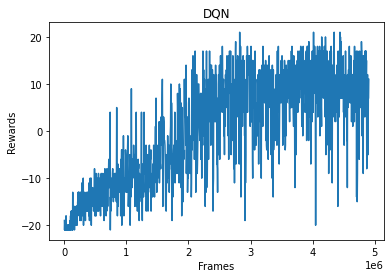

Episode:  1341
Steps:  1225379  epsilon:  0.03
Steps:  1225579  epsilon:  0.03
Steps:  1225779  epsilon:  0.03
Steps:  1225979  epsilon:  0.03
Steps:  1226179  epsilon:  0.03
Steps:  1226379  epsilon:  0.03
Episode:  1342
Steps:  1226476  epsilon:  0.03
Steps:  1226676  epsilon:  0.03
Steps:  1226876  epsilon:  0.03
Steps:  1227076  epsilon:  0.03
Steps:  1227276  epsilon:  0.03
Episode:  1343
Steps:  1227366  epsilon:  0.03
Steps:  1227566  epsilon:  0.03
Steps:  1227766  epsilon:  0.03
Steps:  1227966  epsilon:  0.03
Steps:  1228166  epsilon:  0.03
Episode:  1344
Steps:  1228208  epsilon:  0.03
Steps:  1228408  epsilon:  0.03
Steps:  1228608  epsilon:  0.03
Steps:  1228808  epsilon:  0.03
Episode:  1345
Steps:  1228997  epsilon:  0.03
Steps:  1229197  epsilon:  0.03
Steps:  1229397  epsilon:  0.03
Steps:  1229597  epsilon:  0.03
Steps:  1229797  epsilon:  0.03
Steps:  1229997  epsilon:  0.03
Episode:  1346
Steps:  1230080  epsilon:  0.03
Steps:  1230280  epsilon:  0.03
Steps:  123048

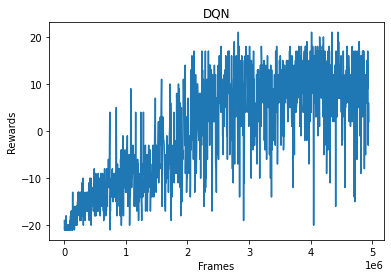

Episode:  1351
Steps:  1235162  epsilon:  0.03
Steps:  1235362  epsilon:  0.03
Steps:  1235562  epsilon:  0.03
Steps:  1235762  epsilon:  0.03
Steps:  1235962  epsilon:  0.03
Steps:  1236162  epsilon:  0.03
Episode:  1352
Steps:  1236197  epsilon:  0.03
Steps:  1236397  epsilon:  0.03
Steps:  1236597  epsilon:  0.03
Steps:  1236797  epsilon:  0.03
Steps:  1236997  epsilon:  0.03
Steps:  1237197  epsilon:  0.03
Episode:  1353
Steps:  1237286  epsilon:  0.03
Steps:  1237486  epsilon:  0.03
Steps:  1237686  epsilon:  0.03
Steps:  1237886  epsilon:  0.03
Steps:  1238086  epsilon:  0.03
Steps:  1238286  epsilon:  0.03
Episode:  1354
Steps:  1238415  epsilon:  0.03
Steps:  1238615  epsilon:  0.03
Steps:  1238815  epsilon:  0.03
Steps:  1239015  epsilon:  0.03
Steps:  1239215  epsilon:  0.03
Steps:  1239415  epsilon:  0.03
Episode:  1355
Steps:  1239490  epsilon:  0.03
Steps:  1239690  epsilon:  0.03
Steps:  1239890  epsilon:  0.03
Steps:  1240090  epsilon:  0.03
Steps:  1240290  epsilon:  0.

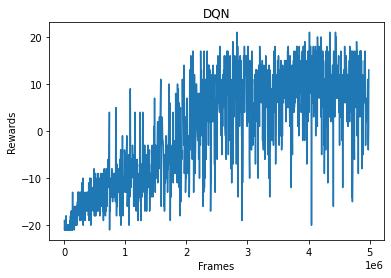

Episode:  1361
Steps:  1245787  epsilon:  0.03
Steps:  1245987  epsilon:  0.03
Steps:  1246187  epsilon:  0.03
Steps:  1246387  epsilon:  0.03
Episode:  1362
Steps:  1246519  epsilon:  0.03
Steps:  1246719  epsilon:  0.03
Steps:  1246919  epsilon:  0.03
Steps:  1247119  epsilon:  0.03
Steps:  1247319  epsilon:  0.03
Episode:  1363
Steps:  1247519  epsilon:  0.03
Steps:  1247719  epsilon:  0.03
Steps:  1247919  epsilon:  0.03
Steps:  1248119  epsilon:  0.03
Steps:  1248319  epsilon:  0.03
Steps:  1248519  epsilon:  0.03
Episode:  1364
Steps:  1248553  epsilon:  0.03
Steps:  1248753  epsilon:  0.03
Steps:  1248953  epsilon:  0.03
Steps:  1249153  epsilon:  0.03
Steps:  1249353  epsilon:  0.03
Steps:  1249553  epsilon:  0.03
Episode:  1365
Steps:  1249567  epsilon:  0.03
Steps:  1249767  epsilon:  0.03
Steps:  1249967  epsilon:  0.03
Steps:  1250167  epsilon:  0.03
Episode:  1366
Steps:  1250176  epsilon:  0.03
Steps:  1250376  epsilon:  0.03
Steps:  1250576  epsilon:  0.03
Steps:  125077

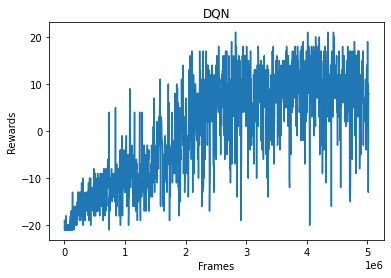

Episode:  1371
Steps:  1255044  epsilon:  0.03
Steps:  1255244  epsilon:  0.03
Steps:  1255444  epsilon:  0.03
Steps:  1255644  epsilon:  0.03
Episode:  1372
Steps:  1255717  epsilon:  0.03
Steps:  1255917  epsilon:  0.03
Steps:  1256117  epsilon:  0.03
Steps:  1256317  epsilon:  0.03
Steps:  1256517  epsilon:  0.03
Steps:  1256717  epsilon:  0.03
Episode:  1373
Steps:  1256791  epsilon:  0.03
Steps:  1256991  epsilon:  0.03
Steps:  1257191  epsilon:  0.03
Steps:  1257391  epsilon:  0.03
Episode:  1374
Steps:  1257544  epsilon:  0.03
Steps:  1257744  epsilon:  0.03
Steps:  1257944  epsilon:  0.03
Steps:  1258144  epsilon:  0.03
Steps:  1258344  epsilon:  0.03
Steps:  1258544  epsilon:  0.03
Episode:  1375
Steps:  1258720  epsilon:  0.03
Steps:  1258920  epsilon:  0.03
Steps:  1259120  epsilon:  0.03
Steps:  1259320  epsilon:  0.03
Steps:  1259520  epsilon:  0.03
Steps:  1259720  epsilon:  0.03
Episode:  1376
Steps:  1259767  epsilon:  0.03
Steps:  1259967  epsilon:  0.03
Steps:  126016

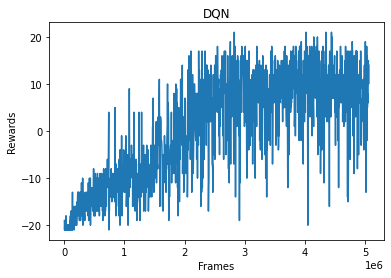

Episode:  1381
Steps:  1264472  epsilon:  0.03
Steps:  1264672  epsilon:  0.03
Steps:  1264872  epsilon:  0.03
Steps:  1265072  epsilon:  0.03
Steps:  1265272  epsilon:  0.03
Steps:  1265472  epsilon:  0.03
Episode:  1382
Steps:  1265488  epsilon:  0.03
Steps:  1265688  epsilon:  0.03
Steps:  1265888  epsilon:  0.03
Steps:  1266088  epsilon:  0.03
Steps:  1266288  epsilon:  0.03
Episode:  1383
Steps:  1266324  epsilon:  0.03
Steps:  1266524  epsilon:  0.03
Steps:  1266724  epsilon:  0.03
Steps:  1266924  epsilon:  0.03
Episode:  1384
Steps:  1267006  epsilon:  0.03
Steps:  1267206  epsilon:  0.03
Steps:  1267406  epsilon:  0.03
Steps:  1267606  epsilon:  0.03
Steps:  1267806  epsilon:  0.03
Episode:  1385
Steps:  1267927  epsilon:  0.03
Steps:  1268127  epsilon:  0.03
Steps:  1268327  epsilon:  0.03
Steps:  1268527  epsilon:  0.03
Steps:  1268727  epsilon:  0.03
Episode:  1386
Steps:  1268894  epsilon:  0.03
Steps:  1269094  epsilon:  0.03
Steps:  1269294  epsilon:  0.03
Steps:  126949

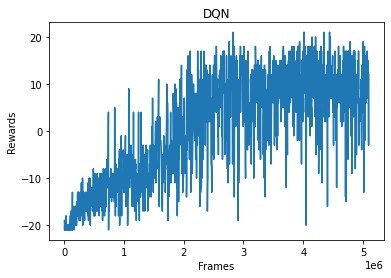

Episode:  1391
Steps:  1273649  epsilon:  0.03
Steps:  1273849  epsilon:  0.03
Steps:  1274049  epsilon:  0.03
Steps:  1274249  epsilon:  0.03
Steps:  1274449  epsilon:  0.03
Steps:  1274649  epsilon:  0.03
Episode:  1392
Steps:  1274692  epsilon:  0.03
Steps:  1274892  epsilon:  0.03
Steps:  1275092  epsilon:  0.03
Steps:  1275292  epsilon:  0.03
Steps:  1275492  epsilon:  0.03
Episode:  1393
Steps:  1275518  epsilon:  0.03
Steps:  1275718  epsilon:  0.03
Steps:  1275918  epsilon:  0.03
Steps:  1276118  epsilon:  0.03
Episode:  1394
Steps:  1276250  epsilon:  0.03
Steps:  1276450  epsilon:  0.03
Steps:  1276650  epsilon:  0.03
Steps:  1276850  epsilon:  0.03
Steps:  1277050  epsilon:  0.03
Episode:  1395
Steps:  1277180  epsilon:  0.03
Steps:  1277380  epsilon:  0.03
Steps:  1277580  epsilon:  0.03
Steps:  1277780  epsilon:  0.03
Steps:  1277980  epsilon:  0.03
Steps:  1278180  epsilon:  0.03
Episode:  1396
Steps:  1278274  epsilon:  0.03
Steps:  1278474  epsilon:  0.03
Steps:  127867

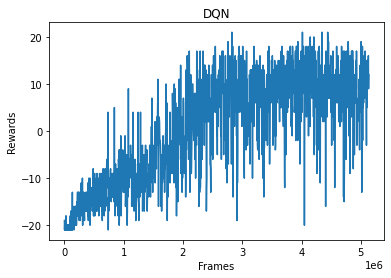

Episode:  1401
Steps:  1282578  epsilon:  0.03
Steps:  1282778  epsilon:  0.03
Steps:  1282978  epsilon:  0.03
Steps:  1283178  epsilon:  0.03
Steps:  1283378  epsilon:  0.03
Episode:  1402
Steps:  1283411  epsilon:  0.03
Steps:  1283611  epsilon:  0.03
Steps:  1283811  epsilon:  0.03
Steps:  1284011  epsilon:  0.03
Steps:  1284211  epsilon:  0.03
Steps:  1284411  epsilon:  0.03
Episode:  1403
Steps:  1284590  epsilon:  0.03
Steps:  1284790  epsilon:  0.03
Steps:  1284990  epsilon:  0.03
Steps:  1285190  epsilon:  0.03
Steps:  1285390  epsilon:  0.03
Steps:  1285590  epsilon:  0.03
Episode:  1404
Steps:  1285621  epsilon:  0.03
Steps:  1285821  epsilon:  0.03
Steps:  1286021  epsilon:  0.03
Steps:  1286221  epsilon:  0.03
Steps:  1286421  epsilon:  0.03
Episode:  1405
Steps:  1286523  epsilon:  0.03
Steps:  1286723  epsilon:  0.03
Steps:  1286923  epsilon:  0.03
Steps:  1287123  epsilon:  0.03
Steps:  1287323  epsilon:  0.03
Episode:  1406
Steps:  1287508  epsilon:  0.03
Steps:  128770

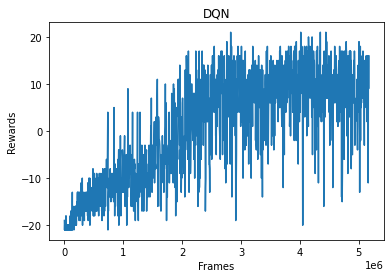

Episode:  1411
Steps:  1291672  epsilon:  0.03
Steps:  1291872  epsilon:  0.03
Steps:  1292072  epsilon:  0.03
Steps:  1292272  epsilon:  0.03
Steps:  1292472  epsilon:  0.03
Steps:  1292672  epsilon:  0.03
Steps:  1292872  epsilon:  0.03
Episode:  1412
Steps:  1292954  epsilon:  0.03
Steps:  1293154  epsilon:  0.03
Steps:  1293354  epsilon:  0.03
Steps:  1293554  epsilon:  0.03
Steps:  1293754  epsilon:  0.03
Episode:  1413
Steps:  1293820  epsilon:  0.03
Steps:  1294020  epsilon:  0.03
Steps:  1294220  epsilon:  0.03
Steps:  1294420  epsilon:  0.03
Steps:  1294620  epsilon:  0.03
Steps:  1294820  epsilon:  0.03
Episode:  1414
Steps:  1294953  epsilon:  0.03
Steps:  1295153  epsilon:  0.03
Steps:  1295353  epsilon:  0.03
Steps:  1295553  epsilon:  0.03
Steps:  1295753  epsilon:  0.03
Episode:  1415
Steps:  1295875  epsilon:  0.03
Steps:  1296075  epsilon:  0.03
Steps:  1296275  epsilon:  0.03
Steps:  1296475  epsilon:  0.03
Steps:  1296675  epsilon:  0.03
Steps:  1296875  epsilon:  0.

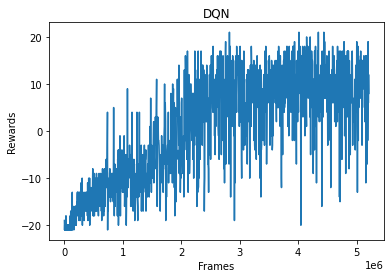

Episode:  1421
Steps:  1301620  epsilon:  0.03
Steps:  1301820  epsilon:  0.03
Steps:  1302020  epsilon:  0.03
Steps:  1302220  epsilon:  0.03
Steps:  1302420  epsilon:  0.03
Steps:  1302620  epsilon:  0.03
Episode:  1422
Steps:  1302668  epsilon:  0.03
Steps:  1302868  epsilon:  0.03
Steps:  1303068  epsilon:  0.03
Steps:  1303268  epsilon:  0.03
Episode:  1423
Steps:  1303281  epsilon:  0.03
Steps:  1303481  epsilon:  0.03
Steps:  1303681  epsilon:  0.03
Steps:  1303881  epsilon:  0.03
Episode:  1424
Steps:  1304038  epsilon:  0.03
Steps:  1304238  epsilon:  0.03
Steps:  1304438  epsilon:  0.03
Steps:  1304638  epsilon:  0.03
Steps:  1304838  epsilon:  0.03
Steps:  1305038  epsilon:  0.03
Episode:  1425
Steps:  1305099  epsilon:  0.03
Steps:  1305299  epsilon:  0.03
Steps:  1305499  epsilon:  0.03
Steps:  1305699  epsilon:  0.03
Episode:  1426
Steps:  1305854  epsilon:  0.03
Steps:  1306054  epsilon:  0.03
Steps:  1306254  epsilon:  0.03
Steps:  1306454  epsilon:  0.03
Steps:  130665

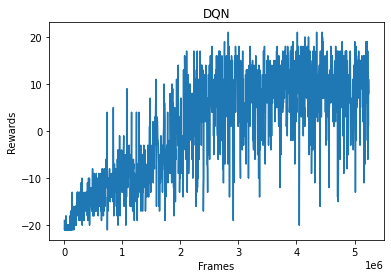

Episode:  1431
Steps:  1310550  epsilon:  0.03
Steps:  1310750  epsilon:  0.03
Steps:  1310950  epsilon:  0.03
Steps:  1311150  epsilon:  0.03
Steps:  1311350  epsilon:  0.03
Episode:  1432
Steps:  1311455  epsilon:  0.03
Steps:  1311655  epsilon:  0.03
Steps:  1311855  epsilon:  0.03
Steps:  1312055  epsilon:  0.03
Steps:  1312255  epsilon:  0.03
Episode:  1433
Steps:  1312433  epsilon:  0.03
Steps:  1312633  epsilon:  0.03
Steps:  1312833  epsilon:  0.03
Steps:  1313033  epsilon:  0.03
Steps:  1313233  epsilon:  0.03
Episode:  1434
Steps:  1313392  epsilon:  0.03
Steps:  1313592  epsilon:  0.03
Steps:  1313792  epsilon:  0.03
Steps:  1313992  epsilon:  0.03
Steps:  1314192  epsilon:  0.03
Episode:  1435
Steps:  1314334  epsilon:  0.03
Steps:  1314534  epsilon:  0.03
Steps:  1314734  epsilon:  0.03
Steps:  1314934  epsilon:  0.03
Steps:  1315134  epsilon:  0.03
Steps:  1315334  epsilon:  0.03
Episode:  1436
Steps:  1315346  epsilon:  0.03
Steps:  1315546  epsilon:  0.03
Steps:  131574

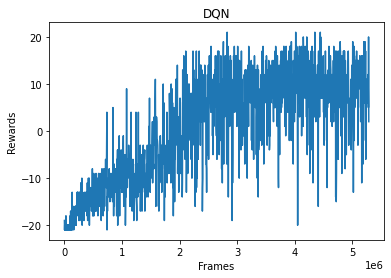

Episode:  1441
Steps:  1319776  epsilon:  0.03
Steps:  1319976  epsilon:  0.03
Steps:  1320176  epsilon:  0.03
Steps:  1320376  epsilon:  0.03
Steps:  1320576  epsilon:  0.03
Steps:  1320776  epsilon:  0.03
Steps:  1320976  epsilon:  0.03
Episode:  1442
Steps:  1321154  epsilon:  0.03
Steps:  1321354  epsilon:  0.03
Steps:  1321554  epsilon:  0.03
Steps:  1321754  epsilon:  0.03
Steps:  1321954  epsilon:  0.03
Steps:  1322154  epsilon:  0.03
Steps:  1322354  epsilon:  0.03
Episode:  1443
Steps:  1322392  epsilon:  0.03
Steps:  1322592  epsilon:  0.03
Steps:  1322792  epsilon:  0.03
Steps:  1322992  epsilon:  0.03
Episode:  1444
Steps:  1323159  epsilon:  0.03
Steps:  1323359  epsilon:  0.03
Steps:  1323559  epsilon:  0.03
Steps:  1323759  epsilon:  0.03
Steps:  1323959  epsilon:  0.03
Steps:  1324159  epsilon:  0.03
Episode:  1445
Steps:  1324253  epsilon:  0.03
Steps:  1324453  epsilon:  0.03
Steps:  1324653  epsilon:  0.03
Steps:  1324853  epsilon:  0.03
Steps:  1325053  epsilon:  0.

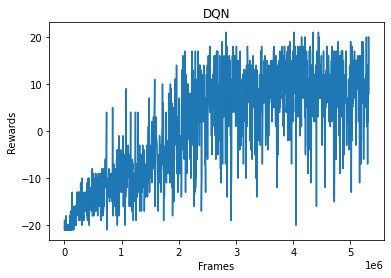

Episode:  1451
Steps:  1329376  epsilon:  0.03
Steps:  1329576  epsilon:  0.03
Steps:  1329776  epsilon:  0.03
Steps:  1329976  epsilon:  0.03
Episode:  1452
Steps:  1330146  epsilon:  0.03
Steps:  1330346  epsilon:  0.03
Steps:  1330546  epsilon:  0.03
Steps:  1330746  epsilon:  0.03
Episode:  1453
Steps:  1330922  epsilon:  0.03
Steps:  1331122  epsilon:  0.03
Steps:  1331322  epsilon:  0.03
Steps:  1331522  epsilon:  0.03
Episode:  1454
Steps:  1331628  epsilon:  0.03
Steps:  1331828  epsilon:  0.03
Steps:  1332028  epsilon:  0.03
Steps:  1332228  epsilon:  0.03
Steps:  1332428  epsilon:  0.03
Episode:  1455
Steps:  1332453  epsilon:  0.03
Steps:  1332653  epsilon:  0.03
Steps:  1332853  epsilon:  0.03
Steps:  1333053  epsilon:  0.03
Steps:  1333253  epsilon:  0.03
Steps:  1333453  epsilon:  0.03
Steps:  1333653  epsilon:  0.03
Episode:  1456
Steps:  1333690  epsilon:  0.03
Steps:  1333890  epsilon:  0.03
Steps:  1334090  epsilon:  0.03
Steps:  1334290  epsilon:  0.03
Steps:  133449

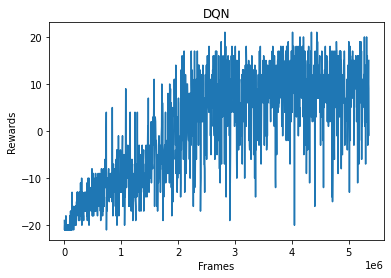

Episode:  1461
Steps:  1338128  epsilon:  0.03
Steps:  1338328  epsilon:  0.03
Steps:  1338528  epsilon:  0.03
Steps:  1338728  epsilon:  0.03
Steps:  1338928  epsilon:  0.03
Episode:  1462
Steps:  1339073  epsilon:  0.03
Steps:  1339273  epsilon:  0.03
Steps:  1339473  epsilon:  0.03
Steps:  1339673  epsilon:  0.03
Steps:  1339873  epsilon:  0.03
Steps:  1340073  epsilon:  0.03
Episode:  1463
Steps:  1340161  epsilon:  0.03
Steps:  1340361  epsilon:  0.03
Steps:  1340561  epsilon:  0.03
Steps:  1340761  epsilon:  0.03
Steps:  1340961  epsilon:  0.03
Episode:  1464
Steps:  1341093  epsilon:  0.03
Steps:  1341293  epsilon:  0.03
Steps:  1341493  epsilon:  0.03
Steps:  1341693  epsilon:  0.03
Steps:  1341893  epsilon:  0.03
Episode:  1465
Steps:  1341991  epsilon:  0.03
Steps:  1342191  epsilon:  0.03
Steps:  1342391  epsilon:  0.03
Steps:  1342591  epsilon:  0.03
Steps:  1342791  epsilon:  0.03
Steps:  1342991  epsilon:  0.03
Episode:  1466
Steps:  1343121  epsilon:  0.03
Steps:  134332

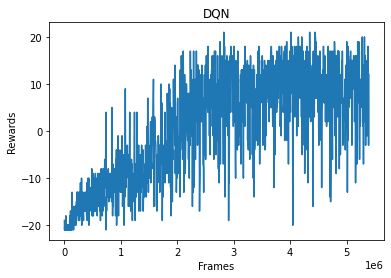

Episode:  1471
Steps:  1347706  epsilon:  0.03
Steps:  1347906  epsilon:  0.03
Steps:  1348106  epsilon:  0.03
Steps:  1348306  epsilon:  0.03
Steps:  1348506  epsilon:  0.03
Episode:  1472
Steps:  1348656  epsilon:  0.03
Steps:  1348856  epsilon:  0.03
Steps:  1349056  epsilon:  0.03
Steps:  1349256  epsilon:  0.03
Steps:  1349456  epsilon:  0.03
Steps:  1349656  epsilon:  0.03
Episode:  1473
Steps:  1349836  epsilon:  0.03
Steps:  1350036  epsilon:  0.03
Steps:  1350236  epsilon:  0.03
Steps:  1350436  epsilon:  0.03
Steps:  1350636  epsilon:  0.03
Steps:  1350836  epsilon:  0.03
Episode:  1474
Steps:  1350888  epsilon:  0.03
Steps:  1351088  epsilon:  0.03
Steps:  1351288  epsilon:  0.03
Steps:  1351488  epsilon:  0.03
Steps:  1351688  epsilon:  0.03
Episode:  1475
Steps:  1351748  epsilon:  0.03
Steps:  1351948  epsilon:  0.03
Steps:  1352148  epsilon:  0.03
Steps:  1352348  epsilon:  0.03
Steps:  1352548  epsilon:  0.03
Steps:  1352748  epsilon:  0.03
Steps:  1352948  epsilon:  0.

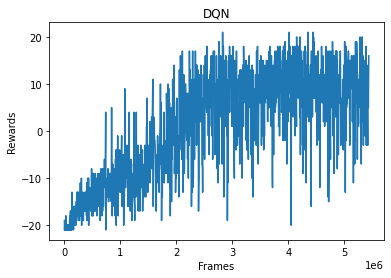

Episode:  1481
Steps:  1357738  epsilon:  0.03
Steps:  1357938  epsilon:  0.03
Steps:  1358138  epsilon:  0.03
Steps:  1358338  epsilon:  0.03
Episode:  1482
Steps:  1358508  epsilon:  0.03
Steps:  1358708  epsilon:  0.03
Steps:  1358908  epsilon:  0.03
Steps:  1359108  epsilon:  0.03
Steps:  1359308  epsilon:  0.03
Episode:  1483
Steps:  1359315  epsilon:  0.03
Steps:  1359515  epsilon:  0.03
Steps:  1359715  epsilon:  0.03
Steps:  1359915  epsilon:  0.03
Steps:  1360115  epsilon:  0.03
Steps:  1360315  epsilon:  0.03
Episode:  1484
Steps:  1360327  epsilon:  0.03
Steps:  1360527  epsilon:  0.03
Steps:  1360727  epsilon:  0.03
Steps:  1360927  epsilon:  0.03
Steps:  1361127  epsilon:  0.03
Steps:  1361327  epsilon:  0.03
Episode:  1485
Steps:  1361476  epsilon:  0.03
Steps:  1361676  epsilon:  0.03
Steps:  1361876  epsilon:  0.03
Steps:  1362076  epsilon:  0.03
Steps:  1362276  epsilon:  0.03
Steps:  1362476  epsilon:  0.03
Episode:  1486
Steps:  1362642  epsilon:  0.03
Steps:  136284

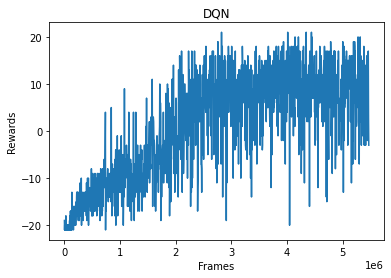

Episode:  1491
Steps:  1367062  epsilon:  0.03
Steps:  1367262  epsilon:  0.03
Steps:  1367462  epsilon:  0.03
Steps:  1367662  epsilon:  0.03
Episode:  1492
Steps:  1367776  epsilon:  0.03
Steps:  1367976  epsilon:  0.03
Steps:  1368176  epsilon:  0.03
Steps:  1368376  epsilon:  0.03
Episode:  1493
Steps:  1368494  epsilon:  0.03
Steps:  1368694  epsilon:  0.03
Steps:  1368894  epsilon:  0.03
Steps:  1369094  epsilon:  0.03
Episode:  1494
Steps:  1369261  epsilon:  0.03
Steps:  1369461  epsilon:  0.03
Steps:  1369661  epsilon:  0.03
Steps:  1369861  epsilon:  0.03
Steps:  1370061  epsilon:  0.03
Steps:  1370261  epsilon:  0.03
Episode:  1495
Steps:  1370308  epsilon:  0.03
Steps:  1370508  epsilon:  0.03
Steps:  1370708  epsilon:  0.03
Steps:  1370908  epsilon:  0.03
Steps:  1371108  epsilon:  0.03
Steps:  1371308  epsilon:  0.03
Steps:  1371508  epsilon:  0.03
Episode:  1496
Steps:  1371511  epsilon:  0.03
Steps:  1371711  epsilon:  0.03
Steps:  1371911  epsilon:  0.03
Steps:  137211

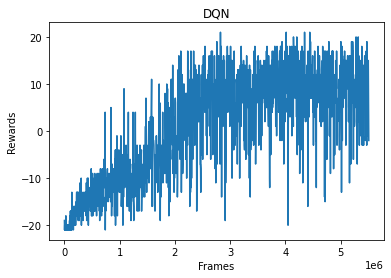

Episode:  1501
Steps:  1376342  epsilon:  0.03
Steps:  1376542  epsilon:  0.03
Steps:  1376742  epsilon:  0.03
Steps:  1376942  epsilon:  0.03
Episode:  1502
Steps:  1377004  epsilon:  0.03
Steps:  1377204  epsilon:  0.03
Steps:  1377404  epsilon:  0.03
Steps:  1377604  epsilon:  0.03
Steps:  1377804  epsilon:  0.03
Episode:  1503
Steps:  1377958  epsilon:  0.03
Steps:  1378158  epsilon:  0.03
Steps:  1378358  epsilon:  0.03
Steps:  1378558  epsilon:  0.03
Steps:  1378758  epsilon:  0.03
Steps:  1378958  epsilon:  0.03
Episode:  1504
Steps:  1379017  epsilon:  0.03
Steps:  1379217  epsilon:  0.03
Steps:  1379417  epsilon:  0.03
Steps:  1379617  epsilon:  0.03
Steps:  1379817  epsilon:  0.03
Steps:  1380017  epsilon:  0.03
Episode:  1505
Steps:  1380080  epsilon:  0.03
Steps:  1380280  epsilon:  0.03
Steps:  1380480  epsilon:  0.03
Steps:  1380680  epsilon:  0.03
Episode:  1506
Steps:  1380822  epsilon:  0.03
Steps:  1381022  epsilon:  0.03
Steps:  1381222  epsilon:  0.03
Steps:  138142

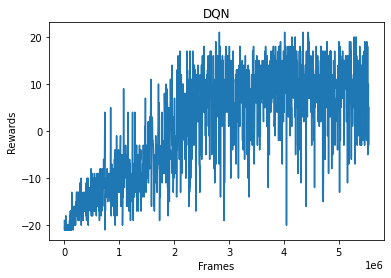

Episode:  1511
Steps:  1386104  epsilon:  0.03
Steps:  1386304  epsilon:  0.03
Steps:  1386504  epsilon:  0.03
Steps:  1386704  epsilon:  0.03
Steps:  1386904  epsilon:  0.03
Episode:  1512
Steps:  1387031  epsilon:  0.03
Steps:  1387231  epsilon:  0.03
Steps:  1387431  epsilon:  0.03
Steps:  1387631  epsilon:  0.03
Steps:  1387831  epsilon:  0.03
Steps:  1388031  epsilon:  0.03
Episode:  1513
Steps:  1388084  epsilon:  0.03
Steps:  1388284  epsilon:  0.03
Steps:  1388484  epsilon:  0.03
Steps:  1388684  epsilon:  0.03
Steps:  1388884  epsilon:  0.03
Steps:  1389084  epsilon:  0.03
Episode:  1514
Steps:  1389118  epsilon:  0.03
Steps:  1389318  epsilon:  0.03
Steps:  1389518  epsilon:  0.03
Steps:  1389718  epsilon:  0.03
Episode:  1515
Steps:  1389831  epsilon:  0.03
Steps:  1390031  epsilon:  0.03
Steps:  1390231  epsilon:  0.03
Steps:  1390431  epsilon:  0.03
Steps:  1390631  epsilon:  0.03
Steps:  1390831  epsilon:  0.03
Episode:  1516
Steps:  1390971  epsilon:  0.03
Steps:  139117

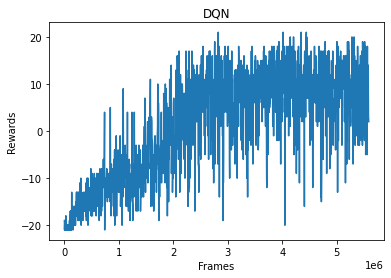

Episode:  1521
Steps:  1396117  epsilon:  0.03
Steps:  1396317  epsilon:  0.03
Steps:  1396517  epsilon:  0.03
Steps:  1396717  epsilon:  0.03
Steps:  1396917  epsilon:  0.03
Steps:  1397117  epsilon:  0.03
Steps:  1397317  epsilon:  0.03
Episode:  1522
Steps:  1397382  epsilon:  0.03
Steps:  1397582  epsilon:  0.03
Steps:  1397782  epsilon:  0.03
Steps:  1397982  epsilon:  0.03
Steps:  1398182  epsilon:  0.03
Steps:  1398382  epsilon:  0.03
Episode:  1523
Steps:  1398447  epsilon:  0.03
Steps:  1398647  epsilon:  0.03
Steps:  1398847  epsilon:  0.03
Steps:  1399047  epsilon:  0.03
Steps:  1399247  epsilon:  0.03
Episode:  1524
Steps:  1399409  epsilon:  0.03
Steps:  1399609  epsilon:  0.03
Steps:  1399809  epsilon:  0.03
Steps:  1400009  epsilon:  0.03
Steps:  1400209  epsilon:  0.03
Episode:  1525
Steps:  1400394  epsilon:  0.03
Steps:  1400594  epsilon:  0.03
Steps:  1400794  epsilon:  0.03
Steps:  1400994  epsilon:  0.03
Episode:  1526
Steps:  1401057  epsilon:  0.03
Steps:  140125

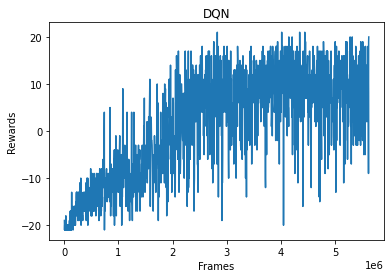

Episode:  1531
Steps:  1404912  epsilon:  0.03
Steps:  1405112  epsilon:  0.03
Steps:  1405312  epsilon:  0.03
Steps:  1405512  epsilon:  0.03
Episode:  1532
Steps:  1405580  epsilon:  0.03
Steps:  1405780  epsilon:  0.03
Steps:  1405980  epsilon:  0.03
Steps:  1406180  epsilon:  0.03
Steps:  1406380  epsilon:  0.03
Steps:  1406580  epsilon:  0.03
Episode:  1533
Steps:  1406707  epsilon:  0.03
Steps:  1406907  epsilon:  0.03
Steps:  1407107  epsilon:  0.03
Steps:  1407307  epsilon:  0.03
Episode:  1534
Steps:  1407445  epsilon:  0.03
Steps:  1407645  epsilon:  0.03
Steps:  1407845  epsilon:  0.03
Steps:  1408045  epsilon:  0.03
Steps:  1408245  epsilon:  0.03
Episode:  1535
Steps:  1408403  epsilon:  0.03
Steps:  1408603  epsilon:  0.03
Steps:  1408803  epsilon:  0.03
Steps:  1409003  epsilon:  0.03
Steps:  1409203  epsilon:  0.03
Episode:  1536
Steps:  1409344  epsilon:  0.03
Steps:  1409544  epsilon:  0.03
Steps:  1409744  epsilon:  0.03
Steps:  1409944  epsilon:  0.03
Episode:  1537

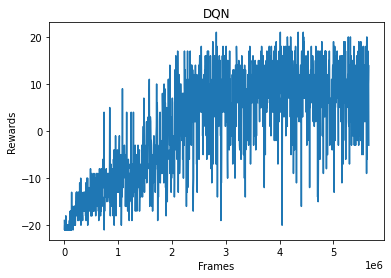

Episode:  1541
Steps:  1413923  epsilon:  0.03
Steps:  1414123  epsilon:  0.03
Steps:  1414323  epsilon:  0.03
Steps:  1414523  epsilon:  0.03
Steps:  1414723  epsilon:  0.03
Steps:  1414923  epsilon:  0.03
Episode:  1542
Steps:  1415018  epsilon:  0.03
Steps:  1415218  epsilon:  0.03
Steps:  1415418  epsilon:  0.03
Steps:  1415618  epsilon:  0.03
Episode:  1543
Steps:  1415674  epsilon:  0.03
Steps:  1415874  epsilon:  0.03
Steps:  1416074  epsilon:  0.03
Steps:  1416274  epsilon:  0.03
Steps:  1416474  epsilon:  0.03
Episode:  1544
Steps:  1416569  epsilon:  0.03
Steps:  1416769  epsilon:  0.03
Steps:  1416969  epsilon:  0.03
Steps:  1417169  epsilon:  0.03
Episode:  1545
Steps:  1417347  epsilon:  0.03
Steps:  1417547  epsilon:  0.03
Steps:  1417747  epsilon:  0.03
Steps:  1417947  epsilon:  0.03
Episode:  1546
Steps:  1417963  epsilon:  0.03
Steps:  1418163  epsilon:  0.03
Steps:  1418363  epsilon:  0.03
Steps:  1418563  epsilon:  0.03
Steps:  1418763  epsilon:  0.03
Episode:  1547

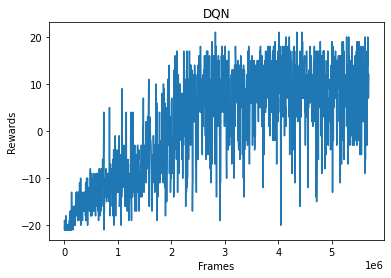

Episode:  1551
Steps:  1422421  epsilon:  0.03
Steps:  1422621  epsilon:  0.03
Steps:  1422821  epsilon:  0.03
Steps:  1423021  epsilon:  0.03
Episode:  1552
Steps:  1423035  epsilon:  0.03
Steps:  1423235  epsilon:  0.03
Steps:  1423435  epsilon:  0.03
Steps:  1423635  epsilon:  0.03
Steps:  1423835  epsilon:  0.03
Episode:  1553
Steps:  1423941  epsilon:  0.03
Steps:  1424141  epsilon:  0.03
Steps:  1424341  epsilon:  0.03
Steps:  1424541  epsilon:  0.03
Episode:  1554
Steps:  1424739  epsilon:  0.03
Steps:  1424939  epsilon:  0.03
Steps:  1425139  epsilon:  0.03
Steps:  1425339  epsilon:  0.03
Steps:  1425539  epsilon:  0.03
Episode:  1555
Steps:  1425596  epsilon:  0.03
Steps:  1425796  epsilon:  0.03
Steps:  1425996  epsilon:  0.03
Steps:  1426196  epsilon:  0.03
Steps:  1426396  epsilon:  0.03
Episode:  1556
Steps:  1426457  epsilon:  0.03
Steps:  1426657  epsilon:  0.03
Steps:  1426857  epsilon:  0.03
Steps:  1427057  epsilon:  0.03
Steps:  1427257  epsilon:  0.03
Episode:  1557

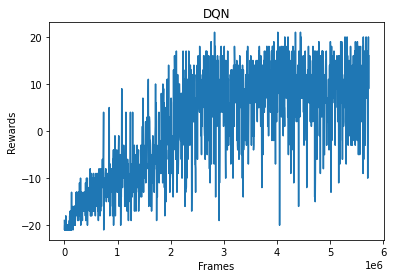

Episode:  1561
Steps:  1430561  epsilon:  0.03
Steps:  1430761  epsilon:  0.03
Steps:  1430961  epsilon:  0.03
Steps:  1431161  epsilon:  0.03
Steps:  1431361  epsilon:  0.03
Episode:  1562
Steps:  1431377  epsilon:  0.03
Steps:  1431577  epsilon:  0.03
Steps:  1431777  epsilon:  0.03
Steps:  1431977  epsilon:  0.03
Episode:  1563
Steps:  1432013  epsilon:  0.03
Steps:  1432213  epsilon:  0.03
Steps:  1432413  epsilon:  0.03
Steps:  1432613  epsilon:  0.03
Episode:  1564
Steps:  1432736  epsilon:  0.03
Steps:  1432936  epsilon:  0.03
Steps:  1433136  epsilon:  0.03
Steps:  1433336  epsilon:  0.03
Steps:  1433536  epsilon:  0.03
Episode:  1565
Steps:  1433679  epsilon:  0.03
Steps:  1433879  epsilon:  0.03
Steps:  1434079  epsilon:  0.03
Steps:  1434279  epsilon:  0.03
Steps:  1434479  epsilon:  0.03
Steps:  1434679  epsilon:  0.03
Steps:  1434879  epsilon:  0.03
Episode:  1566
Steps:  1435013  epsilon:  0.03
Steps:  1435213  epsilon:  0.03
Steps:  1435413  epsilon:  0.03
Steps:  143561

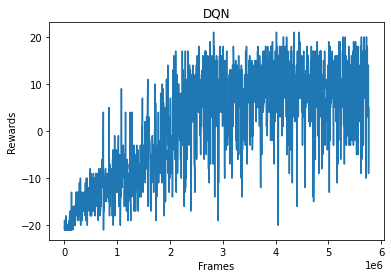

Episode:  1571
Steps:  1439643  epsilon:  0.03
Steps:  1439843  epsilon:  0.03
Steps:  1440043  epsilon:  0.03
Steps:  1440243  epsilon:  0.03
Steps:  1440443  epsilon:  0.03
Episode:  1572
Steps:  1440471  epsilon:  0.03
Steps:  1440671  epsilon:  0.03
Steps:  1440871  epsilon:  0.03
Steps:  1441071  epsilon:  0.03
Steps:  1441271  epsilon:  0.03
Steps:  1441471  epsilon:  0.03
Episode:  1573
Steps:  1441557  epsilon:  0.03
Steps:  1441757  epsilon:  0.03
Steps:  1441957  epsilon:  0.03
Steps:  1442157  epsilon:  0.03
Steps:  1442357  epsilon:  0.03
Episode:  1574
Steps:  1442542  epsilon:  0.03
Steps:  1442742  epsilon:  0.03
Steps:  1442942  epsilon:  0.03
Steps:  1443142  epsilon:  0.03
Steps:  1443342  epsilon:  0.03
Episode:  1575
Steps:  1443465  epsilon:  0.03
Steps:  1443665  epsilon:  0.03
Steps:  1443865  epsilon:  0.03
Steps:  1444065  epsilon:  0.03
Steps:  1444265  epsilon:  0.03
Episode:  1576
Steps:  1444393  epsilon:  0.03
Steps:  1444593  epsilon:  0.03
Steps:  144479

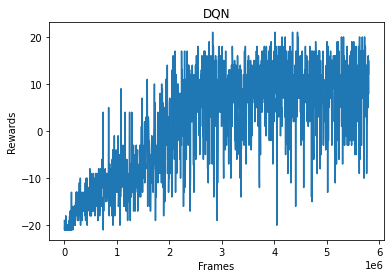

Episode:  1581
Steps:  1448771  epsilon:  0.03
Steps:  1448971  epsilon:  0.03
Steps:  1449171  epsilon:  0.03
Steps:  1449371  epsilon:  0.03
Episode:  1582
Steps:  1449475  epsilon:  0.03
Steps:  1449675  epsilon:  0.03
Steps:  1449875  epsilon:  0.03
Steps:  1450075  epsilon:  0.03
Steps:  1450275  epsilon:  0.03
Episode:  1583
Steps:  1450347  epsilon:  0.03
Steps:  1450547  epsilon:  0.03
Steps:  1450747  epsilon:  0.03
Steps:  1450947  epsilon:  0.03
Steps:  1451147  epsilon:  0.03
Episode:  1584
Steps:  1451199  epsilon:  0.03
Steps:  1451399  epsilon:  0.03
Steps:  1451599  epsilon:  0.03
Steps:  1451799  epsilon:  0.03
Episode:  1585
Steps:  1451975  epsilon:  0.03
Steps:  1452175  epsilon:  0.03
Steps:  1452375  epsilon:  0.03
Steps:  1452575  epsilon:  0.03
Steps:  1452775  epsilon:  0.03
Episode:  1586
Steps:  1452925  epsilon:  0.03
Steps:  1453125  epsilon:  0.03
Steps:  1453325  epsilon:  0.03
Steps:  1453525  epsilon:  0.03
Episode:  1587
Steps:  1453725  epsilon:  0.03

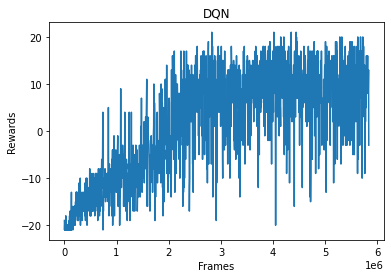

Episode:  1591
Steps:  1457430  epsilon:  0.03
Steps:  1457630  epsilon:  0.03
Steps:  1457830  epsilon:  0.03
Steps:  1458030  epsilon:  0.03
Steps:  1458230  epsilon:  0.03
Steps:  1458430  epsilon:  0.03
Episode:  1592
Steps:  1458538  epsilon:  0.03
Steps:  1458738  epsilon:  0.03
Steps:  1458938  epsilon:  0.03
Steps:  1459138  epsilon:  0.03
Steps:  1459338  epsilon:  0.03
Steps:  1459538  epsilon:  0.03
Episode:  1593
Steps:  1459724  epsilon:  0.03
Steps:  1459924  epsilon:  0.03
Steps:  1460124  epsilon:  0.03
Steps:  1460324  epsilon:  0.03
Steps:  1460524  epsilon:  0.03
Steps:  1460724  epsilon:  0.03
Episode:  1594
Steps:  1460730  epsilon:  0.03
Steps:  1460930  epsilon:  0.03
Steps:  1461130  epsilon:  0.03
Steps:  1461330  epsilon:  0.03
Steps:  1461530  epsilon:  0.03
Episode:  1595
Steps:  1461563  epsilon:  0.03
Steps:  1461763  epsilon:  0.03
Steps:  1461963  epsilon:  0.03
Steps:  1462163  epsilon:  0.03
Steps:  1462363  epsilon:  0.03
Episode:  1596
Steps:  146248

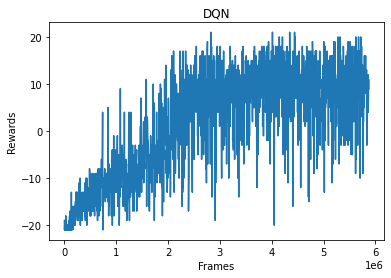

Episode:  1601
Steps:  1467269  epsilon:  0.03
Steps:  1467469  epsilon:  0.03
Steps:  1467669  epsilon:  0.03
Steps:  1467869  epsilon:  0.03
Episode:  1602
Steps:  1468042  epsilon:  0.03
Steps:  1468242  epsilon:  0.03
Steps:  1468442  epsilon:  0.03
Steps:  1468642  epsilon:  0.03
Episode:  1603
Steps:  1468719  epsilon:  0.03
Steps:  1468919  epsilon:  0.03
Steps:  1469119  epsilon:  0.03
Steps:  1469319  epsilon:  0.03
Steps:  1469519  epsilon:  0.03
Episode:  1604
Steps:  1469606  epsilon:  0.03
Steps:  1469806  epsilon:  0.03
Steps:  1470006  epsilon:  0.03
Steps:  1470206  epsilon:  0.03
Steps:  1470406  epsilon:  0.03
Steps:  1470606  epsilon:  0.03
Episode:  1605
Steps:  1470670  epsilon:  0.03
Steps:  1470870  epsilon:  0.03
Steps:  1471070  epsilon:  0.03
Steps:  1471270  epsilon:  0.03
Steps:  1471470  epsilon:  0.03
Episode:  1606
Steps:  1471634  epsilon:  0.03
Steps:  1471834  epsilon:  0.03
Steps:  1472034  epsilon:  0.03
Steps:  1472234  epsilon:  0.03
Episode:  1607

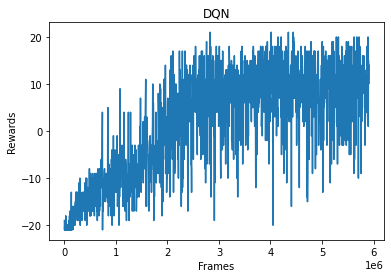

Episode:  1611
Steps:  1475921  epsilon:  0.03
Steps:  1476121  epsilon:  0.03
Steps:  1476321  epsilon:  0.03
Steps:  1476521  epsilon:  0.03
Episode:  1612
Steps:  1476593  epsilon:  0.03
Steps:  1476793  epsilon:  0.03
Steps:  1476993  epsilon:  0.03
Steps:  1477193  epsilon:  0.03
Steps:  1477393  epsilon:  0.03
Episode:  1613
Steps:  1477588  epsilon:  0.03
Steps:  1477788  epsilon:  0.03
Steps:  1477988  epsilon:  0.03
Steps:  1478188  epsilon:  0.03
Steps:  1478388  epsilon:  0.03
Episode:  1614
Steps:  1478513  epsilon:  0.03
Steps:  1478713  epsilon:  0.03
Steps:  1478913  epsilon:  0.03
Steps:  1479113  epsilon:  0.03
Steps:  1479313  epsilon:  0.03
Episode:  1615
Steps:  1479341  epsilon:  0.03
Steps:  1479541  epsilon:  0.03
Steps:  1479741  epsilon:  0.03
Steps:  1479941  epsilon:  0.03
Steps:  1480141  epsilon:  0.03
Episode:  1616
Steps:  1480230  epsilon:  0.03
Steps:  1480430  epsilon:  0.03
Steps:  1480630  epsilon:  0.03
Steps:  1480830  epsilon:  0.03
Steps:  148103

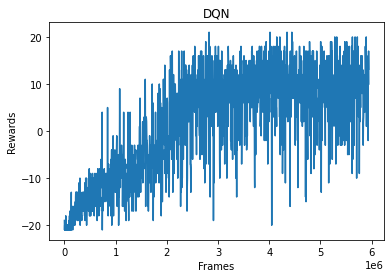

Episode:  1621
Steps:  1484767  epsilon:  0.03
Steps:  1484967  epsilon:  0.03
Steps:  1485167  epsilon:  0.03
Steps:  1485367  epsilon:  0.03
Steps:  1485567  epsilon:  0.03
Steps:  1485767  epsilon:  0.03
Steps:  1485967  epsilon:  0.03
Episode:  1622
Steps:  1485994  epsilon:  0.03
Steps:  1486194  epsilon:  0.03
Steps:  1486394  epsilon:  0.03
Steps:  1486594  epsilon:  0.03
Episode:  1623
Steps:  1486677  epsilon:  0.03
Steps:  1486877  epsilon:  0.03
Steps:  1487077  epsilon:  0.03
Steps:  1487277  epsilon:  0.03
Steps:  1487477  epsilon:  0.03
Episode:  1624
Steps:  1487598  epsilon:  0.03
Steps:  1487798  epsilon:  0.03
Steps:  1487998  epsilon:  0.03
Steps:  1488198  epsilon:  0.03
Episode:  1625
Steps:  1488303  epsilon:  0.03
Steps:  1488503  epsilon:  0.03
Steps:  1488703  epsilon:  0.03
Episode:  1626
Steps:  1488882  epsilon:  0.03
Steps:  1489082  epsilon:  0.03
Steps:  1489282  epsilon:  0.03
Steps:  1489482  epsilon:  0.03
Steps:  1489682  epsilon:  0.03
Steps:  148988

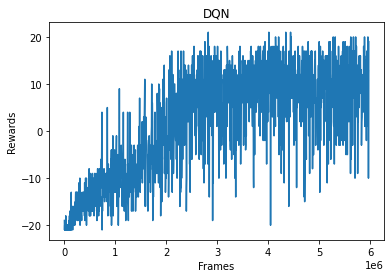

Episode:  1631
Steps:  1493177  epsilon:  0.03
Steps:  1493377  epsilon:  0.03
Steps:  1493577  epsilon:  0.03
Steps:  1493777  epsilon:  0.03
Steps:  1493977  epsilon:  0.03
Steps:  1494177  epsilon:  0.03
Episode:  1632
Steps:  1494245  epsilon:  0.03
Steps:  1494445  epsilon:  0.03
Steps:  1494645  epsilon:  0.03
Steps:  1494845  epsilon:  0.03
Steps:  1495045  epsilon:  0.03
Steps:  1495245  epsilon:  0.03
Steps:  1495445  epsilon:  0.03
Episode:  1633
Steps:  1495540  epsilon:  0.03
Steps:  1495740  epsilon:  0.03
Steps:  1495940  epsilon:  0.03
Steps:  1496140  epsilon:  0.03
Episode:  1634
Steps:  1496301  epsilon:  0.03
Steps:  1496501  epsilon:  0.03
Steps:  1496701  epsilon:  0.03
Steps:  1496901  epsilon:  0.03
Episode:  1635
Steps:  1496942  epsilon:  0.03
Steps:  1497142  epsilon:  0.03
Steps:  1497342  epsilon:  0.03
Steps:  1497542  epsilon:  0.03
Steps:  1497742  epsilon:  0.03
Episode:  1636
Steps:  1497798  epsilon:  0.03
Steps:  1497998  epsilon:  0.03
Steps:  149819

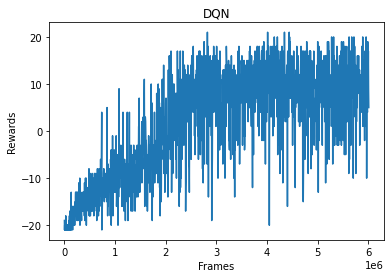

Episode:  1641
Steps:  1502141  epsilon:  0.03
Steps:  1502341  epsilon:  0.03
Steps:  1502541  epsilon:  0.03
Steps:  1502741  epsilon:  0.03
Episode:  1642
Steps:  1502877  epsilon:  0.03
Steps:  1503077  epsilon:  0.03
Steps:  1503277  epsilon:  0.03
Steps:  1503477  epsilon:  0.03
Steps:  1503677  epsilon:  0.03
Steps:  1503877  epsilon:  0.03
Episode:  1643
Steps:  1503898  epsilon:  0.03
Steps:  1504098  epsilon:  0.03
Steps:  1504298  epsilon:  0.03
Steps:  1504498  epsilon:  0.03
Steps:  1504698  epsilon:  0.03
Steps:  1504898  epsilon:  0.03
Episode:  1644
Steps:  1505004  epsilon:  0.03
Steps:  1505204  epsilon:  0.03
Steps:  1505404  epsilon:  0.03
Steps:  1505604  epsilon:  0.03
Steps:  1505804  epsilon:  0.03
Steps:  1506004  epsilon:  0.03
Episode:  1645
Steps:  1506053  epsilon:  0.03
Steps:  1506253  epsilon:  0.03
Steps:  1506453  epsilon:  0.03
Steps:  1506653  epsilon:  0.03
Steps:  1506853  epsilon:  0.03
Episode:  1646
Steps:  1506920  epsilon:  0.03
Steps:  150712

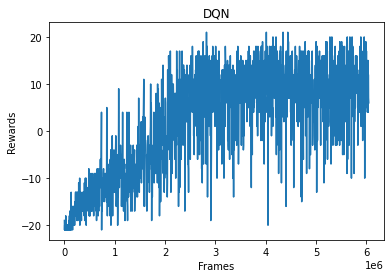

Episode:  1651
Steps:  1511757  epsilon:  0.03
Steps:  1511957  epsilon:  0.03
Steps:  1512157  epsilon:  0.03
Steps:  1512357  epsilon:  0.03
Episode:  1652
Steps:  1512481  epsilon:  0.03
Steps:  1512681  epsilon:  0.03
Steps:  1512881  epsilon:  0.03
Steps:  1513081  epsilon:  0.03
Steps:  1513281  epsilon:  0.03
Episode:  1653
Steps:  1513383  epsilon:  0.03
Steps:  1513583  epsilon:  0.03
Steps:  1513783  epsilon:  0.03
Steps:  1513983  epsilon:  0.03
Steps:  1514183  epsilon:  0.03
Steps:  1514383  epsilon:  0.03
Episode:  1654
Steps:  1514525  epsilon:  0.03
Steps:  1514725  epsilon:  0.03
Steps:  1514925  epsilon:  0.03
Steps:  1515125  epsilon:  0.03
Steps:  1515325  epsilon:  0.03
Steps:  1515525  epsilon:  0.03
Episode:  1655
Steps:  1515643  epsilon:  0.03
Steps:  1515843  epsilon:  0.03
Steps:  1516043  epsilon:  0.03
Steps:  1516243  epsilon:  0.03
Episode:  1656
Steps:  1516308  epsilon:  0.03
Steps:  1516508  epsilon:  0.03
Steps:  1516708  epsilon:  0.03
Steps:  151690

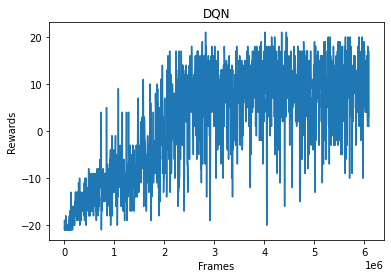

Episode:  1661
Steps:  1521458  epsilon:  0.03
Steps:  1521658  epsilon:  0.03
Steps:  1521858  epsilon:  0.03
Steps:  1522058  epsilon:  0.03
Steps:  1522258  epsilon:  0.03
Episode:  1662
Steps:  1522375  epsilon:  0.03
Steps:  1522575  epsilon:  0.03
Steps:  1522775  epsilon:  0.03
Steps:  1522975  epsilon:  0.03
Episode:  1663
Steps:  1523175  epsilon:  0.03
Steps:  1523375  epsilon:  0.03
Steps:  1523575  epsilon:  0.03
Steps:  1523775  epsilon:  0.03
Steps:  1523975  epsilon:  0.03
Episode:  1664
Steps:  1524132  epsilon:  0.03
Steps:  1524332  epsilon:  0.03
Steps:  1524532  epsilon:  0.03
Steps:  1524732  epsilon:  0.03
Steps:  1524932  epsilon:  0.03
Steps:  1525132  epsilon:  0.03
Episode:  1665
Steps:  1525170  epsilon:  0.03
Steps:  1525370  epsilon:  0.03
Steps:  1525570  epsilon:  0.03
Steps:  1525770  epsilon:  0.03
Episode:  1666
Steps:  1525949  epsilon:  0.03
Steps:  1526149  epsilon:  0.03
Steps:  1526349  epsilon:  0.03
Steps:  1526549  epsilon:  0.03
Episode:  1667

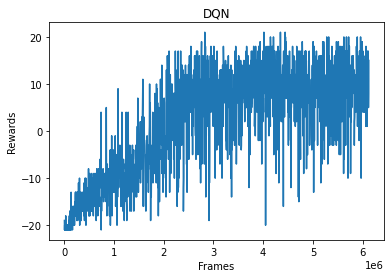

Episode:  1671
Steps:  1530128  epsilon:  0.03
Steps:  1530328  epsilon:  0.03
Steps:  1530528  epsilon:  0.03
Steps:  1530728  epsilon:  0.03
Episode:  1672
Steps:  1530807  epsilon:  0.03
Steps:  1531007  epsilon:  0.03
Steps:  1531207  epsilon:  0.03
Steps:  1531407  epsilon:  0.03
Steps:  1531607  epsilon:  0.03
Steps:  1531807  epsilon:  0.03
Episode:  1673
Steps:  1531828  epsilon:  0.03
Steps:  1532028  epsilon:  0.03
Steps:  1532228  epsilon:  0.03
Steps:  1532428  epsilon:  0.03
Steps:  1532628  epsilon:  0.03
Steps:  1532828  epsilon:  0.03
Episode:  1674
Steps:  1532894  epsilon:  0.03
Steps:  1533094  epsilon:  0.03
Steps:  1533294  epsilon:  0.03
Steps:  1533494  epsilon:  0.03
Steps:  1533694  epsilon:  0.03
Steps:  1533894  epsilon:  0.03
Episode:  1675
Steps:  1533960  epsilon:  0.03
Steps:  1534160  epsilon:  0.03
Steps:  1534360  epsilon:  0.03
Steps:  1534560  epsilon:  0.03
Steps:  1534760  epsilon:  0.03
Episode:  1676
Steps:  1534792  epsilon:  0.03
Steps:  153499

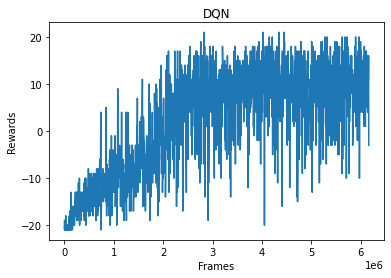

Episode:  1681
Steps:  1538832  epsilon:  0.03
Steps:  1539032  epsilon:  0.03
Steps:  1539232  epsilon:  0.03
Steps:  1539432  epsilon:  0.03
Steps:  1539632  epsilon:  0.03
Episode:  1682
Steps:  1539674  epsilon:  0.03
Steps:  1539874  epsilon:  0.03
Steps:  1540074  epsilon:  0.03
Steps:  1540274  epsilon:  0.03
Steps:  1540474  epsilon:  0.03
Steps:  1540674  epsilon:  0.03
Episode:  1683
Steps:  1540727  epsilon:  0.03
Steps:  1540927  epsilon:  0.03
Steps:  1541127  epsilon:  0.03
Steps:  1541327  epsilon:  0.03
Steps:  1541527  epsilon:  0.03
Episode:  1684
Steps:  1541627  epsilon:  0.03
Steps:  1541827  epsilon:  0.03
Steps:  1542027  epsilon:  0.03
Steps:  1542227  epsilon:  0.03
Steps:  1542427  epsilon:  0.03
Steps:  1542627  epsilon:  0.03
Episode:  1685
Steps:  1542729  epsilon:  0.03
Steps:  1542929  epsilon:  0.03
Steps:  1543129  epsilon:  0.03
Steps:  1543329  epsilon:  0.03
Steps:  1543529  epsilon:  0.03
Episode:  1686
Steps:  1543583  epsilon:  0.03
Steps:  154378

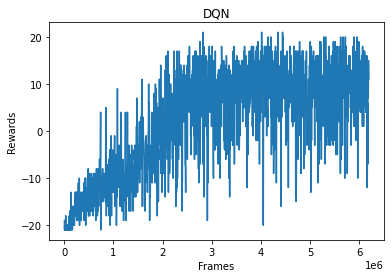

Episode:  1691
Steps:  1547884  epsilon:  0.03
Steps:  1548084  epsilon:  0.03
Steps:  1548284  epsilon:  0.03
Steps:  1548484  epsilon:  0.03
Steps:  1548684  epsilon:  0.03
Episode:  1692
Steps:  1548875  epsilon:  0.03
Steps:  1549075  epsilon:  0.03
Steps:  1549275  epsilon:  0.03
Steps:  1549475  epsilon:  0.03
Steps:  1549675  epsilon:  0.03
Steps:  1549875  epsilon:  0.03
Episode:  1693
Steps:  1549919  epsilon:  0.03
Steps:  1550119  epsilon:  0.03
Steps:  1550319  epsilon:  0.03
Steps:  1550519  epsilon:  0.03
Episode:  1694
Steps:  1550686  epsilon:  0.03
Steps:  1550886  epsilon:  0.03
Steps:  1551086  epsilon:  0.03
Steps:  1551286  epsilon:  0.03
Steps:  1551486  epsilon:  0.03
Steps:  1551686  epsilon:  0.03
Episode:  1695
Steps:  1551722  epsilon:  0.03
Steps:  1551922  epsilon:  0.03
Steps:  1552122  epsilon:  0.03
Steps:  1552322  epsilon:  0.03
Steps:  1552522  epsilon:  0.03
Steps:  1552722  epsilon:  0.03
Steps:  1552922  epsilon:  0.03
Episode:  1696
Steps:  155300

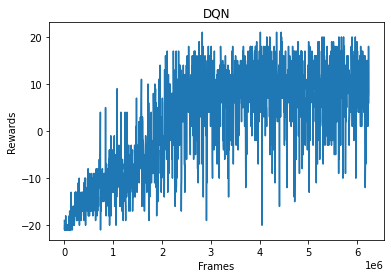

Episode:  1701
Steps:  1557859  epsilon:  0.03
Steps:  1558059  epsilon:  0.03
Steps:  1558259  epsilon:  0.03
Steps:  1558459  epsilon:  0.03
Episode:  1702
Steps:  1558547  epsilon:  0.03
Steps:  1558747  epsilon:  0.03
Steps:  1558947  epsilon:  0.03
Episode:  1703
Steps:  1559135  epsilon:  0.03
Steps:  1559335  epsilon:  0.03
Steps:  1559535  epsilon:  0.03
Steps:  1559735  epsilon:  0.03
Steps:  1559935  epsilon:  0.03
Steps:  1560135  epsilon:  0.03
Episode:  1704
Steps:  1560203  epsilon:  0.03
Steps:  1560403  epsilon:  0.03
Steps:  1560603  epsilon:  0.03
Steps:  1560803  epsilon:  0.03
Episode:  1705
Steps:  1560957  epsilon:  0.03
Steps:  1561157  epsilon:  0.03
Steps:  1561357  epsilon:  0.03
Steps:  1561557  epsilon:  0.03
Steps:  1561757  epsilon:  0.03
Steps:  1561957  epsilon:  0.03
Episode:  1706
Steps:  1561995  epsilon:  0.03
Steps:  1562195  epsilon:  0.03
Steps:  1562395  epsilon:  0.03
Steps:  1562595  epsilon:  0.03
Episode:  1707
Steps:  1562776  epsilon:  0.03

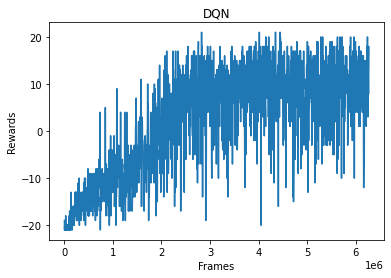

Episode:  1711
Steps:  1565921  epsilon:  0.03
Steps:  1566121  epsilon:  0.03
Steps:  1566321  epsilon:  0.03
Steps:  1566521  epsilon:  0.03
Steps:  1566721  epsilon:  0.03
Episode:  1712
Steps:  1566794  epsilon:  0.03
Steps:  1566994  epsilon:  0.03
Steps:  1567194  epsilon:  0.03
Steps:  1567394  epsilon:  0.03
Steps:  1567594  epsilon:  0.03
Episode:  1713
Steps:  1567663  epsilon:  0.03
Steps:  1567863  epsilon:  0.03
Steps:  1568063  epsilon:  0.03
Steps:  1568263  epsilon:  0.03
Steps:  1568463  epsilon:  0.03
Steps:  1568663  epsilon:  0.03
Episode:  1714
Steps:  1568676  epsilon:  0.03
Steps:  1568876  epsilon:  0.03
Steps:  1569076  epsilon:  0.03
Steps:  1569276  epsilon:  0.03
Episode:  1715
Steps:  1569346  epsilon:  0.03
Steps:  1569546  epsilon:  0.03
Steps:  1569746  epsilon:  0.03
Steps:  1569946  epsilon:  0.03
Steps:  1570146  epsilon:  0.03
Steps:  1570346  epsilon:  0.03
Episode:  1716
Steps:  1570465  epsilon:  0.03
Steps:  1570665  epsilon:  0.03
Steps:  157086

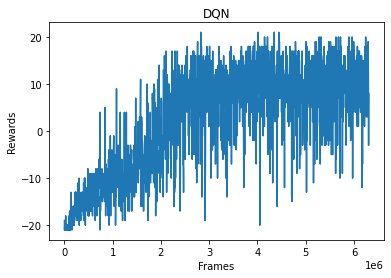

Episode:  1721
Steps:  1575216  epsilon:  0.03
Steps:  1575416  epsilon:  0.03
Steps:  1575616  epsilon:  0.03
Steps:  1575816  epsilon:  0.03
Steps:  1576016  epsilon:  0.03
Episode:  1722
Steps:  1576139  epsilon:  0.03
Steps:  1576339  epsilon:  0.03
Steps:  1576539  epsilon:  0.03
Steps:  1576739  epsilon:  0.03
Episode:  1723
Steps:  1576807  epsilon:  0.03
Steps:  1577007  epsilon:  0.03
Steps:  1577207  epsilon:  0.03
Steps:  1577407  epsilon:  0.03
Episode:  1724
Steps:  1577496  epsilon:  0.03
Steps:  1577696  epsilon:  0.03
Steps:  1577896  epsilon:  0.03
Steps:  1578096  epsilon:  0.03
Steps:  1578296  epsilon:  0.03
Episode:  1725
Steps:  1578397  epsilon:  0.03
Steps:  1578597  epsilon:  0.03
Steps:  1578797  epsilon:  0.03
Steps:  1578997  epsilon:  0.03
Episode:  1726
Steps:  1579187  epsilon:  0.03
Steps:  1579387  epsilon:  0.03
Steps:  1579587  epsilon:  0.03
Steps:  1579787  epsilon:  0.03
Steps:  1579987  epsilon:  0.03
Episode:  1727
Steps:  1580120  epsilon:  0.03

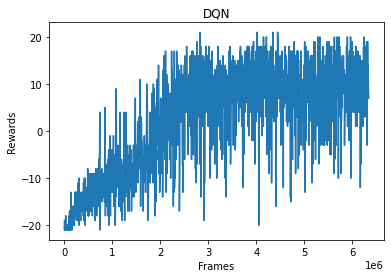

Episode:  1731
Steps:  1583717  epsilon:  0.03
Steps:  1583917  epsilon:  0.03
Steps:  1584117  epsilon:  0.03
Steps:  1584317  epsilon:  0.03
Steps:  1584517  epsilon:  0.03
Steps:  1584717  epsilon:  0.03
Episode:  1732
Steps:  1584871  epsilon:  0.03
Steps:  1585071  epsilon:  0.03
Steps:  1585271  epsilon:  0.03
Steps:  1585471  epsilon:  0.03
Steps:  1585671  epsilon:  0.03
Steps:  1585871  epsilon:  0.03
Episode:  1733
Steps:  1585971  epsilon:  0.03
Steps:  1586171  epsilon:  0.03
Steps:  1586371  epsilon:  0.03
Steps:  1586571  epsilon:  0.03
Episode:  1734
Steps:  1586716  epsilon:  0.03
Steps:  1586916  epsilon:  0.03
Steps:  1587116  epsilon:  0.03
Steps:  1587316  epsilon:  0.03
Episode:  1735
Steps:  1587429  epsilon:  0.03
Steps:  1587629  epsilon:  0.03
Steps:  1587829  epsilon:  0.03
Steps:  1588029  epsilon:  0.03
Steps:  1588229  epsilon:  0.03
Episode:  1736
Steps:  1588237  epsilon:  0.03
Steps:  1588437  epsilon:  0.03
Steps:  1588637  epsilon:  0.03
Steps:  158883

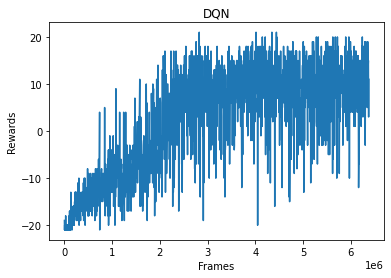

Episode:  1741
Steps:  1592980  epsilon:  0.03
Steps:  1593180  epsilon:  0.03
Steps:  1593380  epsilon:  0.03
Steps:  1593580  epsilon:  0.03
Steps:  1593780  epsilon:  0.03
Episode:  1742
Steps:  1593790  epsilon:  0.03
Steps:  1593990  epsilon:  0.03
Steps:  1594190  epsilon:  0.03
Steps:  1594390  epsilon:  0.03
Episode:  1743
Steps:  1594515  epsilon:  0.03
Steps:  1594715  epsilon:  0.03
Steps:  1594915  epsilon:  0.03
Steps:  1595115  epsilon:  0.03
Episode:  1744
Steps:  1595228  epsilon:  0.03
Steps:  1595428  epsilon:  0.03
Steps:  1595628  epsilon:  0.03
Steps:  1595828  epsilon:  0.03
Steps:  1596028  epsilon:  0.03
Steps:  1596228  epsilon:  0.03
Episode:  1745
Steps:  1596357  epsilon:  0.03
Steps:  1596557  epsilon:  0.03
Steps:  1596757  epsilon:  0.03
Steps:  1596957  epsilon:  0.03
Steps:  1597157  epsilon:  0.03
Episode:  1746
Steps:  1597349  epsilon:  0.03
Steps:  1597549  epsilon:  0.03
Steps:  1597749  epsilon:  0.03
Steps:  1597949  epsilon:  0.03
Steps:  159814

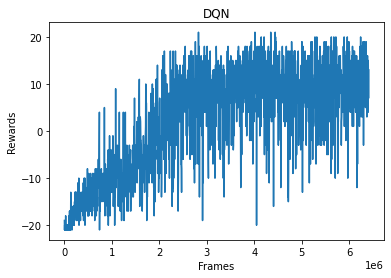

Episode:  1751
Steps:  1601987  epsilon:  0.03
Steps:  1602187  epsilon:  0.03
Steps:  1602387  epsilon:  0.03
Steps:  1602587  epsilon:  0.03
Steps:  1602787  epsilon:  0.03
Steps:  1602987  epsilon:  0.03
Episode:  1752
Steps:  1603056  epsilon:  0.03
Steps:  1603256  epsilon:  0.03
Steps:  1603456  epsilon:  0.03
Steps:  1603656  epsilon:  0.03
Episode:  1753
Steps:  1603846  epsilon:  0.03
Steps:  1604046  epsilon:  0.03
Steps:  1604246  epsilon:  0.03
Steps:  1604446  epsilon:  0.03
Steps:  1604646  epsilon:  0.03
Episode:  1754
Steps:  1604833  epsilon:  0.03
Steps:  1605033  epsilon:  0.03
Steps:  1605233  epsilon:  0.03
Steps:  1605433  epsilon:  0.03
Steps:  1605633  epsilon:  0.03
Steps:  1605833  epsilon:  0.03
Episode:  1755
Steps:  1605942  epsilon:  0.03
Steps:  1606142  epsilon:  0.03
Steps:  1606342  epsilon:  0.03
Steps:  1606542  epsilon:  0.03
Steps:  1606742  epsilon:  0.03
Steps:  1606942  epsilon:  0.03
Episode:  1756
Steps:  1606993  epsilon:  0.03
Steps:  160719

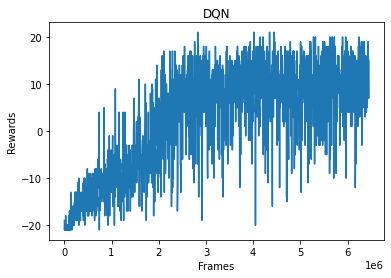

Episode:  1761
Steps:  1611152  epsilon:  0.03
Steps:  1611352  epsilon:  0.03
Steps:  1611552  epsilon:  0.03
Steps:  1611752  epsilon:  0.03
Steps:  1611952  epsilon:  0.03
Steps:  1612152  epsilon:  0.03
Steps:  1612352  epsilon:  0.03
Episode:  1762
Steps:  1612390  epsilon:  0.03
Steps:  1612590  epsilon:  0.03
Steps:  1612790  epsilon:  0.03
Steps:  1612990  epsilon:  0.03
Steps:  1613190  epsilon:  0.03
Episode:  1763
Steps:  1613377  epsilon:  0.03
Steps:  1613577  epsilon:  0.03
Steps:  1613777  epsilon:  0.03
Steps:  1613977  epsilon:  0.03
Steps:  1614177  epsilon:  0.03
Episode:  1764
Steps:  1614296  epsilon:  0.03
Steps:  1614496  epsilon:  0.03
Steps:  1614696  epsilon:  0.03
Steps:  1614896  epsilon:  0.03
Steps:  1615096  epsilon:  0.03
Episode:  1765
Steps:  1615153  epsilon:  0.03
Steps:  1615353  epsilon:  0.03
Steps:  1615553  epsilon:  0.03
Steps:  1615753  epsilon:  0.03
Steps:  1615953  epsilon:  0.03
Episode:  1766
Steps:  1615997  epsilon:  0.03
Steps:  161619

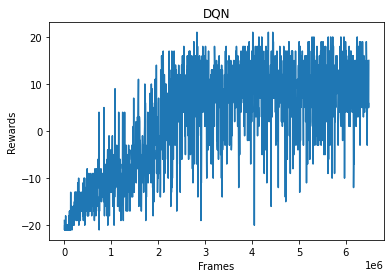

Episode:  1771
Steps:  1620760  epsilon:  0.03
Steps:  1620960  epsilon:  0.03
Steps:  1621160  epsilon:  0.03
Steps:  1621360  epsilon:  0.03
Episode:  1772
Steps:  1621520  epsilon:  0.03
Steps:  1621720  epsilon:  0.03
Steps:  1621920  epsilon:  0.03
Steps:  1622120  epsilon:  0.03
Episode:  1773
Steps:  1622300  epsilon:  0.03
Steps:  1622500  epsilon:  0.03
Steps:  1622700  epsilon:  0.03
Steps:  1622900  epsilon:  0.03
Steps:  1623100  epsilon:  0.03
Episode:  1774
Steps:  1623197  epsilon:  0.03
Steps:  1623397  epsilon:  0.03
Steps:  1623597  epsilon:  0.03
Steps:  1623797  epsilon:  0.03
Steps:  1623997  epsilon:  0.03
Episode:  1775
Steps:  1624194  epsilon:  0.03
Steps:  1624394  epsilon:  0.03
Steps:  1624594  epsilon:  0.03
Steps:  1624794  epsilon:  0.03
Steps:  1624994  epsilon:  0.03
Episode:  1776
Steps:  1625058  epsilon:  0.03
Steps:  1625258  epsilon:  0.03
Steps:  1625458  epsilon:  0.03
Steps:  1625658  epsilon:  0.03
Steps:  1625858  epsilon:  0.03
Episode:  1777

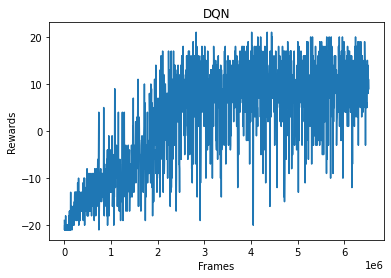

Episode:  1781
Steps:  1630014  epsilon:  0.03
Steps:  1630214  epsilon:  0.03
Steps:  1630414  epsilon:  0.03
Steps:  1630614  epsilon:  0.03
Steps:  1630814  epsilon:  0.03
Episode:  1782
Steps:  1630857  epsilon:  0.03
Steps:  1631057  epsilon:  0.03
Steps:  1631257  epsilon:  0.03
Steps:  1631457  epsilon:  0.03
Steps:  1631657  epsilon:  0.03
Episode:  1783
Steps:  1631740  epsilon:  0.03
Steps:  1631940  epsilon:  0.03
Steps:  1632140  epsilon:  0.03
Steps:  1632340  epsilon:  0.03
Episode:  1784
Steps:  1632513  epsilon:  0.03
Steps:  1632713  epsilon:  0.03
Steps:  1632913  epsilon:  0.03
Steps:  1633113  epsilon:  0.03
Steps:  1633313  epsilon:  0.03
Episode:  1785
Steps:  1633414  epsilon:  0.03
Steps:  1633614  epsilon:  0.03
Steps:  1633814  epsilon:  0.03
Steps:  1634014  epsilon:  0.03
Steps:  1634214  epsilon:  0.03
Steps:  1634414  epsilon:  0.03
Episode:  1786
Steps:  1634472  epsilon:  0.03
Steps:  1634672  epsilon:  0.03
Steps:  1634872  epsilon:  0.03
Steps:  163507

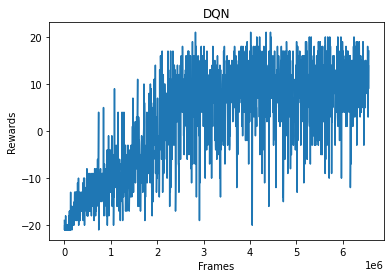

Episode:  1791
Steps:  1638725  epsilon:  0.03
Steps:  1638925  epsilon:  0.03
Steps:  1639125  epsilon:  0.03
Steps:  1639325  epsilon:  0.03
Steps:  1639525  epsilon:  0.03
Episode:  1792
Steps:  1639600  epsilon:  0.03
Steps:  1639800  epsilon:  0.03
Steps:  1640000  epsilon:  0.03
Steps:  1640200  epsilon:  0.03
Steps:  1640400  epsilon:  0.03
Episode:  1793
Steps:  1640551  epsilon:  0.03
Steps:  1640751  epsilon:  0.03
Steps:  1640951  epsilon:  0.03
Steps:  1641151  epsilon:  0.03
Steps:  1641351  epsilon:  0.03
Episode:  1794
Steps:  1641543  epsilon:  0.03
Steps:  1641743  epsilon:  0.03
Steps:  1641943  epsilon:  0.03
Steps:  1642143  epsilon:  0.03
Episode:  1795
Steps:  1642271  epsilon:  0.03
Steps:  1642471  epsilon:  0.03
Steps:  1642671  epsilon:  0.03
Steps:  1642871  epsilon:  0.03
Steps:  1643071  epsilon:  0.03
Episode:  1796
Steps:  1643235  epsilon:  0.03
Steps:  1643435  epsilon:  0.03
Steps:  1643635  epsilon:  0.03
Steps:  1643835  epsilon:  0.03
Steps:  164403

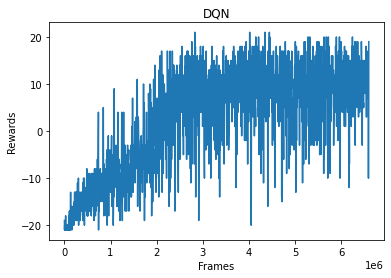

Episode:  1801
Steps:  1647669  epsilon:  0.03
Steps:  1647869  epsilon:  0.03
Steps:  1648069  epsilon:  0.03
Steps:  1648269  epsilon:  0.03
Steps:  1648469  epsilon:  0.03
Steps:  1648669  epsilon:  0.03
Episode:  1802
Steps:  1648686  epsilon:  0.03
Steps:  1648886  epsilon:  0.03
Steps:  1649086  epsilon:  0.03
Steps:  1649286  epsilon:  0.03
Episode:  1803
Steps:  1649437  epsilon:  0.03
Steps:  1649637  epsilon:  0.03
Steps:  1649837  epsilon:  0.03
Steps:  1650037  epsilon:  0.03
Steps:  1650237  epsilon:  0.03
Steps:  1650437  epsilon:  0.03
Episode:  1804
Steps:  1650442  epsilon:  0.03
Steps:  1650642  epsilon:  0.03
Steps:  1650842  epsilon:  0.03
Steps:  1651042  epsilon:  0.03
Steps:  1651242  epsilon:  0.03
Episode:  1805
Steps:  1651340  epsilon:  0.03
Steps:  1651540  epsilon:  0.03
Steps:  1651740  epsilon:  0.03
Steps:  1651940  epsilon:  0.03
Episode:  1806
Steps:  1651954  epsilon:  0.03
Steps:  1652154  epsilon:  0.03
Steps:  1652354  epsilon:  0.03
Steps:  165255

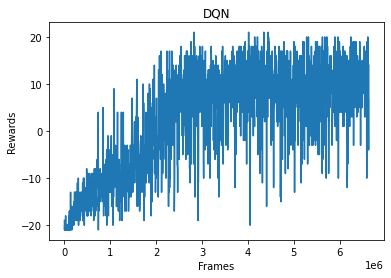

Episode:  1811
Steps:  1657031  epsilon:  0.03
Steps:  1657231  epsilon:  0.03
Steps:  1657431  epsilon:  0.03
Steps:  1657631  epsilon:  0.03
Steps:  1657831  epsilon:  0.03
Steps:  1658031  epsilon:  0.03
Episode:  1812
Steps:  1658163  epsilon:  0.03
Steps:  1658363  epsilon:  0.03
Steps:  1658563  epsilon:  0.03
Steps:  1658763  epsilon:  0.03
Steps:  1658963  epsilon:  0.03
Episode:  1813
Steps:  1659038  epsilon:  0.03
Steps:  1659238  epsilon:  0.03
Steps:  1659438  epsilon:  0.03
Steps:  1659638  epsilon:  0.03
Steps:  1659838  epsilon:  0.03
Episode:  1814
Steps:  1659990  epsilon:  0.03
Steps:  1660190  epsilon:  0.03
Steps:  1660390  epsilon:  0.03
Steps:  1660590  epsilon:  0.03
Episode:  1815
Steps:  1660678  epsilon:  0.03
Steps:  1660878  epsilon:  0.03
Steps:  1661078  epsilon:  0.03
Steps:  1661278  epsilon:  0.03
Steps:  1661478  epsilon:  0.03
Steps:  1661678  epsilon:  0.03
Episode:  1816
Steps:  1661790  epsilon:  0.03
Steps:  1661990  epsilon:  0.03
Steps:  166219

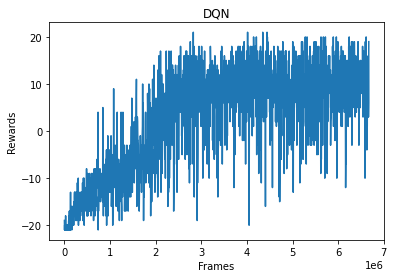

Episode:  1821
Steps:  1666456  epsilon:  0.03
Steps:  1666656  epsilon:  0.03
Steps:  1666856  epsilon:  0.03
Steps:  1667056  epsilon:  0.03
Steps:  1667256  epsilon:  0.03
Steps:  1667456  epsilon:  0.03
Episode:  1822
Steps:  1667463  epsilon:  0.03
Steps:  1667663  epsilon:  0.03
Steps:  1667863  epsilon:  0.03
Steps:  1668063  epsilon:  0.03
Steps:  1668263  epsilon:  0.03
Episode:  1823
Steps:  1668355  epsilon:  0.03
Steps:  1668555  epsilon:  0.03
Steps:  1668755  epsilon:  0.03
Steps:  1668955  epsilon:  0.03
Steps:  1669155  epsilon:  0.03
Episode:  1824
Steps:  1669279  epsilon:  0.03
Steps:  1669479  epsilon:  0.03
Steps:  1669679  epsilon:  0.03
Steps:  1669879  epsilon:  0.03
Episode:  1825
Steps:  1669899  epsilon:  0.03
Steps:  1670099  epsilon:  0.03
Steps:  1670299  epsilon:  0.03
Steps:  1670499  epsilon:  0.03
Steps:  1670699  epsilon:  0.03
Episode:  1826
Steps:  1670899  epsilon:  0.03
Steps:  1671099  epsilon:  0.03
Steps:  1671299  epsilon:  0.03
Steps:  167149

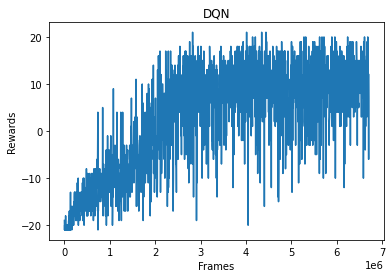

Episode:  1831
Steps:  1675443  epsilon:  0.03
Steps:  1675643  epsilon:  0.03
Steps:  1675843  epsilon:  0.03
Steps:  1676043  epsilon:  0.03
Steps:  1676243  epsilon:  0.03
Episode:  1832
Steps:  1676348  epsilon:  0.03
Steps:  1676548  epsilon:  0.03
Steps:  1676748  epsilon:  0.03
Steps:  1676948  epsilon:  0.03
Episode:  1833
Steps:  1677128  epsilon:  0.03
Steps:  1677328  epsilon:  0.03
Steps:  1677528  epsilon:  0.03
Steps:  1677728  epsilon:  0.03
Steps:  1677928  epsilon:  0.03
Episode:  1834
Steps:  1678040  epsilon:  0.03
Steps:  1678240  epsilon:  0.03
Steps:  1678440  epsilon:  0.03
Steps:  1678640  epsilon:  0.03
Steps:  1678840  epsilon:  0.03
Steps:  1679040  epsilon:  0.03
Steps:  1679240  epsilon:  0.03
Episode:  1835
Steps:  1679282  epsilon:  0.03
Steps:  1679482  epsilon:  0.03
Steps:  1679682  epsilon:  0.03
Steps:  1679882  epsilon:  0.03
Steps:  1680082  epsilon:  0.03
Episode:  1836
Steps:  1680085  epsilon:  0.03
Steps:  1680285  epsilon:  0.03
Steps:  168048

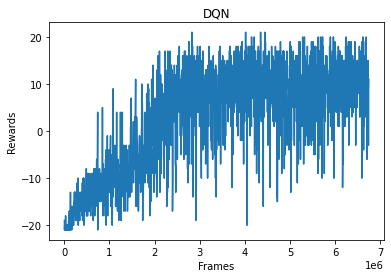

Episode:  1841
Steps:  1684729  epsilon:  0.03
Steps:  1684929  epsilon:  0.03
Steps:  1685129  epsilon:  0.03
Steps:  1685329  epsilon:  0.03
Steps:  1685529  epsilon:  0.03
Episode:  1842
Steps:  1685670  epsilon:  0.03
Steps:  1685870  epsilon:  0.03
Steps:  1686070  epsilon:  0.03
Steps:  1686270  epsilon:  0.03
Steps:  1686470  epsilon:  0.03
Episode:  1843
Steps:  1686602  epsilon:  0.03
Steps:  1686802  epsilon:  0.03
Steps:  1687002  epsilon:  0.03
Steps:  1687202  epsilon:  0.03
Steps:  1687402  epsilon:  0.03
Steps:  1687602  epsilon:  0.03
Episode:  1844
Steps:  1687650  epsilon:  0.03
Steps:  1687850  epsilon:  0.03
Steps:  1688050  epsilon:  0.03
Steps:  1688250  epsilon:  0.03
Episode:  1845
Steps:  1688450  epsilon:  0.03
Steps:  1688650  epsilon:  0.03
Steps:  1688850  epsilon:  0.03
Steps:  1689050  epsilon:  0.03
Steps:  1689250  epsilon:  0.03
Episode:  1846
Steps:  1689341  epsilon:  0.03
Steps:  1689541  epsilon:  0.03
Steps:  1689741  epsilon:  0.03
Steps:  168994

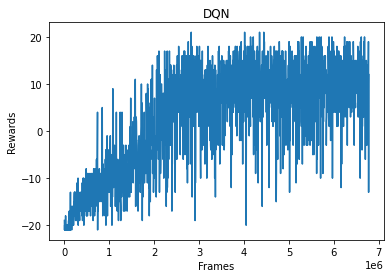

Episode:  1851
Steps:  1693693  epsilon:  0.03
Steps:  1693893  epsilon:  0.03
Steps:  1694093  epsilon:  0.03
Steps:  1694293  epsilon:  0.03
Steps:  1694493  epsilon:  0.03
Steps:  1694693  epsilon:  0.03
Episode:  1852
Steps:  1694776  epsilon:  0.03
Steps:  1694976  epsilon:  0.03
Steps:  1695176  epsilon:  0.03
Steps:  1695376  epsilon:  0.03
Steps:  1695576  epsilon:  0.03
Episode:  1853
Steps:  1695657  epsilon:  0.03
Steps:  1695857  epsilon:  0.03
Steps:  1696057  epsilon:  0.03
Steps:  1696257  epsilon:  0.03
Steps:  1696457  epsilon:  0.03
Steps:  1696657  epsilon:  0.03
Steps:  1696857  epsilon:  0.03
Episode:  1854
Steps:  1696875  epsilon:  0.03
Steps:  1697075  epsilon:  0.03
Steps:  1697275  epsilon:  0.03
Steps:  1697475  epsilon:  0.03
Steps:  1697675  epsilon:  0.03
Episode:  1855
Steps:  1697728  epsilon:  0.03
Steps:  1697928  epsilon:  0.03
Steps:  1698128  epsilon:  0.03
Steps:  1698328  epsilon:  0.03
Steps:  1698528  epsilon:  0.03
Episode:  1856
Steps:  169862

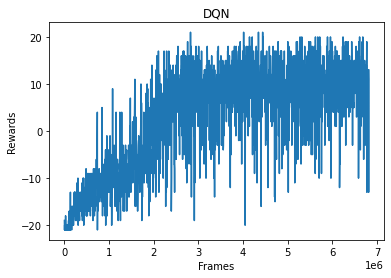

Episode:  1861
Steps:  1703280  epsilon:  0.03
Steps:  1703480  epsilon:  0.03
Steps:  1703680  epsilon:  0.03
Steps:  1703880  epsilon:  0.03
Steps:  1704080  epsilon:  0.03
Steps:  1704280  epsilon:  0.03
Steps:  1704480  epsilon:  0.03
Steps:  1704680  epsilon:  0.03
Episode:  1862
Steps:  1704780  epsilon:  0.03
Steps:  1704980  epsilon:  0.03
Steps:  1705180  epsilon:  0.03
Steps:  1705380  epsilon:  0.03
Steps:  1705580  epsilon:  0.03
Episode:  1863
Steps:  1705667  epsilon:  0.03
Steps:  1705867  epsilon:  0.03
Steps:  1706067  epsilon:  0.03
Steps:  1706267  epsilon:  0.03
Episode:  1864
Steps:  1706392  epsilon:  0.03
Steps:  1706592  epsilon:  0.03
Steps:  1706792  epsilon:  0.03
Steps:  1706992  epsilon:  0.03
Steps:  1707192  epsilon:  0.03
Steps:  1707392  epsilon:  0.03
Episode:  1865
Steps:  1707466  epsilon:  0.03
Steps:  1707666  epsilon:  0.03
Steps:  1707866  epsilon:  0.03
Steps:  1708066  epsilon:  0.03
Episode:  1866
Steps:  1708245  epsilon:  0.03
Steps:  170844

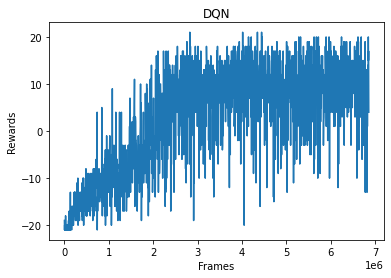

Episode:  1871
Steps:  1712490  epsilon:  0.03
Steps:  1712690  epsilon:  0.03
Steps:  1712890  epsilon:  0.03
Steps:  1713090  epsilon:  0.03
Steps:  1713290  epsilon:  0.03
Steps:  1713490  epsilon:  0.03
Episode:  1872
Steps:  1713685  epsilon:  0.03
Steps:  1713885  epsilon:  0.03
Steps:  1714085  epsilon:  0.03
Steps:  1714285  epsilon:  0.03
Steps:  1714485  epsilon:  0.03
Episode:  1873
Steps:  1714592  epsilon:  0.03
Steps:  1714792  epsilon:  0.03
Steps:  1714992  epsilon:  0.03
Steps:  1715192  epsilon:  0.03
Steps:  1715392  epsilon:  0.03
Episode:  1874
Steps:  1715436  epsilon:  0.03
Steps:  1715636  epsilon:  0.03
Steps:  1715836  epsilon:  0.03
Steps:  1716036  epsilon:  0.03
Steps:  1716236  epsilon:  0.03
Steps:  1716436  epsilon:  0.03
Steps:  1716636  epsilon:  0.03
Episode:  1875
Steps:  1716686  epsilon:  0.03
Steps:  1716886  epsilon:  0.03
Steps:  1717086  epsilon:  0.03
Steps:  1717286  epsilon:  0.03
Steps:  1717486  epsilon:  0.03
Steps:  1717686  epsilon:  0.

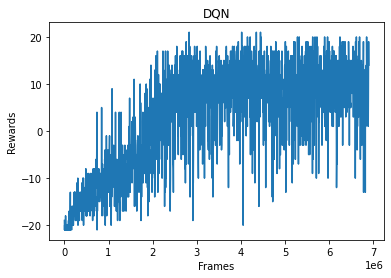

Episode:  1881
Steps:  1722114  epsilon:  0.03
Steps:  1722314  epsilon:  0.03
Steps:  1722514  epsilon:  0.03
Steps:  1722714  epsilon:  0.03
Steps:  1722914  epsilon:  0.03
Episode:  1882
Steps:  1722980  epsilon:  0.03
Steps:  1723180  epsilon:  0.03
Steps:  1723380  epsilon:  0.03
Steps:  1723580  epsilon:  0.03
Steps:  1723780  epsilon:  0.03
Episode:  1883
Steps:  1723869  epsilon:  0.03
Steps:  1724069  epsilon:  0.03
Steps:  1724269  epsilon:  0.03
Steps:  1724469  epsilon:  0.03
Episode:  1884
Steps:  1724651  epsilon:  0.03
Steps:  1724851  epsilon:  0.03
Steps:  1725051  epsilon:  0.03
Steps:  1725251  epsilon:  0.03
Steps:  1725451  epsilon:  0.03
Steps:  1725651  epsilon:  0.03
Episode:  1885
Steps:  1725793  epsilon:  0.03
Steps:  1725993  epsilon:  0.03
Steps:  1726193  epsilon:  0.03
Steps:  1726393  epsilon:  0.03
Steps:  1726593  epsilon:  0.03
Episode:  1886
Steps:  1726627  epsilon:  0.03
Steps:  1726827  epsilon:  0.03
Steps:  1727027  epsilon:  0.03
Episode:  1887

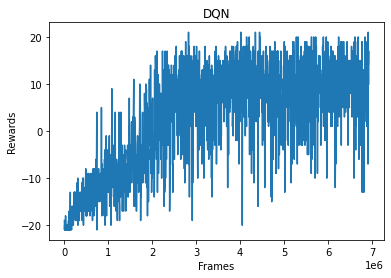

Episode:  1891
Steps:  1730480  epsilon:  0.03
Steps:  1730680  epsilon:  0.03
Steps:  1730880  epsilon:  0.03
Steps:  1731080  epsilon:  0.03
Episode:  1892
Steps:  1731269  epsilon:  0.03
Steps:  1731469  epsilon:  0.03
Steps:  1731669  epsilon:  0.03
Steps:  1731869  epsilon:  0.03
Episode:  1893
Steps:  1732060  epsilon:  0.03
Steps:  1732260  epsilon:  0.03
Steps:  1732460  epsilon:  0.03
Steps:  1732660  epsilon:  0.03
Steps:  1732860  epsilon:  0.03
Episode:  1894
Steps:  1732937  epsilon:  0.03
Steps:  1733137  epsilon:  0.03
Steps:  1733337  epsilon:  0.03
Steps:  1733537  epsilon:  0.03
Episode:  1895
Steps:  1733686  epsilon:  0.03
Steps:  1733886  epsilon:  0.03
Steps:  1734086  epsilon:  0.03
Steps:  1734286  epsilon:  0.03
Episode:  1896
Steps:  1734471  epsilon:  0.03
Steps:  1734671  epsilon:  0.03
Steps:  1734871  epsilon:  0.03
Steps:  1735071  epsilon:  0.03
Steps:  1735271  epsilon:  0.03
Episode:  1897
Steps:  1735323  epsilon:  0.03
Steps:  1735523  epsilon:  0.03

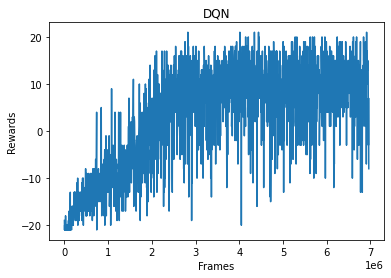

Episode:  1901
Steps:  1739613  epsilon:  0.03
Steps:  1739813  epsilon:  0.03
Steps:  1740013  epsilon:  0.03
Steps:  1740213  epsilon:  0.03
Episode:  1902
Steps:  1740389  epsilon:  0.03
Steps:  1740589  epsilon:  0.03
Steps:  1740789  epsilon:  0.03
Steps:  1740989  epsilon:  0.03
Steps:  1741189  epsilon:  0.03
Steps:  1741389  epsilon:  0.03
Episode:  1903
Steps:  1741435  epsilon:  0.03
Steps:  1741635  epsilon:  0.03
Steps:  1741835  epsilon:  0.03
Steps:  1742035  epsilon:  0.03
Steps:  1742235  epsilon:  0.03
Steps:  1742435  epsilon:  0.03
Steps:  1742635  epsilon:  0.03
Episode:  1904
Steps:  1742670  epsilon:  0.03
Steps:  1742870  epsilon:  0.03
Steps:  1743070  epsilon:  0.03
Steps:  1743270  epsilon:  0.03
Steps:  1743470  epsilon:  0.03
Steps:  1743670  epsilon:  0.03
Episode:  1905
Steps:  1743840  epsilon:  0.03
Steps:  1744040  epsilon:  0.03
Steps:  1744240  epsilon:  0.03
Steps:  1744440  epsilon:  0.03
Steps:  1744640  epsilon:  0.03
Episode:  1906
Steps:  174475

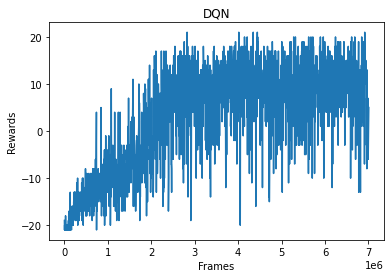

Episode:  1911
Steps:  1750481  epsilon:  0.03
Steps:  1750681  epsilon:  0.03
Steps:  1750881  epsilon:  0.03
Steps:  1751081  epsilon:  0.03
Steps:  1751281  epsilon:  0.03
Steps:  1751481  epsilon:  0.03
Episode:  1912
Steps:  1751546  epsilon:  0.03
Steps:  1751746  epsilon:  0.03
Steps:  1751946  epsilon:  0.03
Steps:  1752146  epsilon:  0.03
Steps:  1752346  epsilon:  0.03
Episode:  1913
Steps:  1752398  epsilon:  0.03
Steps:  1752598  epsilon:  0.03
Steps:  1752798  epsilon:  0.03
Steps:  1752998  epsilon:  0.03
Steps:  1753198  epsilon:  0.03
Steps:  1753398  epsilon:  0.03
Episode:  1914
Steps:  1753478  epsilon:  0.03
Steps:  1753678  epsilon:  0.03
Steps:  1753878  epsilon:  0.03
Steps:  1754078  epsilon:  0.03
Steps:  1754278  epsilon:  0.03
Steps:  1754478  epsilon:  0.03
Episode:  1915
Steps:  1754538  epsilon:  0.03
Steps:  1754738  epsilon:  0.03
Steps:  1754938  epsilon:  0.03
Steps:  1755138  epsilon:  0.03
Steps:  1755338  epsilon:  0.03
Steps:  1755538  epsilon:  0.

In [0]:
EPSILON = 1
MIN_EPSILON = 0.03
DECAY = 20000
env = gym.make("Pong-v0")
n_actions = env.action_space.n
agent = Agent(num_frames, n_actions)
durations = []
Rewards=[]
frames=[]
frame_cnt=0
steps_done=0

def TrainAgent(episodes):
    global frame_cnt
    global R
    global steps_done
    for episode in range(episodes):
        print("Episode: ", episode)
        env.reset()
        states = [i for i in range(num_frames)]
        actions = [i for i in range(num_frames-1)]
        done = [False for i in range(num_frames-1)]
        for i in range(num_frames-1):
            states[i] = get_preprocessed_state()
            actions[i] = get_variable(torch.tensor([[random.randrange(n_actions)]]))
            _, _, done[i], _ = env.step(actions[i].item())
            
        states[num_frames-1] = get_preprocessed_state()
        state = get_variable( Variable(torch.cat([states[i].squeeze(0) for i in range(num_frames)]).unsqueeze(0)))
        Reward = 0.0
        frame_cnt += num_frames
        
        if(sum(done) != 0):
            Rewards.append(Reward)
            frames.append(frame_cnt)
        else:
            for steps in count():
                #decay epsilon for each step
                epsilon = decay_epsilon(steps_done)
                steps_done +=1
                if random.random() > epsilon:
                    with torch.no_grad():
                        action = get_variable(agent.model(state).max(1)[1].view(1, 1))
                else:
                    action = get_variable(torch.tensor([[random.randrange(n_actions)]], dtype=torch.long))
                re = 0.0
                s = [i for i in range(num_frames)]
                ended = [False for i in range(num_frames)]
                for i in range(num_frames):
                    _, r, ended[i], _ = env.step(action.item())
                    frame_cnt += 1
                    re += r
                    s[i] = get_preprocessed_state()
                    if ended[i]:
                        break
                reward = get_variable(torch.tensor([re]))
                
                #printing output every 200 steps!!
                if steps % 200 == 0:
                    print("Steps: ", steps_done, " epsilon: ", epsilon)
                
                if sum(ended) == 0:
                    next_state = get_variable(torch.cat([s[i].squeeze(0) for i in range(num_frames)]).unsqueeze(0))
                    
                else:
                    next_state = None
                # Add each transition into the replay memory
                agent.memory.add(state, action, next_state, reward)
                
                state = Variable(next_state)
                Reward += re
                
                
                agent.train()
                if(sum(ended) != 0):
                    Rewards.append(Reward)
                    frames.append(frame_cnt)
                    break
                    
                if frame_cnt % TARGET_UPDATE_FREQUENCY == 0:
                    agent.target_model.load_state_dict(agent.model.state_dict())
                    
            if episode % 10 == 0:
                plt.plot(frames, Rewards)
                plt.xlabel('Frames')
                plt.ylabel('Rewards')
                plt.title("DQN")
                plt.show()
    #the below statement didn't get executed due to technical limitations(colab time was up)    
    torch.save(agent.model.state_dict(), path)

TrainAgent(episodes)

## References

1. https://github.com/adamtiger/DQN/tree/f4aa6e9fb31ac72568f20509097c9981c77b73e4
2. https://pytorch.org/tutorials/beginner/saving_loading_models.html
3. https://pytorch.org/docs/stable/nn.html
4. https://pytorch.org/cppdocs/api/classtorch_1_1nn_1_1_conv2d.html
5. https://discuss.pytorch.org/t/how-to-convert-array-to-tensor/28809
6. https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
7. https://github.com/chaitanya100100/RL-Algorithms-Pytorch/tree/master/DQN_DDQN
8. https://www.neuralnet.ai/coding-a-deep-q-network-in-pytorch/